# Code to reproduce the figures of Day et al., *The Cryosphere*, 2025

Prerequisites:
- 

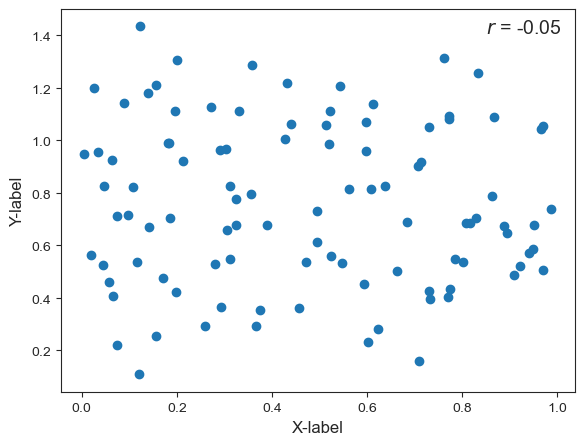

In [1]:
from io import BytesIO
import xarray as xr
import matplotlib
import time
# import imageio.v3 as iio
import glob
from datetime import datetime, timedelta
import os
from PIL import Image
import cartopy.crs as ccrs

import geopy.distance
import textwrap
import metpy.calc as mpcalc
from metpy.units import units
from geopy.distance import geodesic
import platform
import sys
import os
# Add functions directory to path
sys.path.append(os.path.join(os.getcwd(), 'Code-MIZ-cyclones/functions'))

from system_setup import *
savepath, netcdfpath = getSavePath()
from breakup_indentification import *
from formatting import *
from plotting import *
from fstd import *
from simple_maths import *

import matplotlib.ticker as mticker
import matplotlib.font_manager as fm
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.font_manager as fm
from matplotlib.patches import Rectangle
from matplotlib import animation
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
import matplotlib.lines as mlines
from matplotlib.transforms import Affine2D

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.gridspec as gridspec
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

from matplotlib.lines import Line2D
from matplotlib.colors import Normalize


def latitude_formatter(x, pos):
    return f'{abs(x):.1f}$^\circ$ {"S" if x < 0 else "N"}'

def longitude_formatter(x, pos):
    return f'{abs(x):.0f}$^\circ$ {"W" if x < 0 else "E"}'


def fixCyclicPoint(data, datatype='jra'):
    if datatype=='jra':
        if abs(np.diff(data.longitude, 1)).max() > 180:
            temp_lons = data.longitude.apply(lambda x: x - 360 if x > 180 else x)
            data.longitude = temp_lons
        else:
            temp_lons = data.longitude
    elif datatype=='CICE_lon':
        if abs(abs(np.diff(data.lon.values,1))).max() > 180:
            temp_lons = data.lon.values
            idx = temp_lons > 180
            temp_lons[idx] = temp_lons[idx] - 360
        else:
            temp_lons = data.lon.values
    elif datatype=='CICE':
        if abs(abs(np.diff(data.TLON.values,1))).max() > 180:
            temp_lons = data.TLON.values
            idx = temp_lons > 180
            temp_lons[idx] = temp_lons[idx] - 360
        else:
            temp_lons = data.TLON.values
    else:
        if abs(abs(np.diff(data,1))).max() > 180:
            temp_lons = data
            idx = temp_lons > 180
            temp_lons[idx] = temp_lons[idx] - 360
        else:
            temp_lons = data

    return temp_lons

def getEachBreakupIdx(breakup_idx):
    '''
    Given an boolean array of when the breakup threshold has been met return each breakup event. 
    A breakup event is defined as when continued breakup occurs.

    Input: Boolean array
    Output: Stacked boolean array of each breakup event
    '''

    int_arr = breakup_idx.astype(int)
    # Add an artificial value from the start
    int_arr = np.insert(int_arr, 0, 0)
    diff = np.diff(int_arr)
    transition_indexes = np.where(diff == 1)[0]
    transition_indexes_end = np.where(diff == -1)[0] + 1
    
    # Add a starting point if the first element in True
    # if transition_indexes[0]:
    #     transition_indexes = np.insert(transition_indexes, 0, 0)
    
    breakup_idx_stacked = []
    
    # Stack these breakup events
    for i in np.arange(0, len(transition_indexes), 1):
        new_array = np.full(breakup_idx.shape, False)
        if i >= len(transition_indexes_end):
            new_array[transition_indexes[i]:] = breakup_idx[transition_indexes[i]:]
            # print( breakup_idx[transition_indexes[i]])
        else:
            new_array[transition_indexes[i]:transition_indexes_end[i]] = breakup_idx[transition_indexes[i]:transition_indexes_end[i]]
            # print(breakup_idx[transition_indexes[i]:transition_indexes_end[i]+1])
        breakup_idx_stacked.append(new_array)
    
    # Check to see if there are any errors
    if ~(np.sum(breakup_idx_stacked, axis=0).astype(bool) == breakup_idx).all():
        print("Error: Breakup indexes not retained!")
        print(np.sum(breakup_idx_stacked, axis=0).astype(bool))
        print(breakup_idx)

    return breakup_idx_stacked

def getMajorEvents(breakup_events_array, time_threshold=6):
    # Given a stacked array of all breakup events return those that persist for longer than time_threshold:
    idx_bool = np.sum(breakup_events_array, axis=1) >= time_threshold
    idx = np.where(idx_bool)[0]

    major_events_stacked = []
    for i in idx:
        major_events_stacked.append(breakup_events_array[i])
    return major_events_stacked

textwidth = 3.31314*2
aspect_ratio = 6/8
scale = 1.0
width = textwidth * scale
height = width * aspect_ratio
fontsize = 12
ticks_fontsize = 10
label_x = 0.025
label_y = 0.975
# Scalar formatter for scientific notation
from matplotlib.ticker import ScalarFormatter
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-2, 2))  # Display scientific notation for values outside this range



diff = 1121 # Difference in the CICE grid from 0 degrees E
testPlot() # Test that the figure settings have been imported

In [2]:
# Get repo path
repo_path = os.path.join(os.getcwd(), 'Code-MIZ-cyclones')
netcdfpath = os.path.join(repo_path, 'data/')
repo_path, netcdfpath

('/home/566/nd0349/Code-MIZ-cyclones',
 '/home/566/nd0349/Code-MIZ-cyclones/data/')

# TODO
- Put all data in a zenodo
- Put in a code line here that downloads the zenodo into the data directory

In [11]:
ln -s /g/data/gv90/nd0349/antarctic-cyclones/CICE-outputs/201521319_CICE_output.nc /home/566/nd0349/Code-MIZ-cyclones/data/CICE-outputs/201521319_CICE_output.nc
ln -s /g/data/gv90/nd0349/antarctic-cyclones/area/201521319_area.nc /home/566/nd0349/Code-MIZ-cyclones/data/area/201521319_area.nc
ln -s /g/data/gv90/nd0349/antarctic-cyclones/ice-edge/201521319_ice_edge.nc /home/566/nd0349/Code-MIZ-cyclones/data/ice-edge/201521319_ice_edge.nc

ln -s /g/data/gv90/nd0349/antarctic-cyclones/CICE-outputs/201622187_CICE_output.nc /home/566/nd0349/Code-MIZ-cyclones/data/CICE-outputs/201622187_CICE_output.nc
ln -s /g/data/gv90/nd0349/antarctic-cyclones/area/201622187_area.nc /home/566/nd0349/Code-MIZ-cyclones/data/area/201622187_area.nc
ln -s /g/data/gv90/nd0349/antarctic-cyclones/ice-edge/201622187_ice_edge.nc /home/566/nd0349/Code-MIZ-cyclones/data/ice-edge/201622187_ice_edge.nc

ln -s /g/data/gv90/nd0349/antarctic-cyclones/CICE-outputs/201626905_CICE_output.nc /home/566/nd0349/Code-MIZ-cyclones/data/CICE-outputs/201626905_CICE_output.nc
ln -s /g/data/gv90/nd0349/antarctic-cyclones/area/201626905_area.nc /home/566/nd0349/Code-MIZ-cyclones/data/area/201626905_area.nc
ln -s /g/data/gv90/nd0349/antarctic-cyclones/ice-edge/201626905_ice_edge.nc /home/566/nd0349/Code-MIZ-cyclones/data/ice-edge/201626905_ice_edge.nc


ln -s /g/data/gv90/nd0349/antarctic-cyclones/csvs/storm_ts_n347_single_cross.csv /home/566/nd0349/Code-MIZ-cyclones/data/csvs/storm_ts_n347_single_cross.csv 
ln -s /g/data/gv90/nd0349/antarctic-cyclones/csvs/dynamics_extravars_events_0ms_n_263.csv /home/566/nd0349/Code-MIZ-cyclones/data/csvs/dynamics_extravars_events_0ms_n_263.csv 
ln -s /g/data/gv90/nd0349/antarctic-cyclones/csvs/breakup_n_347.csv /home/566/nd0349/Code-MIZ-cyclones/data/csvs/breakup_n_347.csv 

ln -s /g/data/gv90/nd0349/antarctic-cyclones/csvs/dynamics_area_events_n274.csv /home/566/nd0349/Code-MIZ-cyclones/data/csvs/dynamics_area_events_n274.csv 

# breakup_n_346
# /breakup_n_347.csv'
'/home/566/nd0349/Code-MIZ-cyclones/data/area/201622187_area.nc'

cp: failed to close '/home/566/nd0349/Code-MIZ-cyclones/data/CICE-outputs/201521319_CICE_output.nc': Disk quota exceeded


In [41]:
# '/home/566/nd0349/Code-MIZ-cyclones/data/csvs/dynamics_area_events_n274.csv'

In [3]:
# CODE TO PUT INTO FUNCTIONS
def makeCycloneTrackDataset(df_single_track, ds_CICE):
    df_single_track['date'] = pd.to_datetime(df_single_track['date'])

    # Create the DataArray
    xarray_tmp = xr.DataArray(
        data=df_single_track['central_pressure [hPa]'],  # Assuming latitude is already aligned properly
        dims=['time'],
        coords={
            'time': df_single_track['date']
        },
        name='central_pressure'
    )
    
    dataset = xarray_tmp.to_dataset(name='central_pressure')
    
    dataset['longitude'] = ('time', df_single_track['longitude'])
    dataset['latitude'] = ('time', df_single_track['latitude'])
    dataset['laplacian_of_central_pressure'] = ('time', df_single_track['laplacian_of_central_pressure [hPa/degree latitude**2]'])
    dataset['cyclone_depth'] = ('time', df_single_track['cyclone_depth [hPa]'])
    dataset['cyclone_radius'] = ('time', df_single_track['cyclone_radius [degrees latitude]'])
    dataset['eastward_steering_velocity'] = ('time', df_single_track['eastward_steering_velocity [m/s]'])
    dataset['northward_steering_velocity'] = ('time', df_single_track['northward_steering_velocity [m/s]'])
    
    dataset['longitude'].attrs['units'] = 'degrees'
    dataset['latitude'].attrs['units'] = 'degrees'
    dataset['laplacian_of_central_pressure'].attrs['units'] = 'hPa/degree latitude^2'
    dataset['cyclone_depth'].attrs['units'] = 'hPa'
    dataset['cyclone_radius'].attrs['units'] = 'degrees latitude'
    dataset['eastward_steering_velocity'].attrs['units'] = 'm/s'
    dataset['northward_steering_velocity'].attrs['units'] = 'm/s'
    
    ds_CICE['time'] = pd.to_datetime(ds_CICE.time)
    
    # Now perform the interpolation
    dataset_interp = dataset.interp(time=ds_CICE.time)
    dataset_interp
    return dataset_interp

def getCrossingTime(ds_CICE_in, xarrayTrack_in):
    deg_lat_between_cyclone_and_ice_edge = []
    times = []
    
    # Check if all values in ds_CICE_in['TLON'] are NaN
    if np.all(np.isnan(ds_CICE_in['TLON'].values)):
        print('All NaNs in CICE')
        return None, None, None
    
    for i, time in enumerate(xarrayTrack_in.time):
        ds_tmp = ds_CICE_in.sel(time=time)
        
        # Check for NaN in time
        if np.isnan(time):
            print(f"ERROR: NAN in time at index {i}")
            deg_lat_between_cyclone_and_ice_edge.append(np.inf)
            continue
        
        # Check for NaN in longitude
        longitude = xarrayTrack_in['longitude'].sel(time=time).values
        if np.isnan(longitude):
            print(f"Warning: NAN in longitude at index {i}")
            deg_lat_between_cyclone_and_ice_edge.append(np.inf)
            continue
        
        # Identify the ni index closest to the cyclone's longitude
        cyclone_ni = int(abs(ds_tmp['TLON'] - longitude).argmin(dim='ni').mean())
        
        # Identify the nj index corresponding to the ice edge
        ice_mask = ds_tmp['aice'] > 0.15
        ice_edge_nj = ds_tmp['TLAT'].where(ice_mask).sel(ni=cyclone_ni).argmax(dim='nj')
        
        # Get coordinates of the ice edge
        ice_edge_coord = [
            ds_tmp['TLON'].sel(ni=cyclone_ni, nj=ice_edge_nj).values,
            ds_tmp['TLAT'].sel(ni=cyclone_ni, nj=ice_edge_nj).values
        ]
        
        # Calculate the difference in latitude between the cyclone and the ice edge
        deg_lat_diff = (xarrayTrack_in['latitude'].sel(time=time) - ice_edge_coord[1]).values
        deg_lat_between_cyclone_and_ice_edge.append(deg_lat_diff)
        times.append(time.values)
    
    # Convert the list to a numpy array and find the minimum distance
    deg_lat_between_cyclone_and_ice_edge = np.array(deg_lat_between_cyclone_and_ice_edge).flatten()
    if abs(deg_lat_between_cyclone_and_ice_edge).min() > 1.0:
        print("Cyclone doesn't cross ice edge (> 1 deg.)")
        return None, None, None
        
    crossing_idx = abs(deg_lat_between_cyclone_and_ice_edge).argmin()
    crossing_time = times[crossing_idx]
    
    return crossing_time, crossing_idx, deg_lat_between_cyclone_and_ice_edge

In [4]:
# Custom formatter to append the year to the last tick
def custom_date_formatter(x, pos):
    if pos == len(ax_middle.get_xticks()) - 1:  # Last tick
        return mdates.num2date(x).strftime('%b %d, %Y')  # Add year
    else:
        return mdates.num2date(x).strftime('%b %d')  # No year for other ticks

# Define formatters for latitude and longitude
def latitude_formatter(x, pos):
    return f'{abs(x):.1f}$^\circ$ {"S" if x < 0 else "N"}'

def longitude_formatter(x, pos):
    return f'{abs(x):.0f}$^\circ$ {"W" if x < 0 else "E"}'


In [5]:
savepath

'/home/566/nd0349/Code-MIZ-cyclones/figures/'

## Case Study 1: Thermodynamics

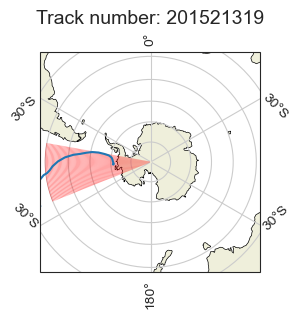

<xarray.Dataset> Size: 11kB
Dimensions:                        (time: 151)
Coordinates:
  * time                           (time) datetime64[ns] 1kB 2015-08-02T05:00...
Data variables:
    central_pressure               (time) float64 1kB nan 1.004e+03 ... 973.1
    longitude                      (time) float64 1kB nan -111.9 ... -93.8
    latitude                       (time) float64 1kB nan -34.53 ... -71.06
    laplacian_of_central_pressure  (time) float64 1kB nan 1.0 ... 0.9243 0.8297
    cyclone_depth                  (time) float64 1kB nan 4.613 ... 3.071 2.693
    cyclone_radius                 (time) float64 1kB nan 5.718 ... 2.954 2.799
    eastward_steering_velocity     (time) float64 1kB nan -3.129 ... 0.8807
    northward_steering_velocity    (time) float64 1kB nan -0.91 ... 1.911 1.734

In [6]:
def read_in_track(track_number):
    df_cyclone = pd.read_csv(repo_path + '/data/ERA-tracks/extratropical_v0.2.csv') 
    df_single_track = df_cyclone.copy()
    index = df_single_track[(df_single_track['# track'] != track_number)].index
    df_single_track.drop(index , inplace=True)
    cice_output_file = os.path.join(repo_path, "data/CICE-outputs/{}_CICE_output.nc".format(track_number))
    ds = xr.open_dataset(cice_output_file).isel(time=slice(0,-1)).isel(ni=slice(100,-1))
    ds['time'] = pd.to_datetime(ds['time'])
    # Normalize longitudes in the dataset ds to the range [-180, 180]
    ds['TLON'] = ds['TLON'].where(ds['TLON'] <= 180, ds['TLON'] - 360)
    ds['TLON'] = ds['TLON'].where(ds['TLON'] >= -180, ds['TLON'] + 360)
    df_single_track['date'] = pd.to_datetime(df_single_track['date'])
    cice_output_file = repo_path + "CICE-outputs/{}_CICE_basic_outputs.nc".format(track_number)
    # Normalize longitudes in the dataframe df_single_track to the range [-180, 180]
    df_single_track['longitude'] = df_single_track['longitude'].where(df_single_track['longitude'] <= 180, df_single_track['longitude'] - 360)
    df_single_track['longitude'] = df_single_track['longitude'].where(df_single_track['longitude'] >= -180, df_single_track['longitude'] + 360)

    return df_single_track, ds, cice_output_file

track_number =  201521319 
df_single_track, ds, cice_output_file = read_in_track(track_number)
plotSectorMap(df_single_track, savepath, npoints=100, fixed_lat=-40)

xarrayTrack = makeCycloneTrackDataset(df_single_track, ds)
crossing_time, crossing_idx, distance_deg = getCrossingTime(ds, xarrayTrack)

xarrayTrack

In [8]:
def setUpPlot(ax_tmp, ds):
    # Land mask
    pc=ax_tmp.pcolormesh(ds.TLON, ds.TLAT, land_mask.where(land_mask == 1), cmap='Greys', shading='auto', vmin=0, vmax=2, zorder=0)
    pc.set_rasterized(True)
    # Plot pressure contours
    contour = ax_tmp.contour(ds.TLON, ds.TLAT, ds['psl'].isel(time=time_idx)/100,
                         levels=np.arange(850, 1100, 10), colors='k', linewidths=0.5, alpha=0.4)
    ax_tmp.clabel(contour, inline=1, fontsize=8, fmt='%1.0f hPa', inline_spacing=5, rightside_up=True)

    ax_tmp.contour(ds.TLON, ds.TLAT, ds['aice'].isel(time=time_idx), levels=[0.15], colors='k', linewidths=0.75)
    ax_tmp.contour(ds.TLON, ds.TLAT, ds['fsdrad'].isel(time=time_idx), levels=[100], colors='k', linewidths=0.75)
    ax_tmp.plot(xarrayTrack['longitude'], xarrayTrack['latitude'], label='Cyclone', color=CYCLONE_TRACK_COLOR, linestyle='--', 
                zorder=2)
    tmp_time = ds['time'].isel(time=time_idx)
    ax_tmp.scatter(xarrayTrack['longitude'].sel(time=tmp_time), xarrayTrack['latitude'].sel(time=tmp_time), 
               label='Cyclone', color=CYCLONE_TRACK_COLOR, s=20, zorder=2)

    ax_tmp.contourf(ds.TLON, ds.TLAT, ds['iage'].where(ds['aice']>0.15).isel(time=time_idx),
                    levels=[0, 3/52],  # Set appropriate levels for hatching
                    hatches=['xxxx'],  # Specify your hatching patterns
                    colors='none', zorder=2)  # No colors, only hatching
    
    ax_tmp.set(ylim=(ylim_range[0], ylim_range[1]))
    return ax_tmp

df_single_track['date'] = pd.to_datetime(df_single_track['date'])
ds['miz_width_100']  = (ds['HTE'].where(ds['aice']>0.15).where(ds['fsdrad']<100)).sum(dim='nj')
ds['time'] = pd.to_datetime(ds['time'])
ds['speed'] = np.sqrt(ds['uvel']**2 + ds['vvel']**2)
ds['vvel_100']  = (ds['vvel'].where(ds['aice']>0.15).where(ds['fsdrad']<100)).mean(dim='nj')
ds['vatm_100']  = (ds['vatm'].where(ds['aice']>0.15).where(ds['fsdrad']<100)).mean(dim='nj')
ds['dTairdt'] = ds['Tair'].diff(dim='time', n=1)
ds['dTsfcdt'] = ds['Tsfc'].diff(dim='time', n=1)
ds['diagedt'] = ds['iage'].diff(dim='time', n=1)

land_mask = np.isnan(ds['aice'].isel(time=0))

if track_number ==  201626905:
    xlim_range = [45, 105]
    ylim_range = [-75, -48]
else:
    xlim_range = [ds.TLON.min().values, ds.TLON.max().values]
    ylim_range=[-75, -48]


# Constants
CYCLONE_TRACK_COLOR = 'magenta'

mid_point_idx = np.argmin(abs(ds.time.values - crossing_time))
time_indices = [mid_point_idx-24, mid_point_idx, mid_point_idx+24]
diff = 1121

# Create a 2-row grid: first row for the 3 subplots (vorticity), second row for divergence
fig, axs = plt.subplots(4, 3, figsize=[width, (4/2)*height], sharex=False, gridspec_kw={'height_ratios': [1, 1, 1, 1]})

# Loop through the time indices and plot each subplot
for i, time_idx in enumerate(time_indices):
    ax = axs[0, i]  # Get the current axis for the top row (vorticity)
    
    time_difference = abs(pd.to_datetime(df_single_track['date']) - ds.time.isel(time=time_idx).values)
    min_track_idx = time_difference.argmin()
    ax = setUpPlot(ax, ds)

    # Plot ice concentration (First pcolormesh - Vorticity)
    vmax = abs(ds['Tair']).max().values
    vmin = -vmax
    vmin -= 1.8*2
    vmax -= 1.8*2
    pcol1 = ax.pcolormesh(ds.TLON, ds.TLAT, ds['Tair'].isel(time=time_idx),
                          cmap=cmo.balance, vmin=vmin, vmax=vmax, shading='auto', zorder=0)
    pcol1.set_rasterized(True)


    # Optional: Add title for each subplot
    time_str = pd.to_datetime(ds.time.isel(time=time_idx).values).strftime('%Y-%m-%dT%H')
    ax.set_title(time_str, fontsize=fontsize, pad=10)
    ax.text(label_x, label_y, f'({chr(97 + i)})', 
        transform=ax.transAxes, 
        fontsize=fontsize, 
        verticalalignment='top', 
        horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.1'),
        zorder=5)

    ax.set(xlim=xlim_range)

    # AXIS2: Ice vorticity
    ax2 = axs[1, i]  # Get the current axis for the top row (vorticity)
    
    time_difference = abs(pd.to_datetime(df_single_track['date']) - ds.time.isel(time=time_idx).values)
    min_track_idx = time_difference.argmin()
    
    ax2 = setUpPlot(ax2, ds)

    # Plot ice concentration (First pcolormesh - Vorticity)
    vmax = abs(ds['Tsfc']).max() 
    vmin = -vmax
    vmin -= 1.8*2
    vmax -= 1.8*2
    pcol2 = ax2.pcolormesh(ds.TLON, ds.TLAT, ds['Tsfc'].isel(time=time_idx).where(ds['aice'].isel(time=time_idx) > 0.15),
                          cmap=cmo.balance, vmin=vmin, vmax=vmax, shading='auto', zorder=0)
    pcol2.set_rasterized(True)
    time_str = pd.to_datetime(ds.time.isel(time=time_idx).values).strftime('%Y-%m-%dT%H')
    ax2.text(label_x, label_y, f'({chr(97 + i + 3)})', 
        transform=ax2.transAxes, 
        fontsize=fontsize, 
        verticalalignment='top', 
        horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.1'),
        zorder=5)

    ax2.set(xlim=(ds.TLON.min().values, ds.TLON.max().values))

    if i != 0:
        ax.set_yticklabels([])
        ax2.set_yticklabels([])
    else:
        ax.yaxis.set_major_formatter(mticker.FuncFormatter(latitude_formatter))
        ax2.yaxis.set_major_formatter(mticker.FuncFormatter(latitude_formatter))
        
    
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(longitude_formatter))
    ax2.xaxis.set_major_formatter(mticker.FuncFormatter(longitude_formatter))
        

# Hide the axes in the bottom row (those created in axs[1, :], which are not needed now)
axs[2, 0].axis('off')
axs[2, 1].axis('off')
axs[2, 2].axis('off')
axs[3, 0].axis('off')
axs[3, 1].axis('off')
axs[3, 2].axis('off')

# Get the position of each axis to align colorbars accordingly
pos1 = axs[0, 2].get_position()  # Position of first axis (top row)
pos2 = axs[1, 2].get_position()  # Position of second axis (middle row)

# Adjust layout and space for colorbars and white space between plots
fig.subplots_adjust(right=0.9, hspace=0.15, wspace=0.1)  # Adjust hspace for vertical space, wspace for horizontal
cbar_width = 0.02  # Width of the colorbar

# Create colorbar for vorticity (aligned with top row)
cbar_ax1 = fig.add_axes([0.92, pos1.y0, cbar_width, pos1.height])  # Align with axs[0, 2]
cbar1 = fig.colorbar(pcol1, cax=cbar_ax1, extend=None)
cbar1.set_label('Air temperature [$^{\circ}$C]', fontsize=10)

# Create colorbar for ice vorticity (aligned with middle row)
cbar_ax2 = fig.add_axes([0.92, pos2.y0+0.001, cbar_width, pos2.height])  # Align with axs[1, 2]
cbar2 = fig.colorbar(pcol2, cax=cbar_ax2, extend=None)
cbar2.set_label('Ice surface temperature [$^{\circ}$C]', fontsize=10)

# Add the inset map for Antarctica
pos1 = axs[0, 0].get_position() 
inset_ax = fig.add_axes([pos1.x0, pos1.y0-0.001, pos1.width/4, pos1.height/4], projection=ccrs.SouthPolarStereo())  # Adjust position and size of inset
inset_ax.set_extent([-180, 180, -90, -40], crs=ccrs.PlateCarree())  # Set the extent to focus on Antarctica
# Add Antarctica to the inset map
inset_ax.add_feature(cfeature.LAND, color='lightgray')
inset_ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
highlighted_area = Rectangle((ds.TLON.min().values, ds.TLAT.min().values), ds.TLON.max().values - ds.TLON.min().values, 30,
                 linewidth=1, edgecolor='red', facecolor='none', zorder=3, transform=ccrs.PlateCarree())
inset_ax.add_patch(highlighted_area)

axs[0,0].text(1 - 0.01, 0.01, 'Antarctica', 
        transform=axs[0,0].transAxes, 
        fontsize=fontsize-4, 
        verticalalignment='bottom', 
        horizontalalignment='right',
        zorder=3)

axs[0,0].text(1 - 0.01, 1, 'South\n America', 
        transform=axs[0,0].transAxes, 
        fontsize=fontsize-4, 
        verticalalignment='top', 
        horizontalalignment='right',
        zorder=3)



# Apply the formatter to each colorbar
cbar1.ax.yaxis.set_major_formatter(formatter)
cbar2.ax.yaxis.set_major_formatter(formatter)

# AX
ds_area = xr.open_dataset(f'{netcdfpath}area/{track_number}_area.nc').isel(radius=3)
ds_edge = xr.open_dataset(f'{netcdfpath}ice-edge/{track_number}_ice_edge.nc').isel(radius=3)


# Middle plot
ax_middle = fig.add_subplot(413)
ax_twin_middle = ax_middle.twinx()

color1 = 'tab:red'
ax_middle.plot(ds_area['time'], ds_area['meltb_miz'], color=color1, label='Basal')
ax_middle.plot(ds_area['time'], ds_area['meltt_miz'], color=color1, linestyle='--', label='Top')
ax_middle.plot(ds_area['time'], ds_area['meltl_miz'], color=color1, linestyle='-.', label='Lateral')
ax_middle.set_ylabel('Melt rate [$10^{-2}$ m h$^{-1}$]', color=color1)  # Label for the bottom axis
ax_middle.set_xlabel('')  # Label for the shared x-axis
ax_middle.tick_params(axis='y', labelcolor=color1)  # Set the y-ticks color for the bottom axis

color2 = 'tab:blue'
ax_twin_middle.plot(ds_area['time'], ds_area['frazil_miz'], color=color2, linestyle='-', label='Frazil')
ax_twin_middle.plot(ds_area['time'], ds_area['congel_miz'], color=color2, linestyle='--', label='Congelation')
ax_twin_middle.set_ylabel('Growth rate [$10^{-2}$ m h$^{-1}$]', color=color2)
ax_twin_middle.tick_params(axis='y', labelcolor=color2) 

ax_middle.text(label_x/3, label_y, f'({chr(97 + i + 4)})', 
        transform=ax_middle.transAxes, 
        fontsize=fontsize, 
        verticalalignment='top', 
        horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.1'),
        zorder=5)

ax_twin_middle.grid(False)
ax_middle.legend(loc="upper left", fancybox=False, framealpha=0, facecolor=None, edgecolor=None)
ax_twin_middle.legend(loc="upper right", fancybox=False, framealpha=0, facecolor=None, edgecolor=None, bbox_to_anchor=(1.0, 1.0), borderaxespad=0.)


# BOTTOM PLOT
ax_bottom = fig.add_subplot(414)
color1 = 'tab:blue'
ax_bottom.plot(ds_edge['time'], ds_edge['ice_edge'], color=color1, label='Ice edge')
ax_bottom.plot(ds_edge['time'], ds_edge['ice_edge'] -  ds_edge['miz_width']/110, color=color1, linestyle='--', label='MIZ interior')
ax_bottom.legend(loc="upper right", fancybox=False, framealpha=0, facecolor=None, edgecolor=None, bbox_to_anchor=(1.0, 0.6), borderaxespad=0.)

ax_bottom.yaxis.set_major_formatter(mticker.FuncFormatter(latitude_formatter))
ax_bottom.set_xlabel('')  # Label for the shared x-axis


# ANNOTATIONS
tmp_idx = ds_edge['miz_width'].argmin()
x_coord = ds_edge['time'][tmp_idx]
y_coord_center = (ds_edge['ice_edge'][tmp_idx] + ds_edge['ice_edge'][tmp_idx] - ds_edge['miz_width'][tmp_idx]/110) / 2
y_coord_top = ds_edge['ice_edge'][tmp_idx]
y_coord_bottom = ds_edge['ice_edge'][tmp_idx] - ds_edge['miz_width'][tmp_idx]/110

ax_bottom.text(
    x_coord, y_coord_center, f"Min. MIZ width\n{ds_edge['miz_width'][tmp_idx]:.0f} km",
    fontsize=plot_settings.fontsize-2, verticalalignment='center',
    horizontalalignment='center', rotation=0, color='black',
)
ax_bottom.annotate(
    '', xy=(x_coord, y_coord_top), xytext=(x_coord, y_coord_center+0.15),
    arrowprops=dict(arrowstyle='->', color='black', lw=1.0)
)
ax_bottom.annotate(
    '', xy=(x_coord, y_coord_bottom), xytext=(x_coord, y_coord_center-0.15),
    arrowprops=dict(arrowstyle='->', color='black', lw=1.0)
)

# Calculate indices and positions
tmp_idx = ds_edge['miz_width'].argmax()
x_coord = ds_edge['time'][tmp_idx]
y_coord_center = (ds_edge['ice_edge'][tmp_idx] + ds_edge['ice_edge'][tmp_idx] - ds_edge['miz_width'][tmp_idx]/110) / 2
y_coord_top = ds_edge['ice_edge'][tmp_idx]
y_coord_bottom = ds_edge['ice_edge'][tmp_idx] - ds_edge['miz_width'][tmp_idx]/110

ax_bottom.text(
    x_coord, y_coord_center, f"Max. MIZ width\n{ds_edge['miz_width'][tmp_idx]:.0f} km",
    fontsize=plot_settings.fontsize-2, verticalalignment='center',
    horizontalalignment='center', rotation=0, color='black',
)
ax_bottom.annotate(
    '', xy=(x_coord, y_coord_top), xytext=(x_coord, y_coord_center+0.15),
    arrowprops=dict(arrowstyle='->', color='black', lw=1.0)
)
ax_bottom.annotate(
    '', xy=(x_coord, y_coord_bottom), xytext=(x_coord, y_coord_center-0.15),
    arrowprops=dict(arrowstyle='->', color='black', lw=1.0)
)


ax_bottom.set_xlabel('Time')
ax_bottom.set_xlim(ds.time[0], ds.time[-1])
ax_bottom.text(label_x/3, label_y, f'({chr(97 + i + 5)})', 
        transform=ax_bottom.transAxes, 
        fontsize=fontsize, 
        verticalalignment='top', 
        horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.1'),
        zorder=5)

ax_bottom.grid(True)

for i, time_idx in enumerate(time_indices):
    ax_middle.axvline(pd.to_datetime(ds['time'].isel(time=time_idx).values), color='gray', zorder=0, linestyle='--')
    ax_bottom.axvline(pd.to_datetime(ds['time'].isel(time=time_idx).values), color='gray', zorder=0, linestyle='--')

# Set xticks to monthly intervals and format the datetime labels
start_date, end_date = ax_middle.get_xlim()
new_start_date = mdates.num2date(start_date) + pd.Timedelta(hours=6)
ax_middle.set_xlim(new_start_date, end_date)
ax_middle.xaxis.set_major_locator(mdates.MonthLocator())
ax_middle.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax_middle.xaxis.set_minor_locator(mdates.DayLocator())
ax_middle.xaxis.set_minor_formatter(mdates.DateFormatter('%d'))#
ax_middle.xaxis.set_major_formatter(plt.FuncFormatter(custom_date_formatter))
ax_middle.set_ylim(ax_middle.get_ylim())
ax_bottom.set_ylim(ax_bottom.get_ylim())

# Freezing 
ds_tmp = ds_edge.isel(time=slice(crossing_idx-48, crossing_idx+48))
event = (ds_tmp['Tsfc'])
event_idx = event < -1.8
events_array = getEachBreakupIdx(event_idx)
if events_array:
    major_events_array = getMajorEvents(events_array, time_threshold=6)
    if major_events_array:
         for i_event in range(np.shape(major_events_array)[0]):
            event_flag_tmp = major_events_array[i_event]
            event_flag_tmp = major_events_array[i_event]
            time_values = ds_tmp['time'].values[event_flag_tmp]
            start_time = time_values[0]
            end_time = time_values[-1]
            ylim = ax_middle.get_ylim()
            y_values = np.linspace(ylim[0], ylim[1], len(time_values))
            xlim = ax_bottom.get_xlim()
            ax_middle.fill_betweenx(y_values, start_time, end_time, color='tab:blue', alpha=0.1, zorder=0)

# Melting 
event = (ds_tmp['Tsfc'])
event_idx = event > -1.8
events_array = getEachBreakupIdx(event_idx)
if events_array:
    major_events_array = getMajorEvents(events_array, time_threshold=6)
    if major_events_array:
         for i_event in range(np.shape(major_events_array)[0]):
            event_flag_tmp = major_events_array[i_event]
            event_flag_tmp = major_events_array[i_event]
            time_values = ds_tmp['time'].values[event_flag_tmp]
            start_time = time_values[0]
            end_time = time_values[-1]
            ylim = ax_middle.get_ylim()
            y_values = np.linspace(ylim[0], ylim[1], len(time_values))
            ax_middle.fill_betweenx(y_values, start_time, end_time, color='tab:red', alpha=0.1, zorder=0)


# Set xticks to monthly intervals and format the datetime labels
ax_bottom.set_xlim(new_start_date, end_date)
ax_bottom.xaxis.set_major_locator(mdates.MonthLocator())
ax_bottom.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax_bottom.xaxis.set_minor_locator(mdates.DayLocator())
ax_bottom.xaxis.set_minor_formatter(mdates.DateFormatter('%d'))#
ax_bottom.xaxis.set_major_formatter(plt.FuncFormatter(custom_date_formatter))

plt.savefig(savepath + "case-studies/" + "{}_thermo_case_study_new.png".format(track_number), dpi=300, transparent=False)
plt.savefig(savepath + "case-studies/" + "{}_thermo_case_study_new.pdf".format(track_number), dpi=600, transparent=False)
plt.show()

NameError: name 'df_single_track' is not defined

### Animated gif

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:figure size in inches has been adjusted from 8.28285 x 7.4545650000000006 to 8.280000000000001 x 7.45
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1656x1490 -pix_fmt rgba -framerate 5.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /home/566/nd0349/Code-MIZ-cyclones/figures/gif/thermodynamics/cyclone_animation.mp4


[array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])]


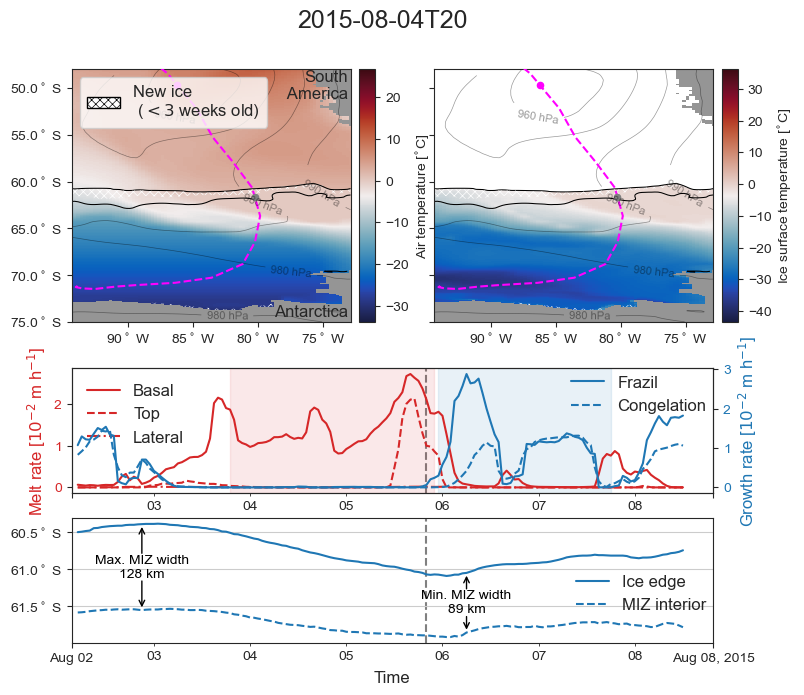

In [66]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.font_manager as fm
from matplotlib.patches import Rectangle
from matplotlib import animation
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches

def latitude_formatter(x, pos):
    return f'{abs(x):.1f}$^\circ$ {"S" if x < 0 else "N"}'

def longitude_formatter(x, pos):
    return f'{abs(x):.0f}$^\circ$ {"W" if x < 0 else "E"}'

# Processing datasets
df_single_track['date'] = pd.to_datetime(df_single_track['date'])
ds['miz_width_100'] = (ds['HTE'].where(ds['aice'] > 0.15).where(ds['fsdrad'] < 100)).sum(dim='nj')
ds['time'] = pd.to_datetime(ds['time'])
ds['speed'] = np.sqrt(ds['uvel']**2 + ds['vvel']**2)
ds['vvel_100'] = (ds['vvel'].where(ds['aice'] > 0.15).where(ds['fsdrad'] < 100)).mean(dim='nj')
ds['vatm_100'] = (ds['vatm'].where(ds['aice'] > 0.15).where(ds['fsdrad'] < 100)).mean(dim='nj')
ds['dTairdt'] = ds['Tair'].diff(dim='time', n=1)
ds['dTsfcdt'] = ds['Tsfc'].diff(dim='time', n=1)
ds['diagedt'] = ds['iage'].diff(dim='time', n=1)

land_mask = np.isnan(ds['aice'].isel(time=0))

# Plot setup function
def setUpPlot(ax_tmp, ds, time_idx):
    pc = ax_tmp.pcolormesh(ds.TLON, ds.TLAT, land_mask.where(land_mask == 1), cmap='Greys',
                           shading='auto', vmin=0, vmax=2, zorder=0)
    pc.set_rasterized(True)

    contour = ax_tmp.contour(ds.TLON, ds.TLAT, ds['psl'].isel(time=time_idx)/100,
                              levels=np.arange(850, 1100, 10), colors='k', linewidths=0.5, alpha=0.4)
    ax_tmp.clabel(contour, inline=1, fontsize=8, fmt='%1.0f hPa', inline_spacing=5, rightside_up=True)

    ax_tmp.contour(ds.TLON, ds.TLAT, ds['aice'].isel(time=time_idx), levels=[0.15], colors='k', linewidths=0.75)
    ax_tmp.contour(ds.TLON, ds.TLAT, ds['fsdrad'].isel(time=time_idx), levels=[100], colors='k', linewidths=0.75)

    tmp_time = ds['time'].isel(time=time_idx)
    ax_tmp.plot(xarrayTrack['longitude'], xarrayTrack['latitude'], label='Cyclone', color=CYCLONE_TRACK_COLOR, linestyle='--', zorder=3)
    
    ax_tmp.scatter(xarrayTrack['longitude'].sel(time=crossing_time),
                   xarrayTrack['latitude'].sel(time=crossing_time),
                   label='Cyclone', color='gray', s=20, zorder=3)

    ax_tmp.scatter(xarrayTrack['longitude'].sel(time=tmp_time),
                   xarrayTrack['latitude'].sel(time=tmp_time),
                   label='Cyclone', color=CYCLONE_TRACK_COLOR, s=20, zorder=3)



    ax_tmp.contourf(ds.TLON, ds.TLAT, ds['iage'].where(ds['aice'] > 0.15).isel(time=time_idx),
                    levels=[0, 3/52], hatches=['xxxx'], colors='none', zorder=2)

    ax_tmp.set(ylim=(-75, -48))
    ax_tmp.set_title(f'Time: {tmp_time.dt.strftime("%Y-%m-%d %H:%M").values}')
    return ax_tmp

# Constants
CYCLONE_TRACK_COLOR = 'magenta'

# Frame setup
mid_point_idx = np.argmin(abs(ds.time.values - crossing_time))
frame_indices = np.arange(mid_point_idx - 24, mid_point_idx + 25)
# ------------------------------------------------------------------------------
# Create figure and axis
fig, axes = plt.subplots(3, 2, figsize=(width*1.25, height*1.5), gridspec_kw={'height_ratios': [1.5, 0.75, 0.75]})
fig.subplots_adjust(wspace=0.3)
# ------------------------------------------------------------------------------
colorbar_axes = []

# Update function for animation
def update(frame_idx):
    global colorbar_axes
    for cax in colorbar_axes:
        cax.remove()
    colorbar_axes = []
    
    axes[0,0].clear()
    axes[0,1].clear()
    time_idx = frame_idx
    time_difference = abs(pd.to_datetime(df_single_track['date']) - ds.time.isel(time=time_idx).values)
    min_track_idx = time_difference.argmin()
   

    axes[1, 0].axis('off')
    axes[1, 1].axis('off')
    axes[2, 0].axis('off')
    axes[2, 1].axis('off')


    ax1 = axes[0,0]
    ax2 = axes[0,1]
    setUpPlot(ax1, ds, time_idx)
    setUpPlot(ax2, ds, time_idx)


    hatch_patch = mpatches.Patch(
                facecolor='white',  # or 'none', depending on your background
                hatch='xxxx',
                edgecolor='black',
                label='New ice\n ($< 3$ weeks old)'
                )

    # Add the legend
    ax1.legend(handles=[hatch_patch], loc='upper left')  # Adjust loc as needed
    
    # Plot ice concentration (First pcolormesh - Vorticity)
    vmax = abs(ds['Tair']).max().values
    vmin = -vmax
    vmin -= 1.8*2
    vmax -= 1.8*2
    pcol1 = ax1.pcolormesh(ds.TLON, ds.TLAT, ds['Tair'].isel(time=time_idx),
                          cmap=cmo.balance, vmin=vmin, vmax=vmax, shading='auto', zorder=0)
    pcol1.set_rasterized(True)


    # Add title
    time_str = pd.to_datetime(ds.time.isel(time=time_idx).values).strftime('%Y-%m-%dT%H')
    fig.suptitle(time_str, fontsize=18, y=0.96)

    ax1.set(xlim=(ds.TLON.min().values, ds.TLON.max().values))



    vmax = abs(ds['Tsfc']).max() 
    vmin = -vmax
    vmin -= 1.8*2
    vmax -= 1.8*2
    pcol2 = ax2.pcolormesh(ds.TLON, ds.TLAT, ds['Tsfc'].isel(time=time_idx).where(ds['aice'].isel(time=time_idx) > 0.15),
                          cmap=cmo.balance, vmin=vmin, vmax=vmax, shading='auto', zorder=0)
    pcol2.set_rasterized(True)
    time_str = pd.to_datetime(ds.time.isel(time=time_idx).values).strftime('%Y-%m-%dT%H')

    ax2.set(xlim=(ds.TLON.min().values, ds.TLON.max().values))

    ax1.yaxis.set_major_formatter(mticker.FuncFormatter(latitude_formatter))
    ax2.yaxis.set_major_formatter('')
    
    ax1.xaxis.set_major_formatter(mticker.FuncFormatter(longitude_formatter))
    ax2.xaxis.set_major_formatter(mticker.FuncFormatter(longitude_formatter))

    # Add colorbar
    cbar_width = 0.02
    cbar_gap = 0.01  # small gap between axis and colorbar
    
    pos1 = ax1.get_position()
    pos2 = ax2.get_position()
    
    # Colorbar for ax on right side
    cbar_ax1 = fig.add_axes([pos1.x1 + cbar_gap, pos1.y0, cbar_width, pos1.height])
    cbar1 = fig.colorbar(pcol1, cax=cbar_ax1, extend=None)
    cbar1.set_label('Air temperature [$^{\circ}$C]', fontsize=10)
    cbar1.ax.yaxis.set_label_position('right')
    cbar1.ax.yaxis.set_ticks_position('right')
    colorbar_axes.append(cbar_ax1)
    
    # Colorbar for ax2 on right side
    cbar_ax2 = fig.add_axes([pos2.x1 + cbar_gap, pos2.y0, cbar_width, pos2.height])
    cbar2 = fig.colorbar(pcol2, cax=cbar_ax2, extend=None)
    cbar2.set_label('Ice surface temperature [$^{\circ}$C]', fontsize=10)
    cbar2.ax.yaxis.set_label_position('right')
    cbar2.ax.yaxis.set_ticks_position('right')
    colorbar_axes.append(cbar_ax2)
    
    ax1.text(1 - 0.01, 0.01, 'Antarctica', 
        transform=ax1.transAxes, 
        fontsize=fontsize, 
        verticalalignment='bottom', 
        horizontalalignment='right',
        zorder=3)

    ax1.text(1 - 0.01, 1, 'South\n America', 
            transform=ax1.transAxes, 
            fontsize=fontsize, 
            verticalalignment='top', 
            horizontalalignment='right',
            zorder=3)

    for ax in axes.flat:
        ax.set_title('')
        
    return axes,

# ------------------------------------------------------------------------------

ds_area = xr.open_dataset(f'{netcdfpath}area/{track_number}_area.nc').isel(radius=3)
ds_edge = xr.open_dataset(f'{netcdfpath}ice-edge/{track_number}_ice_edge.nc').isel(radius=3)


# Middle plot
ax_middle = fig.add_subplot(413)
ax_twin_middle = ax_middle.twinx()

color1 = 'tab:red'
ax_middle.plot(ds_area['time'], ds_area['meltb_miz'], color=color1, label='Basal')
ax_middle.plot(ds_area['time'], ds_area['meltt_miz'], color=color1, linestyle='--', label='Top')
ax_middle.plot(ds_area['time'], ds_area['meltl_miz'], color=color1, linestyle='-.', label='Lateral')
ax_middle.set_ylabel('Melt rate [$10^{-2}$ m h$^{-1}$]', color=color1)  # Label for the bottom axis
ax_middle.set_xlabel('')  # Label for the shared x-axis
ax_middle.tick_params(axis='y', labelcolor=color1)  # Set the y-ticks color for the bottom axis


color2 = 'tab:blue'
ax_twin_middle.plot(ds_area['time'], ds_area['frazil_miz'], color=color2, linestyle='-', label='Frazil')
ax_twin_middle.plot(ds_area['time'], ds_area['congel_miz'], color=color2, linestyle='--', label='Congelation')
ax_twin_middle.set_ylabel('Growth rate [$10^{-2}$ m h$^{-1}$]', color=color2)
ax_twin_middle.tick_params(axis='y', labelcolor=color2) 


ax_twin_middle.grid(False)
ax_middle.legend(loc="upper left", fancybox=False, framealpha=0, facecolor=None, edgecolor=None)
ax_twin_middle.legend(loc="upper right", fancybox=False, framealpha=0, facecolor=None, edgecolor=None, bbox_to_anchor=(1.0, 1.0), borderaxespad=0.)


# BOTTOM PLOT
ax_bottom = fig.add_subplot(414)
# ax_twin = ax_bottom.twinx()

color1 = 'tab:blue'
ax_bottom.plot(ds_edge['time'], ds_edge['ice_edge'], color=color1, label='Ice edge')
ax_bottom.plot(ds_edge['time'], ds_edge['ice_edge'] -  ds_edge['miz_width']/110, color=color1, linestyle='--', label='MIZ interior')
ax_bottom.legend(loc='upper right', bbox_to_anchor=(1.0, 0.6), borderaxespad=0., fancybox=False, framealpha=0, facecolor=None, edgecolor=None)
ax_bottom.yaxis.set_major_formatter(mticker.FuncFormatter(latitude_formatter))
ax_bottom.set_xlabel('')  # Label for the shared x-axis


# ANNOTATIONS
tmp_idx = ds_edge['miz_width'].argmin()
x_coord = ds_edge['time'][tmp_idx]
y_coord_center = (ds_edge['ice_edge'][tmp_idx] + ds_edge['ice_edge'][tmp_idx] - ds_edge['miz_width'][tmp_idx]/110) / 2
y_coord_top = ds_edge['ice_edge'][tmp_idx]
y_coord_bottom = ds_edge['ice_edge'][tmp_idx] - ds_edge['miz_width'][tmp_idx]/110

ax_bottom.text(
    x_coord, y_coord_center, f"Min. MIZ width\n{ds_edge['miz_width'][tmp_idx]:.0f} km",
    fontsize=plot_settings.fontsize-2, verticalalignment='center',
    horizontalalignment='center', rotation=0, color='black',
)
ax_bottom.annotate(
    '', xy=(x_coord, y_coord_top), xytext=(x_coord, y_coord_center+0.15),
    arrowprops=dict(arrowstyle='->', color='black', lw=1.0)
)
ax_bottom.annotate(
    '', xy=(x_coord, y_coord_bottom), xytext=(x_coord, y_coord_center-0.15),
    arrowprops=dict(arrowstyle='->', color='black', lw=1.0)
)

# Calculate indices and positions
tmp_idx = ds_edge['miz_width'].argmax()
x_coord = ds_edge['time'][tmp_idx]
y_coord_center = (ds_edge['ice_edge'][tmp_idx] + ds_edge['ice_edge'][tmp_idx] - ds_edge['miz_width'][tmp_idx]/110) / 2
y_coord_top = ds_edge['ice_edge'][tmp_idx]
y_coord_bottom = ds_edge['ice_edge'][tmp_idx] - ds_edge['miz_width'][tmp_idx]/110

ax_bottom.text(
    x_coord, y_coord_center, f"Max. MIZ width\n{ds_edge['miz_width'][tmp_idx]:.0f} km",
    fontsize=plot_settings.fontsize-2, verticalalignment='center',
    horizontalalignment='center', rotation=0, color='black',
)
ax_bottom.annotate(
    '', xy=(x_coord, y_coord_top), xytext=(x_coord, y_coord_center+0.15),
    arrowprops=dict(arrowstyle='->', color='black', lw=1.0)
)
ax_bottom.annotate(
    '', xy=(x_coord, y_coord_bottom), xytext=(x_coord, y_coord_center-0.15),
    arrowprops=dict(arrowstyle='->', color='black', lw=1.0)
)
ax_bottom.set_xlabel('Time')
ax_bottom.set_xlim(ds.time[0], ds.time[-1])
ax_bottom.grid(True)
ax_middle.axvline(pd.to_datetime(ds['time'].sel(time=crossing_time).values), color='gray', zorder=0, linestyle='--')
ax_bottom.axvline(pd.to_datetime(ds['time'].sel(time=crossing_time).values), color='gray', zorder=0, linestyle='--')


# Set xticks to monthly intervals and format the datetime labels
start_date, end_date = ax_middle.get_xlim()
new_start_date = mdates.num2date(start_date) + pd.Timedelta(hours=6)
ax_middle.set_xlim(new_start_date, end_date)
ax_middle.xaxis.set_major_locator(mdates.MonthLocator())
ax_middle.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax_middle.xaxis.set_minor_locator(mdates.DayLocator())
ax_middle.xaxis.set_minor_formatter(mdates.DateFormatter('%d'))#

# Custom formatter to append the year to the last tick
def custom_date_formatter(x, pos):
    if pos == len(ax_middle.get_xticks()) - 1:  # Last tick
        return mdates.num2date(x).strftime('%b %d, %Y')  # Add year
    else:
        return mdates.num2date(x).strftime('%b %d')  # No year for other ticks

ax_middle.xaxis.set_major_formatter(plt.FuncFormatter(custom_date_formatter))
ax_middle.set_ylim(ax_middle.get_ylim())
ax_bottom.set_ylim(ax_bottom.get_ylim())

# Freezing 
ds_tmp = ds_edge.isel(time=slice(crossing_idx-48, crossing_idx+48))
event = (ds_tmp['Tsfc'])
event_idx = event < -1.8
events_array = getEachBreakupIdx(event_idx)
if events_array:
    major_events_array = getMajorEvents(events_array, time_threshold=6)
    if major_events_array:
         for i_event in range(np.shape(major_events_array)[0]):
            event_flag_tmp = major_events_array[i_event]
            event_flag_tmp = major_events_array[i_event]
            time_values = ds_tmp['time'].values[event_flag_tmp]
            start_time = time_values[0]
            end_time = time_values[-1]
            ylim = ax_middle.get_ylim()
            y_values = np.linspace(ylim[0], ylim[1], len(time_values))
            xlim = ax_bottom.get_xlim()
            ax_middle.fill_betweenx(y_values, start_time, end_time, color='tab:blue', alpha=0.1, zorder=0)
            # ax_middle.fill_betweenx(y_values, xlim[0], xlim[1], color='tab:blue', alpha=0.1, zorder=0)


# Melting 
event = (ds_tmp['Tsfc'])
event_idx = event > -1.8
events_array = getEachBreakupIdx(event_idx)
if events_array:
    major_events_array = getMajorEvents(events_array, time_threshold=6)
    if major_events_array:
         for i_event in range(np.shape(major_events_array)[0]):
            event_flag_tmp = major_events_array[i_event]
            event_flag_tmp = major_events_array[i_event]
            time_values = ds_tmp['time'].values[event_flag_tmp]
            start_time = time_values[0]
            end_time = time_values[-1]
            ylim = ax_middle.get_ylim()
            y_values = np.linspace(ylim[0], ylim[1], len(time_values))
            ax_middle.fill_betweenx(y_values, start_time, end_time, color='tab:red', alpha=0.1, zorder=0)


# Set xticks to monthly intervals and format the datetime labels
ax_bottom.set_xlim(new_start_date, end_date)
ax_bottom.xaxis.set_major_locator(mdates.MonthLocator())
ax_bottom.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax_bottom.xaxis.set_minor_locator(mdates.DayLocator())
ax_bottom.xaxis.set_minor_formatter(mdates.DateFormatter('%d'))#

# Custom formatter to append the year to the last tick
def custom_date_formatter(x, pos):
    if pos == len(ax_middle.get_xticks()) - 1:  # Last tick
        return mdates.num2date(x).strftime('%b %d, %Y')  # Add year
    else:
        return mdates.num2date(x).strftime('%b %d')  # No year for other ticks

ax_bottom.xaxis.set_major_formatter(plt.FuncFormatter(custom_date_formatter))

ax_middle.set_xticklabels([])
ax_twin_middle.set_xticklabels([])
# ------------------------------------------------------------------------------




# Create and save animation
ani = animation.FuncAnimation(fig, update, frames=frame_indices, blit=False, interval=200)
ani.save(os.path.join(savepath, "gif/thermodynamics/cyclone_animation.mp4"), writer="ffmpeg", dpi=200)

# from matplotlib.animation import PillowWriter
# gif_path = os.path.join(savepath, "gif/thermodynamics/cyclone_animation.gif")
# ani.save(gif_path, writer=PillowWriter(fps=5), dpi=150)

## Case Study 2: Sea ice drift

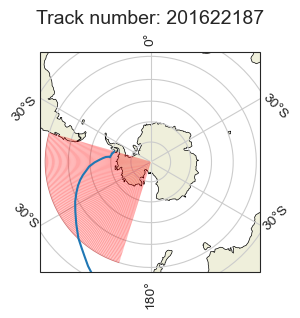

<xarray.Dataset> Size: 13kB
Dimensions:                        (time: 175)
Coordinates:
  * time                           (time) datetime64[ns] 1kB 2016-08-01T17:00...
Data variables:
    central_pressure               (time) float64 1kB nan 1.006e+03 ... 962.5
    longitude                      (time) float64 1kB nan -162.5 ... -74.18
    latitude                       (time) float64 1kB nan -25.94 ... -70.95
    laplacian_of_central_pressure  (time) float64 1kB nan 0.851 ... 0.936 0.9
    cyclone_depth                  (time) float64 1kB nan 2.462 ... 6.756 6.474
    cyclone_radius                 (time) float64 1kB nan 3.995 ... 4.408 4.38
    eastward_steering_velocity     (time) float64 1kB nan 1.754 ... 0.189 0.1375
    northward_steering_velocity    (time) float64 1kB nan -1.151 ... 3.505 3.71

In [7]:
track_number =  201622187 
df_single_track, ds, cice_output_file = read_in_track(track_number)
plotSectorMap(df_single_track, savepath, npoints=100, fixed_lat=-40)

xarrayTrack = makeCycloneTrackDataset(df_single_track, ds)
crossing_time, crossing_idx, distance_deg = getCrossingTime(ds, xarrayTrack)

xarrayTrack

In [12]:
def addVorticityDivergence(ds_cice):
    ds_cice['vort'] = ds_cice['uvel'].copy()
    ds_cice['vortatm'] = ds_cice['uvel'].copy()
    ds_cice['div'] = ds_cice['uvel'].copy()
    ds_cice['divatm'] = ds_cice['uvel'].copy()
    
    ds_cice['vort'].attrs['units'] = '1/s'
    ds_cice['vort'].attrs['long_name'] = 'Relative sea ice vorticity'
    ds_cice['vortatm'].attrs['units'] = '1/s'
    ds_cice['vortatm'].attrs['long_name'] = 'Relative wind vorticity'
    
    ds_cice['div'].attrs['units'] = '1/s'
    ds_cice['div'].attrs['long_name'] = 'Sea ice divergence'
    ds_cice['divatm'].attrs['units'] = '1/s'
    ds_cice['divatm'].attrs['long_name'] = 'Wind divergence'
    
    ds_temp = ds_cice.rename_dims({"nj": "Y", "ni": "X"})
    dx, dy = mpcalc.lat_lon_grid_deltas(ds_temp.TLON, ds_temp.TLAT)
    
    vort = np.empty(ds_cice.uvel.values.shape)
    vortatm = np.empty(ds_cice.uvel.values.shape)
    div = np.empty(ds_cice.uvel.values.shape)
    divatm = np.empty(ds_cice.uvel.values.shape)
    i = 0
    for time in ds_temp.time:
        temp_uvel = ds_temp.uvel.drop_vars(['ULAT', 'ULON']).sel(time=time)
        temp_vvel = ds_temp.vvel.drop_vars(['ULAT', 'ULON']).sel(time=time)
        vort[i,:,:] = mpcalc.vorticity(temp_uvel, temp_vvel, dx=dx, dy=dy)
        
        temp_uatm = ds_temp.uatm.drop_vars(['ULAT', 'ULON']).sel(time=time)
        temp_vatm = ds_temp.vatm.drop_vars(['ULAT', 'ULON']).sel(time=time)
        vortatm[i,:,:] = mpcalc.vorticity(temp_uatm, temp_vatm, dx=dx, dy=dy)

        div[i,:,:] = mpcalc.divergence(temp_uvel, temp_vvel, dx=dx, dy=dy)
        divatm[i,:,:] = mpcalc.divergence(temp_uatm, temp_vatm, dx=dx, dy=dy)
        
        i += 1
    
    ds_cice['vort'][:,:,:] = vort
    ds_cice['vortatm'][:,:,:] = vortatm
    ds_cice['div'][:,:,:] = div
    ds_cice['divatm'][:,:,:] = divatm
    return ds_cice

ds = addVorticityDivergence(ds)
ds

<xarray.Dataset> Size: 12GB
Dimensions:           (time: 175, nj: 324, ni: 313, nc: 5, nf: 12, nkaer: 5,
                       d2: 2, lon: 414, lat: 324)
Coordinates:
  * time              (time) datetime64[ns] 1kB 2016-08-01T17:00:00 ... 2016-...
    NCAT              (nc) float32 20B ...
    NFSD              (nf) float32 48B ...
    TLAT              (nj, ni) float32 406kB -81.08 -81.08 ... -39.93 -39.93
    TLON              (nj, ni) float32 406kB -144.9 -144.6 ... -67.12 -66.88
    ULAT              (nj, ni) float32 406kB -81.02 -81.02 ... -39.84 -39.84
    ULON              (nj, ni) float32 406kB -144.8 -144.5 ... -67.0 -66.75
  * lon               (lon) float32 2kB 190.1 190.4 190.6 ... 292.9 293.1 293.4
  * lat               (lat) float32 1kB -81.08 -80.97 -80.87 ... -40.13 -39.93
Dimensions without coordinates: nj, ni, nc, nf, nkaer, d2
Data variables: (12/54)
    HTE               (time, nj, ni) float32 71MB ...
    HTN               (time, nj, ni) float32 71MB ...
    Tair              (time, nj, ni) float32 71MB ...
    Tsfc              (time, nj, ni) float32 71MB ...
    VGRDa             (time, nkaer) float32 4kB ...
    afsd              (time, nf, nj, ni) float32 852MB ...
    ...                ...
    vortatm           (time, nj, ni) float32 71MB nan nan nan ... nan nan nan
    div               (time, nj, ni) float32 71MB nan nan nan ... nan nan nan
    divatm            (time, nj, ni) float32 71MB nan nan nan ... nan nan nan
    miz_width_100     (time, ni) float32 219kB 7.117e+04 7.09e+04 ... 2.601e+05
    vvel_100          (time, ni) float32 219kB 0.1579 0.1425 ... 0.09488 0.08963
    vatm_100          (time, ni) float32 219kB 9.446 9.491 ... -0.2478 -0.6388
Attributes:
    title:        sea ice model output for CICE
    contents:     Diagnostic and Prognostic Variables
    source:       Los Alamos Sea Ice Model, CICE_6.2.0
    comment:      This year has 366 days
    comment2:     File written on model date 20160801
    comment3:     seconds elapsed into model date:  64800
    conventions:  CF-1.0
    history:      Fri Dec 29 12:56:57 2023: ncks -d nj,0,323 -O /g/data/ia40/...
    io_flavor:    io_netcdf
    NCO:          netCDF Operators version 5.1.4 (Homepage = http://nco.sf.ne...

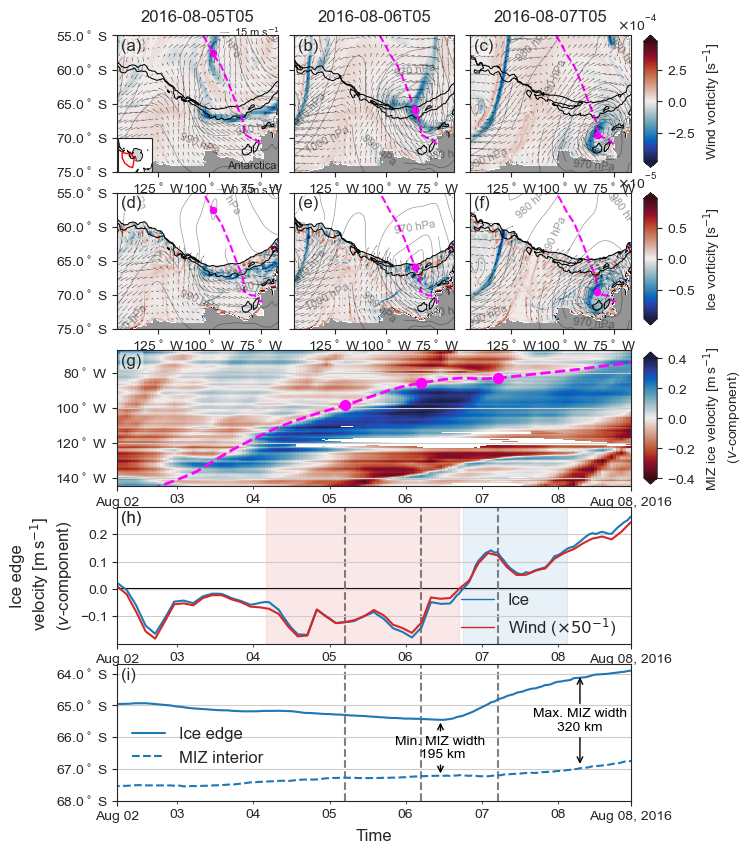

In [18]:
df_single_track['date'] = pd.to_datetime(df_single_track['date'])
ds['miz_width_100']  = (ds['HTE'].where(ds['aice']>0.15).where(ds['fsdrad']<100)).sum(dim='nj')
ds['time'] = pd.to_datetime(ds['time'])
ds['speed'] = np.sqrt(ds['uvel']**2 + ds['vvel']**2)
ds['vvel_100']  = (ds['vvel'].where(ds['aice']>0.15).where(ds['fsdrad']<100)).mean(dim='nj')
ds['vatm_100']  = (ds['vatm'].where(ds['aice']>0.15).where(ds['fsdrad']<100)).mean(dim='nj')
mpl.rcParams['hatch.linewidth'] = 0.5

land_mask = np.isnan(ds['aice'].isel(time=0))

def setUpPlot(ax_tmp, ds):
    # Land mask
    pc = ax_tmp.pcolormesh(ds.TLON, ds.TLAT, land_mask.where(land_mask == 1), cmap='Greys', shading='auto', vmin=0, vmax=2, zorder=0)
    # Add a black border around the land areas using contour
    pc.set_rasterized(True)

    # Plot pressure contours
    contour = ax_tmp.contour(ds.TLON, ds.TLAT, ds['psl'].isel(time=time_idx)/100,
                         levels=np.arange(850, 1100, 10), colors='k', linewidths=0.5, alpha=0.4)
    ax_tmp.clabel(contour, inline=1, fontsize=8, fmt='%1.0f hPa', inline_spacing=5, rightside_up=True)

    ax_tmp.contour(ds.TLON, ds.TLAT, ds['aice'].isel(time=time_idx), levels=[0.15], colors='k', linewidths=0.75)
    ax_tmp.contour(ds.TLON, ds.TLAT, ds['fsdrad'].isel(time=time_idx), levels=[100], colors='k', linewidths=0.75)
    ax_tmp.plot(xarrayTrack['longitude'], xarrayTrack['latitude'], label='Cyclone', color=CYCLONE_TRACK_COLOR, linestyle='--', 
                zorder=2)
    tmp_time = ds['time'].isel(time=time_idx)
    ax_tmp.scatter(xarrayTrack['longitude'].sel(time=tmp_time), xarrayTrack['latitude'].sel(time=tmp_time), 
               label='Cyclone', color=CYCLONE_TRACK_COLOR, s=20, zorder=2)

    ax_tmp.set(ylim=(-75, -55))
    return ax_tmp

# Constants
CYCLONE_TRACK_COLOR = 'magenta'

mid_point_idx = np.argmin(abs(ds.time.values - crossing_time))
time_indices = [mid_point_idx-24, mid_point_idx, mid_point_idx+24]

# Create a 2-row grid: first row for the 3 subplots (vorticity), second row for divergence
fig, axs = plt.subplots(5, 3, figsize=[width, (4/2)*height], sharex=False, gridspec_kw={'height_ratios': [1, 1, 1, 1, 1]})

# Loop through the time indices and plot each subplot
for i, time_idx in enumerate(time_indices):
    ax = axs[0, i]  # Get the current axis for the top row (vorticity)
    
    time_difference = abs(pd.to_datetime(df_single_track['date']) - ds.time.isel(time=time_idx).values)
    min_track_idx = time_difference.argmin()
    
    ax = setUpPlot(ax, ds)
    

    # Plot ice concentration (First pcolormesh - Vorticity)
    vmax = abs(ds.vortatm).max().values*0.8
    vmin = -vmax
    pcol1 = ax.pcolormesh(ds.TLON, ds.TLAT, ds['vortatm'].isel(time=time_idx),
                          cmap=cmo.balance, vmin=vmin, vmax=vmax, shading='auto', zorder=0)
    pcol1.set_rasterized(True)


    # Optional: Add title for each subplot
    time_str = pd.to_datetime(ds.time.isel(time=time_idx).values).strftime('%Y-%m-%dT%H')
    ax.set_title(time_str, fontsize=fontsize, pad=10)
    ax.text(label_x, label_y, f'({chr(97 + i)})', 
        transform=ax.transAxes, 
        fontsize=fontsize, 
        verticalalignment='top', 
        horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.1'),
        zorder=5)

    ax.set(xlim=(ds.TLON.min().values, ds.TLON.max().values))

    # Quiver plot for uvel and vvel (velocity components)
    uvel = ds['uatm'].isel(time=time_idx)
    vvel = ds['vatm'].isel(time=time_idx)
    
    stride = 10
    q = ax.quiver(ds.TLON[::stride, ::stride], ds.TLAT[::stride, ::stride], 
              uvel[::stride, ::stride], vvel[::stride, ::stride], 
              scale=250, color='k', alpha=0.7, zorder=2)
    

    # AXIS2: Ice vorticity
    ax2 = axs[1, i]  # Get the current axis for the top row (vorticity)
    
    time_difference = abs(pd.to_datetime(df_single_track['date']) - ds.time.isel(time=time_idx).values)
    min_track_idx = time_difference.argmin()
    
    ax2 = setUpPlot(ax2, ds)
    

    # Plot ice concentration (First pcolormesh - Vorticity)
    vmax = abs(ds.vort).max().values*0.25
    vmin = -vmax
    pcol2 = ax2.pcolormesh(ds.TLON, ds.TLAT, ds['vort'].isel(time=time_idx).where(ds['aice'].isel(time=time_idx) > 0.15),
                          cmap=cmo.balance, vmin=vmin, vmax=vmax, shading='auto', zorder=0)
    pcol2.set_rasterized(True)

    time_str = pd.to_datetime(ds.time.isel(time=time_idx).values).strftime('%Y-%m-%dT%H')
    ax2.text(label_x, label_y, f'({chr(97 + i + 3)})', 
        transform=ax2.transAxes, 
        fontsize=fontsize, 
        verticalalignment='top', 
        horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.1'),
        zorder=5)

    # Quiver plot for uvel and vvel (velocity components)
    uvel = ds['uvel'].where(ds['aice']>0.01).isel(time=time_idx)
    vvel = ds['vvel'].where(ds['aice']>0.01).isel(time=time_idx)
    
    stride = 10
    q2 = ax2.quiver(ds.TLON[::stride, ::stride], ds.TLAT[::stride, ::stride], 
              uvel[::stride, ::stride], vvel[::stride, ::stride], 
              scale=5, color='k', alpha=0.7, zorder=2)

    ax2.set(xlim=(ds.TLON.min().values, ds.TLON.max().values))

    if i != 0:
        ax.set_yticklabels([])
        ax2.set_yticklabels([])
    else:
        # Set common labels for the top plots (Vorticity)
        # ax.set_ylabel('Latitude')
        # ax2.set_ylabel('Latitude')
        ax.yaxis.set_major_formatter(mticker.FuncFormatter(latitude_formatter))
        ax2.yaxis.set_major_formatter(mticker.FuncFormatter(latitude_formatter))
        ax.quiverkey(q, X=0.7, Y=1.027, U=15, label='15 m s$^{-1}$', labelpos='E', labelsep=0.05, fontproperties={'size': 8})
        ax2.quiverkey(q2, X=0.68, Y=1.025, U=0.3, label='0.3 m s$^{-1}$', labelpos='E', labelsep=0.05, fontproperties={'size': 8})

    ax.xaxis.set_major_formatter(mticker.FuncFormatter(longitude_formatter))
    ax2.xaxis.set_major_formatter(mticker.FuncFormatter(longitude_formatter))
        

# Create a new axis for the pcolormesh panel spanning the entire width of the figure (using fig.add_subplot)
ax_middle = fig.add_subplot(513)
pcol_middle = ax_middle.pcolormesh(ds['time'], ds['TLON'].mean(dim='nj'), (ds['vvel_100']).transpose(),
                                   vmin=-0.4, vmax=0.4, cmap=cmo.balance_r, shading='auto', zorder=0)
pcol_middle.set_rasterized(True)
ax_middle.plot(pd.to_datetime(xarrayTrack['time']), xarrayTrack['longitude'], color=CYCLONE_TRACK_COLOR, 
               linewidth=2, linestyle='--')

for i, time_idx in enumerate(time_indices):
    tmp_time = ds['time'].isel(time=time_idx)
    ax_middle.scatter(xarrayTrack['time'].sel(time=tmp_time), xarrayTrack['longitude'].sel(time=tmp_time), 
               label='Cyclone', color=CYCLONE_TRACK_COLOR, s=50)


# Hide the axes in the bottom row (those created in axs[1, :], which are not needed now)
axs[2, 0].axis('off')
axs[2, 1].axis('off')
axs[2, 2].axis('off')
axs[3, 0].axis('off')
axs[3, 1].axis('off')
axs[3, 2].axis('off')
axs[4, 0].axis('off')
axs[4, 1].axis('off')
axs[4, 2].axis('off')

# Get the position of each axis to align colorbars accordingly
pos1 = axs[0, 2].get_position()  # Position of first axis (top row)
pos2 = axs[1, 2].get_position()  # Position of second axis (middle row)
pos3 = ax_middle.get_position()   # Position of the manually added middle axis

# Adjust layout and space for colorbars and white space between plots
fig.subplots_adjust(right=0.9, hspace=0.15, wspace=0.1)  # Adjust hspace for vertical space, wspace for horizontal
cbar_width = 0.02  # Width of the colorbar

# Create colorbar for vorticity (aligned with top row)
cbar_ax1 = fig.add_axes([0.92, pos1.y0, cbar_width, pos1.height])  # Align with axs[0, 2]
cbar1 = fig.colorbar(pcol1, cax=cbar_ax1, extend='both')
cbar1.set_label('Wind vorticity [s$^{-1}$]', fontsize=10)

# Create colorbar for ice vorticity (aligned with middle row)
cbar_ax2 = fig.add_axes([0.92, pos2.y0+0.001, cbar_width, pos2.height])  # Align with axs[1, 2]
cbar2 = fig.colorbar(pcol2, cax=cbar_ax2, extend='both')
cbar2.set_label('Ice vorticity [s$^{-1}$]', fontsize=10)

# Create colorbar for MIZ ice velocity (aligned with middle plot)
cbar_ax3 = fig.add_axes([0.92, pos3.y0, cbar_width, pos3.height])  # Align with ax_middle
cbar3 = fig.colorbar(pcol_middle, cax=cbar_ax3, extend='both')
cbar3.set_label('MIZ ice velocity [m$\,$s$^{-1}$]\n ($v$-component)', fontsize=10)


# Add the inset map for Antarctica
pos1 = axs[0, 0].get_position() 
inset_ax = fig.add_axes([pos1.x0-0.0035, pos1.y0-0.00, pos1.width/4, pos1.height/4], projection=ccrs.SouthPolarStereo())  # Adjust position and size of inset
inset_ax.set_extent([-180, 180, -90, -40], crs=ccrs.PlateCarree())  # Set the extent to focus on Antarctica
# Add Antarctica to the inset map
inset_ax.add_feature(cfeature.LAND, color='lightgray')
inset_ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
highlighted_area = Rectangle((190, ds.TLAT.min().values), 90, 30,
                 linewidth=1, edgecolor='red', facecolor='none', zorder=3, transform=ccrs.PlateCarree())
inset_ax.add_patch(highlighted_area)

axs[0,0].text(1 - 0.01, 0.01, 'Antarctica', 
        transform=axs[0,0].transAxes, 
        fontsize=fontsize-4, 
        verticalalignment='bottom', 
        horizontalalignment='right',
        zorder=3)

# Apply the formatter to each colorbar
cbar1.ax.yaxis.set_major_formatter(formatter)
cbar2.ax.yaxis.set_major_formatter(formatter)
cbar3.ax.yaxis.set_major_formatter(formatter)

# AX
ax_middle.set(ylim=(ds.TLON.min().values, ds.TLON.max().values), #ylabel='Longitude'
             )
ax_middle.text(label_x/3, label_y, f'({chr(97 + i+4)})', 
        transform=ax_middle.transAxes, 
        fontsize=fontsize, 
        verticalalignment='top', 
        horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.1'),
        zorder=5)
ax_middle.grid(True)
ax_middle.yaxis.set_major_formatter(mticker.FuncFormatter(longitude_formatter))


# Bottom plot
ax_bottom = fig.add_subplot(514)
ds_area = xr.open_dataset(f'{netcdfpath}area/{track_number}_area.nc').isel(radius=2)
ds_edge = xr.open_dataset(f'{netcdfpath}ice-edge/{track_number}_ice_edge.nc').isel(radius=2)
# Create a twin y-axis
color1 = 'tab:blue'
color2 = 'tab:red'

# ax_bottom.plot(ds_area['time'], ds_area['uvel_miz'], color=color1, label='Ice')  # Add label here
# ax_bottom.plot(ds_area['time'], ds_area['uatm_miz']/50, color=color1, linestyle='--', label='Wind ($\\times 50^{-1}$)')
ax_bottom.plot(ds_area['time'], ds_edge['vvel'], color=color1, label='Ice')  # Add label here
ax_bottom.plot(ds_area['time'], ds_edge['vatm']/50, color=color2, linestyle='-', label='Wind ($\\times 50^{-1}$)')
ax_bottom.set_ylabel('Ice edge\n velocity [m$\,$s$^{-1}$]\n($v$-component)') 
ax_bottom.set_yticks([-0.1, 0, 0.1, 0.2])
ax_bottom.set_xlim(ds.time[0], ds.time[-1])
# ax_bottom.tick_params(axis='y', labelcolor=color1) 
ax_bottom.text(label_x/3, label_y, f'({chr(97 + i + 5)})', 
        transform=ax_bottom.transAxes, 
        fontsize=fontsize, 
        verticalalignment='top', 
        horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.1'),
        zorder=5)

ax_bottom.grid(True)
ax_bottom.set_ylim(-0.2, 0.3)

line1 = mlines.Line2D([], [], color=color1, label='Ice', linewidth=1)
line2 = mlines.Line2D([], [], color=color2, label='Wind ($\\times 50^{-1}$)', linewidth=1, linestyle='-')

# Create the legend with the custom lines and set the desired properties
ax_bottom.legend(
    handles=[line1, line2],  # Pass the custom lines here
    loc="lower right",  # Relative to axes position
    bbox_transform=ax_bottom.transAxes,  # Transform relative to the axis
    bbox_to_anchor=(1.0, -0.075),
    fancybox=False,
    framealpha=0,
    facecolor=None,  # Legend background color
    edgecolor=None       # Legend frame color
)


# Second bottom plot
ax_bottom2 = fig.add_subplot(515)
ds_area = xr.open_dataset(f'{netcdfpath}area/{track_number}_area.nc').isel(radius=3)
ds_edge = xr.open_dataset(f'{netcdfpath}ice-edge/{track_number}_ice_edge.nc').isel(radius=3)
# Create a twin y-axis
# ax_twin2 = ax_bottom2.twinx()

color1 = 'tab:blue'
ax_bottom2.plot(ds_edge['time'], ds_edge['ice_edge'], color=color1, label='Ice edge')
ax_bottom2.plot(ds_edge['time'], ds_edge['ice_edge'] - ds_edge['miz_width']/111, color=color1, linestyle='--', label='MIZ interior')
ax_bottom2.set_yticks(np.arange(-68, -63.5, 1.0))
ax_bottom2.yaxis.set_major_formatter(mticker.FuncFormatter(latitude_formatter))
ax_bottom2.set_xlabel('Time')

ax_bottom.axhline(0, color='k', zorder=0)
ax_bottom2.set_xlim(ds.time[0], ds.time[-1])
ax_bottom2.text(label_x/3, label_y, f'({chr(97 + i + 5)})', 
        transform=ax_bottom.transAxes, 
        fontsize=fontsize, 
        verticalalignment='top', 
        horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.1'),
        zorder=5)


ax_bottom2.set_xlabel('Time')
ax_bottom2.set_xlim(ds.time[0], ds.time[-1])
ax_bottom2.text(label_x/3, label_y, f'({chr(97 + i + 6)})', 
        transform=ax_bottom2.transAxes, 
        fontsize=fontsize, 
        verticalalignment='top', 
        horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.1'),
        zorder=5)

ax_bottom2.grid(True)

# Set xticks to monthly intervals and format the datetime labels
start_date, end_date = ax_bottom.get_xlim()
new_start_date = mdates.num2date(start_date) + pd.Timedelta(hours=12)
new_end_date = mdates.num2date(end_date) + pd.Timedelta(hours=0)

def custom_date_formatter(x, pos):
    if pos == len(ax_bottom2.get_xticks()) - 1:  # Last tick
        return mdates.num2date(x).strftime('%b %d, %Y')  # Add year
    else:
        return mdates.num2date(x).strftime('%b %d')  # No year for other ticks


for ax in [ax_middle, ax_bottom, ax_bottom2]:
    ax.set_xlim(new_start_date, new_end_date)
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%d'))#
    ax.xaxis.set_major_formatter(plt.FuncFormatter(custom_date_formatter))


for i, time_idx in enumerate(time_indices):
    ax_bottom.axvline(pd.to_datetime(ds['time'].isel(time=time_idx).values), color='gray', zorder=0, linestyle='--')
    ax_bottom2.axvline(pd.to_datetime(ds['time'].isel(time=time_idx).values), color='gray', zorder=0, linestyle='--')

# Expansion 
ds_tmp = ds_edge.isel(time=slice(crossing_idx-48, crossing_idx+48))
event = (ds_tmp['vatm'])
event_idx = event > 0
events_array = getEachBreakupIdx(event_idx)
if events_array:
    major_events_array = getMajorEvents(events_array, time_threshold=6)
    if major_events_array:
         for i_event in range(np.shape(major_events_array)[0]):
            event_flag_tmp = major_events_array[i_event]
            event_flag_tmp = major_events_array[i_event]
            time_values = ds_tmp['time'].values[event_flag_tmp]
            start_time = time_values[0]
            end_time = time_values[-1]
            ylim = ax_bottom.get_ylim()
            y_values = np.linspace(ylim[0], ylim[1], len(time_values))
            ax_bottom.fill_betweenx(y_values, start_time, end_time, color='tab:blue', alpha=0.1, zorder=0)


# Compaction 
event = (ds_tmp['vatm'])
event_idx = event < 0
events_array = getEachBreakupIdx(event_idx)
if events_array:
    major_events_array = getMajorEvents(events_array, time_threshold=6)
    if major_events_array:
         for i_event in range(np.shape(major_events_array)[0]):
            event_flag_tmp = major_events_array[i_event]
            event_flag_tmp = major_events_array[i_event]
            time_values = ds_tmp['time'].values[event_flag_tmp]
            start_time = time_values[0]
            end_time = time_values[-1]
            ylim = ax_bottom.get_ylim()
            y_values = np.linspace(ylim[0], ylim[1], len(time_values))
            ax_bottom.fill_betweenx(y_values, start_time, end_time, color='tab:red', alpha=0.1, zorder=0)



# ANNOTATIONS
tmp_idx = ds_edge['miz_width'].argmin()
x_coord = ds_edge['time'][tmp_idx]
y_coord_center = (ds_edge['ice_edge'][tmp_idx] + ds_edge['ice_edge'][tmp_idx] - ds_edge['miz_width'][tmp_idx]/110) / 2
y_coord_top = ds_edge['ice_edge'][tmp_idx]
y_coord_bottom = ds_edge['ice_edge'][tmp_idx] - ds_edge['miz_width'][tmp_idx]/110


ax_bottom2.text(
    x_coord, y_coord_center, f"Min. MIZ width\n {ds_edge['miz_width'][tmp_idx]:.0f} km",
    fontsize=plot_settings.fontsize-2, verticalalignment='center',
    horizontalalignment='center', rotation=0, color='black',
)
ax_bottom2.annotate(
    '', xy=(x_coord, y_coord_top), xytext=(x_coord, y_coord_center+0.45),
    arrowprops=dict(arrowstyle='->', color='black', lw=1.0)
)
ax_bottom2.annotate(
    '', xy=(x_coord, y_coord_bottom), xytext=(x_coord, y_coord_center-0.45),
    arrowprops=dict(arrowstyle='->', color='black', lw=1.0)
)

# Calculate indices and positions
tmp_idx = ds_edge['miz_width'].argmax()
x_coord = ds_edge['time'][tmp_idx-6]
y_coord_center = (ds_edge['ice_edge'][tmp_idx] + ds_edge['ice_edge'][tmp_idx] - ds_edge['miz_width'][tmp_idx]/110) / 2
y_coord_top = ds_edge['ice_edge'][tmp_idx]
y_coord_bottom = ds_edge['ice_edge'][tmp_idx] - ds_edge['miz_width'][tmp_idx]/110

ax_bottom2.text(
    x_coord , y_coord_center, f"Max. MIZ width\n{ds_edge['miz_width'][tmp_idx]:.0f} km",
    fontsize=plot_settings.fontsize-2, verticalalignment='center',
    horizontalalignment='center', rotation=0, color='black',
)
ax_bottom2.annotate(
    '', xy=(x_coord, y_coord_top), xytext=(x_coord, y_coord_center+0.45),
    arrowprops=dict(arrowstyle='->', color='black', lw=1.0)
)
ax_bottom2.annotate(
    '', xy=(x_coord, y_coord_bottom), xytext=(x_coord, y_coord_center-0.45),
    arrowprops=dict(arrowstyle='->', color='black', lw=1.0)
)

# ax_bottom2.set_ylim(-68, -63.5)
ax_bottom2.legend(loc='lower left', bbox_to_anchor=(0.0, 0.15), fancybox=False, framealpha=0, facecolor=None, edgecolor=None)

plt.savefig(savepath + "case-studies/" + "{}_vorticity_case_study.png".format(track_number), dpi=300, transparent=False)
plt.savefig(savepath + "case-studies/" + "{}_vorticity_case_study.pdf".format(track_number), dpi=600, transparent=False)
plt.show()

### Animated gif

In [ ]:

# Processing datasets
df_single_track['date'] = pd.to_datetime(df_single_track['date'])
ds['miz_width_100'] = (ds['HTE'].where(ds['aice'] > 0.15).where(ds['fsdrad'] < 100)).sum(dim='nj')
ds['time'] = pd.to_datetime(ds['time'])
ds['speed'] = np.sqrt(ds['uvel']**2 + ds['vvel']**2)
ds['vvel_100'] = (ds['vvel'].where(ds['aice'] > 0.15).where(ds['fsdrad'] < 100)).mean(dim='nj')
ds['vatm_100'] = (ds['vatm'].where(ds['aice'] > 0.15).where(ds['fsdrad'] < 100)).mean(dim='nj')
ds['dTairdt'] = ds['Tair'].diff(dim='time', n=1)
ds['dTsfcdt'] = ds['Tsfc'].diff(dim='time', n=1)
ds['diagedt'] = ds['iage'].diff(dim='time', n=1)

land_mask = np.isnan(ds['aice'].isel(time=0))

# Plot setup function
def setUpPlot(ax_tmp, ds, time_idx):
    pc = ax_tmp.pcolormesh(ds.TLON, ds.TLAT, land_mask.where(land_mask == 1), cmap='Greys',
                           shading='auto', vmin=0, vmax=2, zorder=0)
    pc.set_rasterized(True)

    contour = ax_tmp.contour(ds.TLON, ds.TLAT, ds['psl'].isel(time=time_idx)/100,
                              levels=np.arange(850, 1100, 10), colors='k', linewidths=0.5, alpha=0.4)
    ax_tmp.clabel(contour, inline=1, fontsize=8, fmt='%1.0f hPa', inline_spacing=5, rightside_up=True)

    ax_tmp.contour(ds.TLON, ds.TLAT, ds['aice'].isel(time=time_idx), levels=[0.15], colors='k', linewidths=0.75)
    ax_tmp.contour(ds.TLON, ds.TLAT, ds['fsdrad'].isel(time=time_idx), levels=[100], colors='k', linewidths=0.75)

    tmp_time = ds['time'].isel(time=time_idx)
    ax_tmp.plot(xarrayTrack['longitude'], xarrayTrack['latitude'], label='Cyclone', color=CYCLONE_TRACK_COLOR, linestyle='--', zorder=3)
    
    ax_tmp.scatter(xarrayTrack['longitude'].sel(time=crossing_time),
                   xarrayTrack['latitude'].sel(time=crossing_time),
                   label='Cyclone', color='gray', s=20, zorder=3)

    ax_tmp.scatter(xarrayTrack['longitude'].sel(time=tmp_time),
                   xarrayTrack['latitude'].sel(time=tmp_time),
                   label='Cyclone', color=CYCLONE_TRACK_COLOR, s=20, zorder=3)

    ax_tmp.set(ylim=(-75, -48))
    ax_tmp.set_title(f'Time: {tmp_time.dt.strftime("%Y-%m-%d %H:%M").values}')
    return ax_tmp

# Constants
CYCLONE_TRACK_COLOR = 'magenta'

# Frame setup
mid_point_idx = np.argmin(abs(ds.time.values - crossing_time))
frame_indices = np.arange(0, len(ds['time']))
# np.arange(0, len(ds['time']))
#np.arange(mid_point_idx - 1, mid_point_idx + 1)
#np.arange(mid_point_idx - 24, mid_point_idx + 25)



# ------------------------------------------------------------------------------
# Create figure and axis
hspace = 0.3
wspace = 0.7

fig, axes = plt.subplots(3, 2, figsize=[plot_settings.width*1.75, plot_settings.height], sharex=False, 
                         gridspec_kw={
                        'height_ratios': [1, 1, 1],
                        'hspace': hspace,
                        'wspace': wspace 
                        })





# ------------------------------------------------------------------------------
colorbar_axes = []
other_axes = []

# Update function for animation
def update(frame_idx):
    global colorbar_axes
    for cax in colorbar_axes:
        cax.remove()
    colorbar_axes = []

    for ax in axes.flat:
         ax.clear()

    axes[0,0].axis('off')
    axes[1,0].axis('off')
    axes[2,0].axis('off')
    
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(223)
    ax_middle = axes[0,1]
    
    time_idx = frame_idx
    time_difference = abs(pd.to_datetime(df_single_track['date']) - ds.time.isel(time=time_idx).values)
    min_track_idx = time_difference.argmin()
    
    setUpPlot(ax1, ds, time_idx)
    setUpPlot(ax2, ds, time_idx)

    # Plot ice concentration (First pcolormesh - Vorticity)
    vmax = abs(ds.vortatm).max().values*0.8
    vmin = -vmax
    pcol1 = ax1.pcolormesh(ds.TLON, ds.TLAT, ds['vortatm'].isel(time=time_idx),
                          cmap=cmo.balance, vmin=vmin, vmax=vmax, shading='auto', zorder=0)
    pcol1.set_rasterized(True)


    # Add title for the figure
    time_str = pd.to_datetime(ds.time.isel(time=time_idx).values).strftime('%Y-%m-%dT%H')
    fig.suptitle(time_str, fontsize=18, y=0.96)

    ax1.set(xlim=(ds.TLON.min().values, ds.TLON.max().values))

    # Quiver plot for uvel and vvel (velocity components)
    uvel = ds['uatm'].isel(time=time_idx)
    vvel = ds['vatm'].isel(time=time_idx)
    
    stride = 10
    q = ax1.quiver(ds.TLON[::stride, ::stride], ds.TLAT[::stride, ::stride], 
              uvel[::stride, ::stride], vvel[::stride, ::stride], 
              scale=400, color='k', alpha=0.7, zorder=2)
    

    # Plot ice concentration (First pcolormesh - Vorticity)
    vmax = abs(ds.vort).max().values*0.25
    vmin = -vmax
    pcol2 = ax2.pcolormesh(ds.TLON, ds.TLAT, ds['vort'].isel(time=time_idx).where(ds['aice'].isel(time=time_idx) > 0.15),
                          cmap=cmo.balance, vmin=vmin, vmax=vmax, shading='auto', zorder=0)
    pcol2.set_rasterized(True)

    # Quiver plot for uvel and vvel (velocity components)
    uvel = ds['uvel'].where(ds['aice']>0.01).isel(time=time_idx)
    vvel = ds['vvel'].where(ds['aice']>0.01).isel(time=time_idx)
    
    stride = 10
    q2 = ax2.quiver(ds.TLON[::stride, ::stride], ds.TLAT[::stride, ::stride], 
              uvel[::stride, ::stride], vvel[::stride, ::stride], 
              scale=10, color='k', alpha=0.7, zorder=2)

    ax2.set(xlim=(ds.TLON.min().values, ds.TLON.max().values))

    ax1.yaxis.set_major_formatter(mticker.FuncFormatter(latitude_formatter))
    ax2.yaxis.set_major_formatter(mticker.FuncFormatter(latitude_formatter))
    ax1.quiverkey(q, X=0.7, Y=1.027, U=15, label='15 m s$^{-1}$', labelpos='E', labelsep=0.05, fontproperties={'size': 8})
    ax2.quiverkey(q2, X=0.68, Y=1.025, U=0.3, label='0.3 m s$^{-1}$', labelpos='E', labelsep=0.05, fontproperties={'size': 8})

    ax1.set(xlim=(ds.TLON.min().values, ds.TLON.max().values))
    ax2.set(xlim=(ds.TLON.min().values, ds.TLON.max().values))

    ax1.yaxis.set_major_formatter(mticker.FuncFormatter(latitude_formatter))
    ax2.yaxis.set_major_formatter(mticker.FuncFormatter(latitude_formatter))
    
    ax1.xaxis.set_major_formatter(mticker.FuncFormatter(longitude_formatter))
    ax2.xaxis.set_major_formatter(mticker.FuncFormatter(longitude_formatter))

    ax1.text(1 - 0.01, 0.01, 'Antarctica', 
        transform=ax1.transAxes, 
        fontsize=fontsize-4, 
        verticalalignment='bottom', 
        horizontalalignment='right',
        zorder=3)

    # --------------------- COLORBARS ----------------------------
    pos1 = ax1.get_position()
    pos2 = ax2.get_position()
    pos3 = axes[0,1].get_position()
    
    cbar_width = 0.02
    cbar_gap = 0.01
    
    # Create colorbar for vorticity (aligned with top row)
    cbar_ax1 = fig.add_axes([pos1.x1 + cbar_gap, pos1.y0, cbar_width, pos1.height]) 
    cbar_ax2 = fig.add_axes([pos2.x1 + cbar_gap, pos2.y0, cbar_width, pos2.height]) 
    cbar_ax3 = fig.add_axes([pos3.x1 + cbar_gap, pos3.y0, cbar_width, pos3.height]) 
    
    pos1 = ax1.get_position()
    pos2 = ax2.get_position()

    cbar1 = fig.colorbar(pcol1, cax=cbar_ax1, extend='both')
    cbar1.set_label('Wind vorticity [s$^{-1}$]', fontsize=10)
    
    cbar2 = fig.colorbar(pcol2, cax=cbar_ax2, extend='both')
    cbar2.set_label('Ice vorticity [s$^{-1}$]', fontsize=10)

    cbar1.ax.yaxis.set_major_formatter(formatter)
    cbar2.ax.yaxis.set_major_formatter(formatter)
    
    colorbar_axes.append(cbar_ax1)
    colorbar_axes.append(cbar_ax2)
    colorbar_axes.append(cbar_ax3)
    colorbar_axes.append(ax1)
    colorbar_axes.append(ax2)
    
    # --------------------- MIDDLE AXIS ----------------------------
    ax_middle.scatter(xarrayTrack['time'].sel(time=crossing_time), xarrayTrack['longitude'].sel(time=crossing_time), 
               label='Cyclone', color='gray', s=50)

    ax_middle.scatter(xarrayTrack['time'].isel(time=frame_idx), xarrayTrack['longitude'].isel(time=frame_idx), 
               label='Cyclone', color=CYCLONE_TRACK_COLOR, s=50)
    
    pcol_middle = ax_middle.pcolormesh(ds['time'], ds['TLON'].mean(dim='nj'), (ds['vvel_100']).transpose(),
                                       vmin=-0.4, vmax=0.4, cmap=cmo.balance_r, shading='auto', zorder=0)
    pcol_middle.set_rasterized(True)
    ax_middle.plot(pd.to_datetime(xarrayTrack['time']), xarrayTrack['longitude'], color=CYCLONE_TRACK_COLOR, 
                   linewidth=2, linestyle='--')

    # AX
    ax_middle.set(ylim=(ds.TLON.min().values, ds.TLON.max().values), #ylabel='Longitude'
                 )
    ax_middle.grid(True)
    ax_middle.yaxis.set_major_formatter(mticker.FuncFormatter(longitude_formatter))
    
    cbar3 = fig.colorbar(pcol_middle, cax=cbar_ax3, extend='both')
    cbar3.set_label('North–south velocity [m$\,$s$^{-1}$]', fontsize=10)

    cbar3.ax.yaxis.set_major_formatter(formatter)
        
    for ax in axes.flat:
        ax.set_title('')
    ax1.set_title('')
    ax2.set_title('')


    # Bottom plot
    ax_bottom = axes[1,1] #fig.add_subplot(514)
    ds_area = xr.open_dataset(f'{netcdfpath}area/{track_number}_area.nc').isel(radius=2)
    ds_edge = xr.open_dataset(f'{netcdfpath}ice-edge/{track_number}_ice_edge.nc').isel(radius=2)
    
    color1 = 'tab:blue'
    color2 = 'tab:red'
    
    ax_bottom.plot(ds_area['time'].isel(time=slice(0,frame_idx)), ds_edge['vvel'].isel(time=slice(0,frame_idx)), color=color1, label='Ice')
    ax_bottom.plot(ds_area['time'].isel(time=slice(0,frame_idx)), ds_edge['vatm'].isel(time=slice(0,frame_idx))/50, color=color2, linestyle='-', label='Wind ($\\times 50^{-1}$)')
    ax_bottom.set_ylabel('North–south\n velocity [m$\,$s$^{-1}$]') 
    ax_bottom.set_yticks([-0.1, 0, 0.1, 0.2])
    ax_bottom.grid(True)
    ax_bottom.set_ylim(-0.2, 0.3)
    
    line1 = mlines.Line2D([], [], color=color1, label='Ice', linewidth=1)
    line2 = mlines.Line2D([], [], color=color2, label='Wind ($\\times 50^{-1}$)', linewidth=1, linestyle='-')
    
    ax_bottom.legend(
        handles=[line1, line2],
        loc="upper left",
        bbox_transform=ax_bottom.transAxes,
        # bbox_to_anchor=(1.0, -0.075),
        fancybox=True,
        framealpha=1,
        facecolor='lightgray',
        edgecolor='black',
        ncol=1,
    )
    
    # Second bottom plot
    ax_bottom2 = axes[2,1]
    ds_area = xr.open_dataset(f'{netcdfpath}area/{track_number}_area.nc').isel(radius=3)
    ds_edge = xr.open_dataset(f'{netcdfpath}ice-edge/{track_number}_ice_edge.nc').isel(radius=3)
    
    color1 = 'tab:blue'
    ax_bottom2.plot(ds_edge['time'].isel(time=slice(0,frame_idx)), ds_edge['ice_edge'].isel(time=slice(0,frame_idx)), color=color1, label='Ice edge')
    ax_bottom2.plot(ds_edge['time'].isel(time=slice(0,frame_idx)), ds_edge['ice_edge'].isel(time=slice(0,frame_idx)) - ds_edge['miz_width'].isel(time=slice(0,frame_idx))/111, color=color1, linestyle='--', label='MIZ interior')
    ax_bottom2.set_yticks(np.arange(-68, -63.5, 1.0))
    ax_bottom2.yaxis.set_major_formatter(mticker.FuncFormatter(latitude_formatter))
    ax_bottom2.set_xlabel('Time') 
    ax_bottom.axhline(0, color='k', zorder=0)
    ax_bottom2.set_xlabel('Time')
    ax_bottom2.grid(True)
    
    # Set xticks to monthly intervals and format the datetime labels
    start_date, end_date = ax_bottom.get_xlim()
    new_start_date = mdates.num2date(start_date) + pd.Timedelta(hours=12)
    new_end_date = mdates.num2date(end_date) + pd.Timedelta(hours=0)
    
    def custom_date_formatter(x, pos):
        if pos == len(ax_bottom2.get_xticks()) - 1:  # Last tick
            return mdates.num2date(x).strftime('%b, %Y')  # Add year
        else:
            return mdates.num2date(x).strftime('')  # No year for other ticks
    
    for ax in axes[:,1].flat:
        ax.set_xlim(ds['time'][12], ds['time'][-1])
        ax.xaxis.set_major_locator(mdates.MonthLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
        ax.xaxis.set_minor_locator(mdates.DayLocator())
        ax.xaxis.set_minor_formatter(mdates.DateFormatter('%d'))
        ax.xaxis.set_major_formatter(plt.FuncFormatter(custom_date_formatter))
    
    ax_bottom.axvline(pd.to_datetime(ds['time'].sel(time=crossing_time).values), color='gray', zorder=0, linestyle='--')
    ax_bottom2.axvline(pd.to_datetime(ds['time'].sel(time=crossing_time).values), color='gray', zorder=0, linestyle='--')
    ax_bottom2.set_ylim((-68, -64))
    
    # Expansion 
    ds_tmp = ds_edge.isel(time=slice(crossing_idx-48, crossing_idx+48))
    event = (ds_tmp['vatm'])
    event_idx = event > 0
    events_array = getEachBreakupIdx(event_idx)
    if events_array:
        major_events_array = getMajorEvents(events_array, time_threshold=6)
        if major_events_array:
             for i_event in range(np.shape(major_events_array)[0]):
                event_flag_tmp = major_events_array[i_event]
                event_flag_tmp = major_events_array[i_event]
                time_values = ds_tmp['time'].values[event_flag_tmp]
                start_time = time_values[0]
                end_time = time_values[-1]
                ylim = ax_bottom.get_ylim()
                y_values = np.linspace(ylim[0], ylim[1], len(time_values))
                ax_bottom.fill_betweenx(y_values, start_time, end_time, color='tab:blue', alpha=0.1, zorder=0)

    # Compaction 
    event = (ds_tmp['vatm'])
    event_idx = event < 0
    events_array = getEachBreakupIdx(event_idx)
    if events_array:
        major_events_array = getMajorEvents(events_array, time_threshold=6)
        if major_events_array:
             for i_event in range(np.shape(major_events_array)[0]):
                event_flag_tmp = major_events_array[i_event]
                event_flag_tmp = major_events_array[i_event]
                time_values = ds_tmp['time'].values[event_flag_tmp]
                start_time = time_values[0]
                end_time = time_values[-1]
                ylim = ax_bottom.get_ylim()
                y_values = np.linspace(ylim[0], ylim[1], len(time_values))
                ax_bottom.fill_betweenx(y_values, start_time, end_time, color='tab:red', alpha=0.1, zorder=0)



    # ANNOTATIONS
    tmp_idx = ds_edge['miz_width'].argmin()
    x_coord = ds_edge['time'][tmp_idx]
    y_coord_center = (ds_edge['ice_edge'][tmp_idx] + ds_edge['ice_edge'][tmp_idx] - ds_edge['miz_width'][tmp_idx]/110) / 2
    y_coord_top = ds_edge['ice_edge'][tmp_idx]
    y_coord_bottom = ds_edge['ice_edge'][tmp_idx] - ds_edge['miz_width'][tmp_idx]/110
    
    ax_bottom2.text(
        x_coord, y_coord_center, f"Min. MIZ width\n {ds_edge['miz_width'][tmp_idx]:.0f} km",
        fontsize=plot_settings.fontsize-2, verticalalignment='center',
        horizontalalignment='center', rotation=0, color='black',
    )
    ax_bottom2.annotate(
        '', xy=(x_coord, y_coord_top), xytext=(x_coord, y_coord_center+0.45),
        arrowprops=dict(arrowstyle='->', color='black', lw=1.0)
    )
    ax_bottom2.annotate(
        '', xy=(x_coord, y_coord_bottom), xytext=(x_coord, y_coord_center-0.45),
        arrowprops=dict(arrowstyle='->', color='black', lw=1.0)
    )
    
    # Calculate indices and positions
    tmp_idx = ds_edge['miz_width'].argmax()
    x_coord = ds_edge['time'][tmp_idx]
    y_coord_center = (ds_edge['ice_edge'][tmp_idx] + ds_edge['ice_edge'][tmp_idx] - ds_edge['miz_width'][tmp_idx]/110) / 2
    y_coord_top = ds_edge['ice_edge'][tmp_idx]
    y_coord_bottom = ds_edge['ice_edge'][tmp_idx] - ds_edge['miz_width'][tmp_idx]/110

    if tmp_idx < frame_idx-6:
        ax_bottom2.text(
            ds_edge['time'][tmp_idx-15] , y_coord_center, f"Max. MIZ width\n{ds_edge['miz_width'][tmp_idx]:.0f} km",
            fontsize=plot_settings.fontsize-2, verticalalignment='center',
            horizontalalignment='center', rotation=0, color='black',
        )
        ax_bottom2.annotate(
            '', xy=(x_coord, y_coord_top), xytext=(x_coord, y_coord_center+0.45),
            arrowprops=dict(arrowstyle='->', color='black', lw=1.0)
        )
        ax_bottom2.annotate(
            '', xy=(x_coord, y_coord_bottom), xytext=(x_coord, y_coord_center-0.45),
            arrowprops=dict(arrowstyle='->', color='black', lw=1.0)
        )
        
    return axes,


# Create and save animation
ani = animation.FuncAnimation(fig, update, frames=frame_indices, blit=False, interval=200)
ani.save(os.path.join(savepath, f"gif/dynamics/cyclone_animation_{str(track_number)}.mp4"), writer="ffmpeg", dpi=200)


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:figure size in inches has been adjusted from 11.59599 x 4.96971 to 11.59 x 4.96
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 2318x992 -pix_fmt rgba -framerate 5.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /home/566/nd0349/Code-MIZ-cyclones/figures/gif/dynamics/cyclone_animation_201622187.mp4
[gadi-cpu-bdw-0018:2636049:0:2636049] Caught signal 11 (Segmentation fault: Sent by the kernel at address (nil))
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges

## Case Study 3: Wave-induced breakup

In [4]:
def intFloeSize(ds, var):
    tmp_var = var[0:-3]
    puny = 10**-12
    int_var = ds[tmp_var].isel(nf=1)
    int_var = int_var.where(ds['aice'] > puny, drop=False)
    NFSD = ds.NFSD.values
    floe_binwidth, _, _ = ciceBinWidths(NFSD)
    ds_out = ds.copy()
    # Put in temporary data
    ds_out[var] = ds_out[tmp_var].isel(nf=0)
    ds_out[var][:] = 0.0
    int_values = np.zeros(int_var.shape)
    tmp_data = np.zeros(ds['aice'].shape)
    ds_tmp = ds.where(ds['aice'] > puny, drop=False)
    
    tmp_data = (ds_tmp[tmp_var]*ds_tmp.NFSD/ds_tmp.aice).sum(dim='nf')
    ds_out[var].values = tmp_data
    
    # Set attributes
    parts = ds[tmp_var].attrs['long_name'].split(':')
    part1 = parts[0]
    part2 = parts[1]
    ds_out[var].attrs['long_name'] = part1[:-3] + 'rep. radius:' + part2
    ds_out['dafsd_wave_ra'].attrs['units'] = 'm/timestep'
    return ds_out

track_number = 201626905
df_cyclone = pd.read_csv(netcdfpath+'ERA-tracks/extratropical_v0.2.csv') 
df_single_track = df_cyclone.copy()
index = df_single_track[(df_single_track['# track'] != track_number)].index
df_single_track.drop(index , inplace=True)
cice_output_file = netcdfpath+"CICE-outputs/{}_CICE_output.nc".format(track_number)
ds = xr.open_dataset(cice_output_file).isel(time=slice(0,-48))
cice_output_file = netcdfpath+"CICE-outputs/{}_CICE_basic_outputs.nc".format(track_number)
var = 'dafsd_wave_ra'
ds = intFloeSize(ds, var)
var = 'dafsd_newi_ra'
ds = intFloeSize(ds, var)
ds

<xarray.Dataset> Size: 6GB
Dimensions:           (time: 86, nj: 324, ni: 322, nc: 5, nf: 12, nkaer: 5,
                       d2: 2, lon: 322, lat: 324)
Coordinates:
  * time              (time) datetime64[ns] 688B 2016-10-06T11:00:00 ... 2016...
    NCAT              (nc) float32 20B ...
    NFSD              (nf) float32 48B 2.688 9.798 21.67 ... 506.2 668.2 850.5
    TLAT              (nj, ni) float32 417kB ...
    TLON              (nj, ni) float32 417kB ...
    ULAT              (nj, ni) float32 417kB ...
    ULON              (nj, ni) float32 417kB ...
  * lon               (lon) float32 1kB 27.12 27.38 27.62 ... 107.1 107.4 107.6
  * lat               (lat) float32 1kB -81.08 -80.97 -80.87 ... -40.13 -39.93
Dimensions without coordinates: nj, ni, nc, nf, nkaer, d2
Data variables: (12/48)
    HTE               (time, nj, ni) float32 36MB ...
    HTN               (time, nj, ni) float32 36MB ...
    Tair              (time, nj, ni) float32 36MB ...
    Tsfc              (time, nj, ni) float32 36MB ...
    VGRDa             (time, nkaer) float32 2kB ...
    afsd              (time, nf, nj, ni) float32 431MB ...
    ...                ...
    cyclone_path      (time, nj, ni) float64 72MB ...
    cyclone_path_lon  (time, ni) float64 222kB ...
    dafsd_wave_ra     (time, nj, ni) float32 36MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    miz_width         (time, ni) float32 111kB ...
    ice_edge          (ni, time) float32 111kB ...
    dafsd_newi_ra     (time, nj, ni) float32 36MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    title:        sea ice model output for CICE
    contents:     Diagnostic and Prognostic Variables
    source:       Los Alamos Sea Ice Model, CICE_6.2.0
    comment:      This year has 366 days
    comment2:     File written on model date 20161006
    comment3:     seconds elapsed into model date:  43200
    conventions:  CF-1.0
    history:      Fri Dec 29 17:03:13 2023: ncks -d nj,0,323 -O /g/data/ia40/...
    io_flavor:    io_netcdf
    NCO:          netCDF Operators version 5.1.4 (Homepage = http://nco.sf.ne...

In [5]:
# Normalize longitudes in the dataset ds to the range [-180, 180]
ds['TLON'] = ds['TLON'].where(ds['TLON'] <= 180, ds['TLON'] - 360)
ds['TLON'] = ds['TLON'].where(ds['TLON'] >= -180, ds['TLON'] + 360)

# Normalize longitudes in the dataframe df_single_track to the range [-180, 180]
df_single_track['longitude'] = df_single_track['longitude'].where(df_single_track['longitude'] <= 180, df_single_track['longitude'] - 360)
df_single_track['longitude'] = df_single_track['longitude'].where(df_single_track['longitude'] >= -180, df_single_track['longitude'] + 360)

In [6]:
df_cyclone
# Assuming your dataframe is loaded into a variable called df

# Convert 'date' column to datetime type if it's not already
df_cyclone['date'] = pd.to_datetime(df_cyclone['date'])
df_filtered = df_cyclone[(df_cyclone['date'] == '2017-07-10')]
df_filtered_near_longitude = df_filtered[(df_cyclone['longitude'] >= 0) & (df_cyclone['longitude'] <= 60)]
df_filtered_near_longitude

/jobfs/152851777.gadi-pbs/ipykernel_2637350/666629565.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_filtered_near_longitude = df_filtered[(df_cyclone['longitude'] >= 0) & (df_cyclone['longitude'] <= 60)]


Unnamed: 0    # track  point  year  month  day  hour  status  \
4846     1009777  201720363      8  2017      7   10     0      44   

      cyclone_number  open_closed_status  ...  cyclone_depth [hPa]  \
4846              39                   0  ...                7.424   

      cyclone_radius [degrees latitude]  eastward_steering_velocity [m/s]  \
4846                              6.688                            -0.384   

      northward_steering_velocity [m/s]       date           start_date  \
4846                             -1.094 2017-07-10  2017-07-08 06:00:00   

                 end_date         duration  init_lat duration_days  
4846  2017-07-15 06:00:00  7 days 00:00:00    -40.77           7.0  

[1 rows x 25 columns]

In [7]:
def cyclic_slice(ds, dim, start, stop, step=1):
    # Get the size of the dimension
    dim_size = ds.sizes[dim]
    
    # Adjust the start index if it's negative
    if start < 0:
        start = dim_size + start
    
    # Apply the slice
    return ds.isel({dim: slice(start, stop, step)})


def getIceEdgeMask(ds_CICE, crossing_time, radius_length):
    """
    Get the mask at the ice edge over the cyclone crossing longitudes.

    Parameters:
    - ds_CICE: xarray.Dataset containing CICE outputs for the duration of the storm
    - crossing_time: datetime or index, the time at which the cyclone crosses the ice edge
    - radius_length: int, radius specified over which the mask should be calculated

    Returns:
    - ds_slice: xarray.Dataset, the sliced dataset around the cyclone's path
    - crossing_lons_mask_diameter: xarray.DataArray, mask at the ice edge across the cyclone's crossing longitudes
    - idx_ni_diameter: slice, ni indices that correspond with the crossing longitudes
    """
    # Select the cyclone's path at the specified crossing time
    crossing_edge_mask = ds_CICE['cyclone_path'].sel(time=crossing_time)
    cyclone_path_at_time = crossing_edge_mask.values
    
    # Find the index of the maximum value in the cyclone's path (assumed to be the center)
    idx = np.argmax(cyclone_path_at_time)
    idx_nj, idx_ni = np.unravel_index(idx, cyclone_path_at_time.shape)

    # Define the range for the neighborhood around the cyclone
    dx = 20
    dy = 20
    nj_range = slice(idx_nj - dy, idx_nj + dy + 1)

    # Apply cyclic slicing on the 'ni' dimension and then slice along the 'nj' dimension
    ds_slice = cyclic_slice(ds_CICE, 'ni', idx_ni - dx, idx_ni + dx + 1)
    ds_slice = ds_slice.isel(nj=nj_range)
    
    # Create a mask that will accumulate the masks over the specified radius
    crossing_edge_mask = ds_slice['cyclone_path'].sel(time=crossing_time)
    crossing_lons_mask = np.zeros_like(crossing_edge_mask)
    
    idx_ni_length = slice(idx_ni-radius_length,idx_ni+radius_length+1)

    # Accumulate the mask within the specified radius
    for i in np.arange(-radius_length, radius_length + 1):
        crossing_lons_mask += crossing_edge_mask.roll(ni=int(i))
    
    return ds_slice, crossing_lons_mask, idx_ni_length

def makeCycloneTrackDataset(df_single_track, ds_CICE):
    df_single_track['date'] = pd.to_datetime(df_single_track['date'])

    # Create the DataArray
    xarray_tmp = xr.DataArray(
        data=df_single_track['central_pressure [hPa]'],  # Assuming latitude is already aligned properly
        dims=['time'],
        coords={
            'time': df_single_track['date']
        },
        name='central_pressure'
    )
    
    dataset = xarray_tmp.to_dataset(name='central_pressure')
    
    dataset['longitude'] = ('time', df_single_track['longitude'])
    dataset['latitude'] = ('time', df_single_track['latitude'])
    dataset['laplacian_of_central_pressure'] = ('time', df_single_track['laplacian_of_central_pressure [hPa/degree latitude**2]'])
    dataset['cyclone_depth'] = ('time', df_single_track['cyclone_depth [hPa]'])
    dataset['cyclone_radius'] = ('time', df_single_track['cyclone_radius [degrees latitude]'])
    dataset['eastward_steering_velocity'] = ('time', df_single_track['eastward_steering_velocity [m/s]'])
    dataset['northward_steering_velocity'] = ('time', df_single_track['northward_steering_velocity [m/s]'])
    
    dataset['longitude'].attrs['units'] = 'degrees'
    dataset['latitude'].attrs['units'] = 'degrees'
    dataset['laplacian_of_central_pressure'].attrs['units'] = 'hPa/degree latitude^2'
    dataset['cyclone_depth'].attrs['units'] = 'hPa'
    dataset['cyclone_radius'].attrs['units'] = 'degrees latitude'
    dataset['eastward_steering_velocity'].attrs['units'] = 'm/s'
    dataset['northward_steering_velocity'].attrs['units'] = 'm/s'
    
    ds_CICE['time'] = pd.to_datetime(ds_CICE.time)
    
    # Now perform the interpolation
    dataset_interp = dataset.interp(time=ds_CICE.time)
    dataset_interp
    return dataset_interp


def getCrossingTime(ds_CICE_in, xarrayTrack_in):
    deg_lat_between_cyclone_and_ice_edge = []
    times = []
    
    # Check if all values in ds_CICE_in['TLON'] are NaN
    if np.all(np.isnan(ds_CICE_in['TLON'].values)):
        print('All NaNs in CICE')
        return None, None, None
    
    for i, time in enumerate(xarrayTrack_in.time):
        ds_tmp = ds_CICE_in.sel(time=time)
        
        # Check for NaN in time
        if np.isnan(time):
            print(f"ERROR: NAN in time at index {i}")
            deg_lat_between_cyclone_and_ice_edge.append(np.inf)
            continue
        
        # Check for NaN in longitude
        longitude = xarrayTrack_in['longitude'].sel(time=time).values
        if np.isnan(longitude):
            print(f"ERROR: NAN in longitude at index {i}")
            deg_lat_between_cyclone_and_ice_edge.append(np.inf)
            continue
        
        # Identify the ni index closest to the cyclone's longitude
        cyclone_ni = int(abs(ds_tmp['TLON'] - longitude).argmin(dim='ni').mean())
        
        # Identify the nj index corresponding to the ice edge
        ice_mask = ds_tmp['aice'] > 0.15
        ice_edge_nj = ds_tmp['TLAT'].where(ice_mask).sel(ni=cyclone_ni).argmax(dim='nj')
        
        # Get coordinates of the ice edge
        ice_edge_coord = [
            ds_tmp['TLON'].sel(ni=cyclone_ni, nj=ice_edge_nj).values,
            ds_tmp['TLAT'].sel(ni=cyclone_ni, nj=ice_edge_nj).values
        ]
        
        # Calculate the difference in latitude between the cyclone and the ice edge
        deg_lat_diff = (xarrayTrack_in['latitude'].sel(time=time) - ice_edge_coord[1]).values
        deg_lat_between_cyclone_and_ice_edge.append(deg_lat_diff)
        times.append(time.values)
    
    # Convert the list to a numpy array and find the minimum distance
    deg_lat_between_cyclone_and_ice_edge = np.array(deg_lat_between_cyclone_and_ice_edge).flatten()
    if abs(deg_lat_between_cyclone_and_ice_edge).min() > 1.0:
        print("Cyclone doesn't cross ice edge (> 1 deg.)")
        return None, None, None
        
    crossing_idx = abs(deg_lat_between_cyclone_and_ice_edge).argmin()
    crossing_time = times[crossing_idx]
    
    return crossing_time, crossing_idx, deg_lat_between_cyclone_and_ice_edge

xarrayTrack = makeCycloneTrackDataset(df_single_track, ds)
crossing_time, crossing_idx, distance_deg = getCrossingTime(ds, xarrayTrack)
ds_slice, crossing_lons_mask, idx_ni_length = getIceEdgeMask(ds, crossing_time, 10)

xarrayTrack


ERROR: NAN in longitude at index 0


<xarray.Dataset> Size: 6kB
Dimensions:                        (time: 86)
Coordinates:
  * time                           (time) datetime64[ns] 688B 2016-10-06T11:0...
Data variables:
    central_pressure               (time) float64 688B nan 999.0 ... 936.8 936.6
    longitude                      (time) float64 688B nan 34.55 ... 69.73 69.96
    latitude                       (time) float64 688B nan -44.33 ... -62.77
    laplacian_of_central_pressure  (time) float64 688B nan 0.859 ... 3.27 3.279
    cyclone_depth                  (time) float64 688B nan 2.089 ... 32.48 32.79
    cyclone_radius                 (time) float64 688B nan 4.381 ... 9.201 9.193
    eastward_steering_velocity     (time) float64 688B nan 3.319 ... 1.335 1.328
    northward_steering_velocity    (time) float64 688B nan -2.898 ... -0.408

In [8]:
def load_closest_ww3_file(data_dir_ww3, target_time_ww3):
    files_ww3 = sorted([f for f in os.listdir(data_dir_ww3) if f.endswith('.nc')])

    file_dates_ww3 = []
    for f in files_ww3:
        try:
            date_str_ww3 = f.split('_')[-1].split('.')[0]
            file_dates_ww3.append(pd.Timestamp(date_str_ww3))
        except Exception as e:
            print(f"Skipping file {f} due to error: {e}")
            continue

    file_dates_ww3 = [d for d in file_dates_ww3 if isinstance(d, pd.Timestamp)]
    closest_file_ww3 = files_ww3[min(range(len(file_dates_ww3)), key=lambda i: abs(file_dates_ww3[i] - target_time_ww3))]

    file_path_ww3 = os.path.join(data_dir_ww3, closest_file_ww3)
    ds_ww3 = xr.open_dataset(file_path_ww3)

    print(f"Loading file: {closest_file_ww3}")
    return ds_ww3

time_indices = [crossing_idx]

data_dir_ww3 = '/g/data/ia40/cice-dirs/input/CICE_data/forcing/access-om2-025/CAWCR/2016/'
#netcdfpath+'CAWCR/' #'/g/data/ia40/cice-dirs/input/CICE_data/forcing/access-om2-025/CAWCR/2016/'
# Extract the target time from the dataset as a numpy datetime64 object and convert to pandas Timestamp
target_time_ww3 = pd.to_datetime(ds['time'].isel(time=time_indices[0]).values).floor('D')

ds_ww3 = load_closest_ww3_file(data_dir_ww3, target_time_ww3)
ds_ww3_snapshot = ds_ww3.sel(time=target_time_ww3)
ds_ww3_snapshot['time']

ds_ww3_snapshot

Loading file: ww3_om2_025deg_20161007.nc


<xarray.Dataset> Size: 44MB
Dimensions:  (dim_j: 1080, dim_i: 1440)
Coordinates:
    time     datetime64[ns] 8B 2016-10-07
    LON      (dim_j, dim_i) float64 12MB ...
    LAT      (dim_j, dim_i) float64 12MB ...
Dimensions without coordinates: dim_j, dim_i
Data variables:
    dir      (dim_j, dim_i) float32 6MB ...
    fp       (dim_j, dim_i) float32 6MB ...
    hs       (dim_j, dim_i) float32 6MB ...
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed Sep 20 17:09:06 2023: cdo seltimestep,145/168 MONTHLY/w...
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...

Loading file: ww3_om2_025deg_20161006.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/1325410204.py:47: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pc = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


Loading file: ww3_om2_025deg_20161007.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/1325410204.py:47: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pc = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


Loading file: ww3_om2_025deg_20161008.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/1325410204.py:47: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pc = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


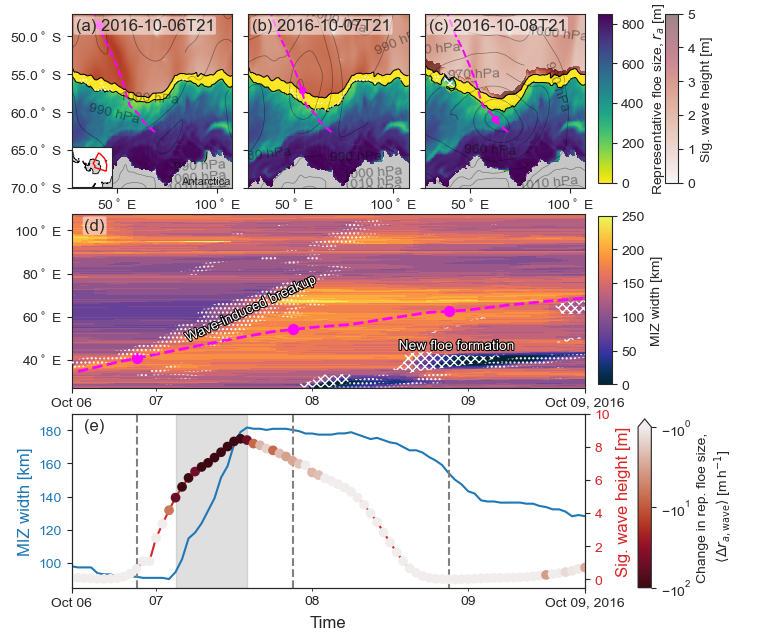

In [12]:
import matplotlib.ticker as mticker
import matplotlib.font_manager as fm
from matplotlib.colors import SymLogNorm
from matplotlib.patches import Rectangle

WAVE_COLORMESH = True

# Define formatters for latitude and longitude
def latitude_formatter(x, pos):
    return f'{abs(x):.1f}$^\circ$ {"S" if x < 0 else "N"}'

def longitude_formatter(x, pos):
    return f'{abs(x):.0f}$^\circ$ {"W" if x < 0 else "E"}'

df_single_track['date'] = pd.to_datetime(df_single_track['date'])
ds['miz_width_100']  = (ds['HTE'].where(ds['aice']>0.15).where(ds['fsdrad']<100)).sum(dim='nj')
ds['time'] = pd.to_datetime(ds['time'])
edge_path = netcdfpath+'ice-edge/'
edge_identifier = '_ice_edge.nc'
ds_edge = xr.open_dataset(edge_path + str(track_number) + edge_identifier).isel(radius=2)

land_mask = np.isnan(ds['aice'].isel(time=0))

# Constants
CYCLONE_TRACK_COLOR = 'magenta'

mid_point_idx = crossing_idx
time_indices = [mid_point_idx-24, mid_point_idx, mid_point_idx+24]
# time_indices = [0, mid_point_idx,-1]
diff = 1121

# Create a 2-row grid: first row for the 3 subplots, second row for the full-length panel
fig, axs = plt.subplots(3, 3, figsize=[plot_settings.width, (3/2)*plot_settings.height], sharex=False, gridspec_kw={'height_ratios': [1, 1, 1]})

# Loop through the time indices and plot each subplot (top row)
for i, time_idx in enumerate(time_indices):
    ax = axs[0, i]  # Get the current axis for the top row
    ax.set(xlim=(ds.TLON.min(), ds.TLON.max()))
    time_difference = abs(pd.to_datetime(df_single_track['date']) - ds.time.isel(time=time_idx).values)
    min_track_idx = time_difference.argmin()
    if WAVE_COLORMESH:
        # Read in WW3 data
        target_time_ww3 = pd.to_datetime(ds['time'].isel(time=time_idx).values).floor('D')
        ds_ww3 = load_closest_ww3_file(data_dir_ww3, target_time_ww3)
        ds_ww3_snapshot = ds_ww3.sel(time=target_time_ww3)
        roll = -360
        pc = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),
                                cmap=cmo.amp, vmin=0, vmax=10, shading='auto', alpha=0.99, zorder=1)
        pc.set_rasterized(True)

    # Land mask
    ax.pcolormesh(ds.TLON, ds.TLAT, land_mask.where(land_mask == 1), cmap='Greys', shading='auto', vmin=0, vmax=3)
    pcol1 = ax.pcolormesh(ds.TLON, ds.TLAT, ds['fsdrad'].isel(time=time_idx).where(ds['aice'].isel(time=time_idx) > 0.15),
                          cmap='viridis_r', vmin=0, vmax=850, shading='auto', zorder=2)
    pcol1.set_rasterized(True)

    contour = ax.contour(ds.TLON, ds.TLAT, ds['psl'].isel(time=time_idx)/100,
                         levels=np.arange(850, 1100, 10), colors='k', linewidths=0.5, alpha=0.4)
    ax.clabel(contour, inline=1, fontsize=10, fmt='%1.0f hPa', inline_spacing=5, rightside_up=True)

    pcol2 = ax.contourf(ds.TLON, ds.TLAT, ds['dafsd_wave_ra'].isel(time=time_idx),
                        levels=[-np.inf, -0.01], hatches=['.....'], colors='none', zorder=3)  
    
    pcol2 = ax.contourf(ds.TLON, ds.TLAT, ds['dafsd_newi_ra'].isel(time=time_idx),
                    levels=[10, 100], hatches=['xxxx'], colors='none', zorder=3)  

    ax.contour(ds.TLON, ds.TLAT, ds['aice'].isel(time=time_idx), levels=[0.15], colors='k', linewidths=0.75)
    ax.contour(ds.TLON, ds.TLAT, ds['fsdrad'].isel(time=time_idx), levels=[100], colors='k', linewidths=0.75)
    ax.plot(xarrayTrack['longitude'], xarrayTrack['latitude'], label='Cyclone', color=CYCLONE_TRACK_COLOR, linestyle='--')
    tmp_time = ds['time'].isel(time=time_idx)
    ax.scatter(xarrayTrack['longitude'].sel(time=tmp_time), xarrayTrack['latitude'].sel(time=tmp_time), 
               label='Cyclone', color=CYCLONE_TRACK_COLOR, s=20, zorder=2)

    time_str = pd.to_datetime(ds.time.isel(time=time_idx).values).strftime('%Y-%m-%dT%H')
    ax.text(plot_settings.label_x, plot_settings.label_y, f'({chr(97 + i)}) {time_str}', 
        transform=ax.transAxes, 
        fontsize=plot_settings.fontsize, 
        verticalalignment='top', 
        horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.1'),
        zorder=3)

    ax.set_xlabel('')
    ax.set(ylim=(-70, -47))

    if i != 0:
        ax.set_yticklabels([])
    else:
        ax.yaxis.set_major_formatter(mticker.FuncFormatter(latitude_formatter))
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(longitude_formatter))

# Set common labels for the top plots
axs[0, 0].set_ylabel('')

# MIDDLE AXIS
ax_middle = fig.add_subplot(312)
pcol2 = ax_middle.pcolormesh(ds['time'], ds['TLON'].mean(dim='nj'), (ds['miz_width_100']/1000).transpose(),
                                   vmin=0, vmax=250, cmap=cmo.thermal, shading='auto')
pcol2.set_rasterized(True)
# ax_middle.pcontour(ds['time'], ds['TLON'].mean(dim='nj'), (ds['miz_width_100']/1000).transpose(),
                                #   levels=[0, 100, 200, 300], shading='auto')

ax_middle.plot(pd.to_datetime(xarrayTrack['time']), xarrayTrack['longitude'], color=CYCLONE_TRACK_COLOR, 
               linewidth=2, linestyle='--')

for i, time_idx in enumerate(time_indices):
    tmp_time = ds['time'].isel(time=time_idx)
    ax_middle.scatter(xarrayTrack['time'].sel(time=tmp_time), xarrayTrack['longitude'].sel(time=tmp_time), 
               label='Cyclone', color=CYCLONE_TRACK_COLOR, s=50)

ax_middle.set_ylabel('')
ax_middle.set_xlim(ds.time[0], ds.time[-1])
ax_middle.yaxis.set_major_formatter(mticker.FuncFormatter(longitude_formatter))
ax_middle.text(plot_settings.label_x, plot_settings.label_y, f'({chr(97 + i+1)})', transform=ax_middle.transAxes, 
        fontsize=plot_settings.fontsize, verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.1'),
        zorder=3)


ax_middle.contourf(ds['time'], ds.TLON.mean(dim='nj'), ds['dafsd_wave_ra'].sum(dim='nj').transpose(),
                levels=[-np.inf, -20], hatches=['....'], colors='none', zorder=3)  

ax_middle.contourf(ds['time'], ds.TLON.mean(dim='nj'), ds['dafsd_newi_ra'].where(ds['TLAT'] > -60).max(dim='nj').transpose(),
                levels=[10, 1000], hatches=['xxxx'], colors='none', zorder=3)  

# BOTTOM AXIS
ax_bottom = fig.add_subplot(313)
ax_twin = ax_bottom.twinx()

color1 = 'tab:blue'
ax_bottom.plot(ds_edge['time'], ds_edge['miz_width'], color=color1)

color2 = 'tab:red'
ax_twin.plot(ds_edge['time'], ds_edge['wave_sig_ht'], color=color2, linestyle='-')
ax_twin.set_ylabel('Sig. wave height [m]', color=color2)
ax_twin.tick_params(axis='y', labelcolor=color2) 
scatter = ax_twin.scatter(x=ds_edge['time'], y=ds_edge['wave_sig_ht'], c=ds_edge['dafsd_wave_ra'], cmap=cmo.amp_r, zorder=2, 
                     norm=SymLogNorm(linthresh=10**-1, vmin=-10**2, vmax=-10**0))
ax_twin.set_ylim(-0.5,10)
ax_bottom.set_ylim(85,190)
for i, time_idx in enumerate(time_indices):
    plt.axvline(pd.to_datetime(ds['time'].isel(time=time_idx).values), color='gray', zorder=0, linestyle='--')

ax_bottom.set_xlabel('Time')
ax_bottom.set_xlim(ds.time[0], ds.time[-1])
ax_bottom.set_ylabel('MIZ width [km]', color=color1)  # Label for the bottom axis 
# ax_bottom.set_ylim(0,200)
ax_bottom.tick_params(axis='y', labelcolor=color1)  # Set the y-ticks color for the bottom axis
ax_bottom.text(plot_settings.label_x, plot_settings.label_y, f'({chr(97 + i+2)})', transform=ax_bottom.transAxes, 
        fontsize=plot_settings.fontsize, verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.1'),
        zorder=3)

for i in range(1,3):
    for j in range(3):
        axs[i, j].axis('off')

# Get the position of each axis to align colorbars accordingly
pos1 = axs[0, 0].get_position()  # Position of first axis (top row)
pos2 = axs[1, 2].get_position()  # Position of second axis (middle row)
pos3 = axs[2, 2].get_position()   # Position of the manually added middle axis

fig.subplots_adjust(right=0.9, hspace=0.15, wspace=0.1)
cbar_width = 0.02  # Width of the colorbar

# Create colorbar for vorticity (aligned with top row)
cbar_ax1 = fig.add_axes([0.92, pos1.y0, cbar_width, pos1.height]) 
cbar1 = fig.colorbar(pcol1, cax=cbar_ax1, extend=None)
cbar1.set_label('Representative floe size, $r_a$ [m]', fontsize=10)

pcol_hs = ax.pcolormesh(ds.TLON, ds.TLAT, ds['wave_sig_ht'].isel(time=time_idx).where(ds['aice'].isel(time=time_idx) < 0.15),
                     cmap=cmo.amp, vmin=0, vmax=5, shading='auto', alpha=0.5)
cbar_ax_hs = fig.add_axes([1.02, pos1.y0, cbar_width, pos1.height]) 
if WAVE_COLORMESH:
    cbar_hs = fig.colorbar(pcol_hs, cax=cbar_ax_hs, extend=None)
    cbar_hs.set_label('Sig. wave height [m]', fontsize=10)

# Create colorbar for ice vorticity (aligned with middle row)
cbar_ax2 = fig.add_axes([0.92, pos2.y0+0.001, cbar_width, pos2.height]) 
cbar2 = fig.colorbar(pcol2, cax=cbar_ax2, extend=None)
cbar2.set_label('MIZ width [km]', fontsize=10)

# Create colorbar for MIZ ice velocity (aligned with middle plot)
cbar_ax3 = fig.add_axes([0.98, pos3.y0, cbar_width, pos3.height])  
cbar3 = fig.colorbar(scatter, cax=cbar_ax3, extend='max')
cbar3.set_label('Change in rep. floe size,\n $\langle \Delta r_{a, \mathrm{wave}} \\rangle$ [m$\,$h$^{-1}$]\n', fontsize=10)


# Add the inset map for Antarctica
pos1 = axs[0, 0].get_position() 
inset_ax = fig.add_axes([pos1.x0, pos1.y0-0.001, pos1.width/4, pos1.height/4], projection=ccrs.SouthPolarStereo())  # Adjust position and size of inset
inset_ax.set_extent([-180, 180, -90, -40], crs=ccrs.PlateCarree())  # Set the extent to focus on Antarctica
# Add Antarctica to the inset map
inset_ax.add_feature(cfeature.LAND, color='lightgray')
inset_ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
highlighted_area = Rectangle((ds.TLON.min().values, ds.TLAT.min().values), ds.TLON.max().values - ds.TLON.min().values, 30,
                 linewidth=1, edgecolor='red', facecolor='none', zorder=3, transform=ccrs.PlateCarree())
inset_ax.add_patch(highlighted_area)

axs[0,0].text(1 - 0.01, 0.01, 'Antarctica', 
        transform=axs[0,0].transAxes, 
        fontsize=plot_settings.fontsize-4, 
        verticalalignment='bottom', 
        horizontalalignment='right',
        zorder=3)


start_date, end_date = ax_bottom.get_xlim()
new_start_date = mdates.num2date(start_date) + pd.Timedelta(hours=0)
end_date = mdates.num2date(end_date) + pd.Timedelta(hours=-6)
ax_middle.set_xlim(new_start_date, end_date)
ax_middle.xaxis.set_major_locator(mdates.MonthLocator())
ax_middle.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax_middle.xaxis.set_minor_locator(mdates.DayLocator())
ax_middle.xaxis.set_minor_formatter(mdates.DateFormatter('%d'))#


# Your axis settings
ax_bottom.set_xlim(new_start_date, end_date)
ax_bottom.xaxis.set_major_locator(mdates.MonthLocator())
ax_bottom.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax_bottom.xaxis.set_minor_locator(mdates.DayLocator())
ax_bottom.xaxis.set_minor_formatter(mdates.DateFormatter('%d'))

def custom_date_formatter(x, pos):
    if pos == len(ax_bottom.get_xticks()) - 1:  # Last tick
        return mdates.num2date(x).strftime('%b %d, %Y')  # Add year
    else:
        return mdates.num2date(x).strftime('%b %d')  # No year for other ticks

ax_middle.xaxis.set_major_formatter(plt.FuncFormatter(custom_date_formatter))
ax_bottom.xaxis.set_major_formatter(plt.FuncFormatter(custom_date_formatter))

THRESHOLD_STORM_PROXIMITY = 600 # 600/110 # 600 km from Hepworth, converted to deg. latitude
THRESHOLD_DAFSD_WAVE_RA = -20.0 # m/h
THRESHOLD_BREAKUP_TIME = 6 # Hours
ROLLING_TIME = 1

event = (ds_edge['dafsd_wave_ra']).rolling(time=ROLLING_TIME).mean()
event_idx = event < THRESHOLD_DAFSD_WAVE_RA
events_array = getEachBreakupIdx(event_idx)
if events_array:
    major_events_array = getMajorEvents(events_array, time_threshold=THRESHOLD_BREAKUP_TIME)
    if major_events_array:
        event_flag = np.sum(major_events_array, axis=0) != 0

        for i_event in range(np.shape(major_events_array)[0]):
            event_flag_tmp = major_events_array[i_event]
            event_flag_tmp = major_events_array[i_event]
            time_values = ds_edge['time'].values[event_flag_tmp]
            start_time = time_values[0]
            end_time = time_values[-1]
            ylim = ax_bottom.get_ylim()
            y_values = np.linspace(ylim[0], ylim[1], len(time_values))
            ax_bottom.fill_betweenx(y_values, start_time, end_time, color='gray', alpha=0.25, zorder=0)

# ANNOTATIONS
import matplotlib.patheffects as path_effects

text_breakup = ax_middle.text(
    0.35, 0.45, 'Wave-induced breakup',
    transform=ax_middle.transAxes,  # Apply transformation to the current axis
    fontsize=plot_settings.fontsize-2,  # Adjust fontsize as defined
    verticalalignment='center', 
    horizontalalignment='center', rotation=25, color='white',
    # bbox=dict(facecolor='gray', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.1'),
    zorder=3 
)
text_breakup.set_path_effects([path_effects.Stroke(linewidth=1.5, foreground='black'), path_effects.Normal()])


text_newi = ax_middle.text(
    0.75, 0.2, 'New floe formation',
    transform=ax_middle.transAxes,  # Apply transformation to the current axis
    fontsize=plot_settings.fontsize-2,  # Adjust fontsize as defined
    verticalalignment='bottom', 
    horizontalalignment='center', rotation=0, color='white',
    # bbox=dict(facecolor='gray', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.1'),
    zorder=3 
)

text_breakup.set_path_effects([path_effects.Stroke(linewidth=1.5, foreground='black'), path_effects.Normal()])
text_newi.set_path_effects([path_effects.Stroke(linewidth=1.5, foreground='black'), path_effects.Normal()])


plt.savefig(savepath + "case-studies/" + "{}_wave_case_study.png".format(track_number), dpi=300, transparent=False)
plt.savefig(savepath + "case-studies/" + "{}_wave_case_study.pdf".format(track_number), dpi=600, transparent=False)
plt.show()

### Animated gif

/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:262: UserWarning: Adding colorbar to a different Figure <Figure size 662.628x745.457 with 17 Axes> than <Figure size 1159.6x496.971 with 7 Axes> which fig.colorbar is called on.
  cbar1 = fig.colorbar(pcol1, cax=cbar_ax1, extend=None)
/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:265: UserWarning: Adding colorbar to a different Figure <Figure size 662.628x745.457 with 17 Axes> than <Figure size 1159.6x496.971 with 7 Axes> which fig.colorbar is called on.
  cbar2 = fig.colorbar(pcol2, cax=cbar_ax2, extend=None)
/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:269: UserWarning: Adding colorbar to a different Figure <Figure size 662.628x745.457 with 17 Axes> than <Figure size 1159.6x496.971 with 7 Axes> which fig.colorbar is called on.
  cbar_hs = fig.colorbar(pcol_hs, cax=cbar_ax_hs, extend=None)
/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:272: UserWarning: Adding colorbar to a different Figure <

2016-10-06 11:00:00
Loading file: ww3_om2_025deg_20161006.nc
2016-10-06 11:00:00
Loading file: ww3_om2_025deg_20161006.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-06 12:00:00
Loading file: ww3_om2_025deg_20161006.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-06 13:00:00
Loading file: ww3_om2_025deg_20161007.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-06 14:00:00
Loading file: ww3_om2_025deg_20161007.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-06 15:00:00
Loading file: ww3_om2_025deg_20161007.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-06 16:00:00
Loading file: ww3_om2_025deg_20161007.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-06 17:00:00
Loading file: ww3_om2_025deg_20161007.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-06 18:00:00
Loading file: ww3_om2_025deg_20161007.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-06 19:00:00
Loading file: ww3_om2_025deg_20161007.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-06 20:00:00
Loading file: ww3_om2_025deg_20161007.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-06 21:00:00
Loading file: ww3_om2_025deg_20161007.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-06 22:00:00
Loading file: ww3_om2_025deg_20161007.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-06 23:00:00
Loading file: ww3_om2_025deg_20161007.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-07 00:00:00
Loading file: ww3_om2_025deg_20161007.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-07 01:00:00
Loading file: ww3_om2_025deg_20161007.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-07 02:00:00
Loading file: ww3_om2_025deg_20161007.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-07 03:00:00
Loading file: ww3_om2_025deg_20161007.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-07 04:00:00
Loading file: ww3_om2_025deg_20161007.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-07 05:00:00
Loading file: ww3_om2_025deg_20161007.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-07 06:00:00
Loading file: ww3_om2_025deg_20161007.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-07 07:00:00
Loading file: ww3_om2_025deg_20161007.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-07 08:00:00
Loading file: ww3_om2_025deg_20161007.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-07 09:00:00
Loading file: ww3_om2_025deg_20161007.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-07 10:00:00
Loading file: ww3_om2_025deg_20161007.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-07 11:00:00
Loading file: ww3_om2_025deg_20161007.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-07 12:00:00
Loading file: ww3_om2_025deg_20161007.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-07 13:00:00
Loading file: ww3_om2_025deg_20161008.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-07 14:00:00
Loading file: ww3_om2_025deg_20161008.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-07 15:00:00
Loading file: ww3_om2_025deg_20161008.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-07 16:00:00
Loading file: ww3_om2_025deg_20161008.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-07 17:00:00
Loading file: ww3_om2_025deg_20161008.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-07 18:00:00
Loading file: ww3_om2_025deg_20161008.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-07 19:00:00
Loading file: ww3_om2_025deg_20161008.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-07 20:00:00
Loading file: ww3_om2_025deg_20161008.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-07 21:00:00
Loading file: ww3_om2_025deg_20161008.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-07 22:00:00
Loading file: ww3_om2_025deg_20161008.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-07 23:00:00
Loading file: ww3_om2_025deg_20161008.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-08 00:00:00
Loading file: ww3_om2_025deg_20161008.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-08 01:00:00
Loading file: ww3_om2_025deg_20161008.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-08 02:00:00
Loading file: ww3_om2_025deg_20161008.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-08 03:00:00
Loading file: ww3_om2_025deg_20161008.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-08 04:00:00
Loading file: ww3_om2_025deg_20161008.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-08 05:00:00
Loading file: ww3_om2_025deg_20161008.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-08 06:00:00
Loading file: ww3_om2_025deg_20161008.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-08 07:00:00
Loading file: ww3_om2_025deg_20161008.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-08 08:00:00
Loading file: ww3_om2_025deg_20161008.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-08 09:00:00
Loading file: ww3_om2_025deg_20161008.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-08 10:00:00
Loading file: ww3_om2_025deg_20161008.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-08 11:00:00
Loading file: ww3_om2_025deg_20161008.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-08 12:00:00
Loading file: ww3_om2_025deg_20161008.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-08 13:00:00
Loading file: ww3_om2_025deg_20161009.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-08 14:00:00
Loading file: ww3_om2_025deg_20161009.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-08 15:00:00
Loading file: ww3_om2_025deg_20161009.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-08 16:00:00
Loading file: ww3_om2_025deg_20161009.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-08 17:00:00
Loading file: ww3_om2_025deg_20161009.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-08 18:00:00
Loading file: ww3_om2_025deg_20161009.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-08 19:00:00
Loading file: ww3_om2_025deg_20161009.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-08 20:00:00
Loading file: ww3_om2_025deg_20161009.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-08 21:00:00
Loading file: ww3_om2_025deg_20161009.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-08 22:00:00
Loading file: ww3_om2_025deg_20161009.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-08 23:00:00
Loading file: ww3_om2_025deg_20161009.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-09 00:00:00
Loading file: ww3_om2_025deg_20161009.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-09 01:00:00
Loading file: ww3_om2_025deg_20161009.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-09 02:00:00
Loading file: ww3_om2_025deg_20161009.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-09 03:00:00
Loading file: ww3_om2_025deg_20161009.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-09 04:00:00
Loading file: ww3_om2_025deg_20161009.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-09 05:00:00
Loading file: ww3_om2_025deg_20161009.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-09 06:00:00
Loading file: ww3_om2_025deg_20161009.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-09 07:00:00
Loading file: ww3_om2_025deg_20161009.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-09 08:00:00
Loading file: ww3_om2_025deg_20161009.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-09 09:00:00
Loading file: ww3_om2_025deg_20161009.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-09 10:00:00
Loading file: ww3_om2_025deg_20161009.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-09 11:00:00
Loading file: ww3_om2_025deg_20161009.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-09 12:00:00
Loading file: ww3_om2_025deg_20161009.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-09 13:00:00
Loading file: ww3_om2_025deg_20161010.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-09 14:00:00
Loading file: ww3_om2_025deg_20161010.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-09 15:00:00
Loading file: ww3_om2_025deg_20161010.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-09 16:00:00
Loading file: ww3_om2_025deg_20161010.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-09 17:00:00
Loading file: ww3_om2_025deg_20161010.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-09 18:00:00
Loading file: ww3_om2_025deg_20161010.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-09 19:00:00
Loading file: ww3_om2_025deg_20161010.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-09 20:00:00
Loading file: ww3_om2_025deg_20161010.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-09 21:00:00
Loading file: ww3_om2_025deg_20161010.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-09 22:00:00
Loading file: ww3_om2_025deg_20161010.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-09 23:00:00
Loading file: ww3_om2_025deg_20161010.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-10 00:00:00
Loading file: ww3_om2_025deg_20161010.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


2016-10-06 11:00:00
Loading file: ww3_om2_025deg_20161006.nc


/jobfs/152851777.gadi-pbs/ipykernel_2637350/2273413344.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),


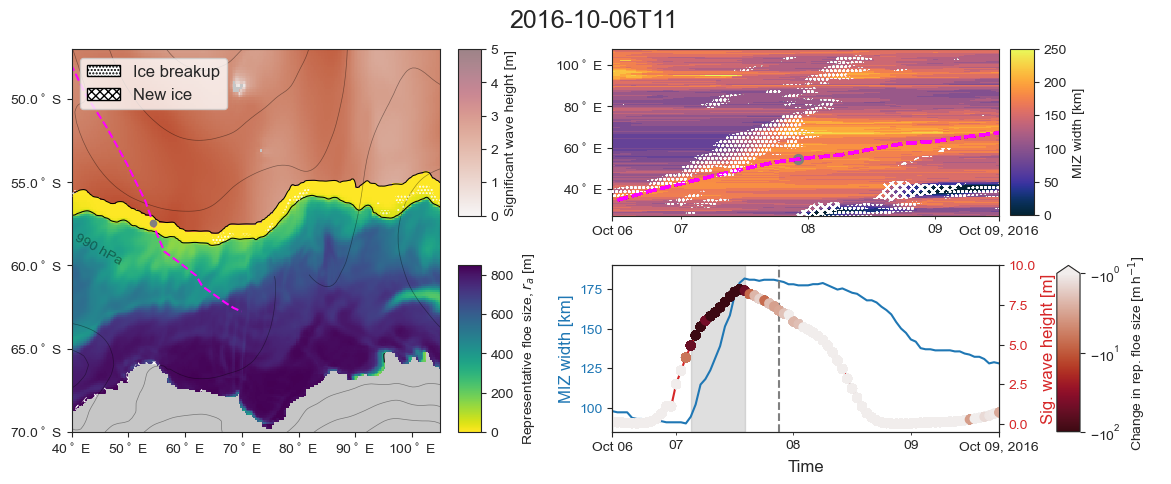

In [17]:
# import matplotlib.ticker as mticker
# import matplotlib.font_manager as fm
# from matplotlib.colors import SymLogNorm
# from matplotlib.patches import Rectangle
# from matplotlib import animation
# import numpy as np
# import pandas as pd
# import matplotlib.patches as mpatches


WAVE_COLORMESH = True

# Define formatters for latitude and longitude
def latitude_formatter(x, pos):
    return f'{abs(x):.1f}$^\circ$ {"S" if x < 0 else "N"}'

def longitude_formatter(x, pos):
    return f'{abs(x):.0f}$^\circ$ {"W" if x < 0 else "E"}'

df_single_track['date'] = pd.to_datetime(df_single_track['date'])
ds['miz_width_100']  = (ds['HTE'].where(ds['aice']>0.15).where(ds['fsdrad']<100)).sum(dim='nj')
ds['time'] = pd.to_datetime(ds['time'])
edge_path = netcdfpath+'ice-edge/'
edge_identifier = '_ice_edge.nc'
ds_edge = xr.open_dataset(edge_path + str(track_number) + edge_identifier).isel(radius=2)

land_mask = np.isnan(ds['aice'].isel(time=0))

# Constants
CYCLONE_TRACK_COLOR = 'magenta'

# mid_point_idx = crossing_idx
mid_point_idx = np.argmin(abs(ds.time.values - crossing_time))
frame_indices = np.arange(0, len(ds['time']))
# np.arange(mid_point_idx - 24, mid_point_idx + 25)
# np.arange(mid_point_idx - 1, mid_point_idx + 1)
# np.arange(mid_point_idx - 24, mid_point_idx + 25)


diff = 1121

hspace = 0.3
wspace = 0.1

fig, axes = plt.subplots(2, 2, figsize=[plot_settings.width*1.75, plot_settings.height], sharex=False, 
                         gridspec_kw={
                        'height_ratios': [1, 1],
                        'hspace': hspace,
                        'wspace': wspace 
                        })
fig.subplots_adjust(left=0.15, right=0.85)
axes[0,0].remove()
axes[1,0].remove()

colorbar_axes = []
other_axes = []
# fig.subplots_adjust(right=0.2)  # or lower, depending on how far left you want to go

ax_difference = 0.05



# Update function for animation
def update(frame_idx):
    global colorbar_axes
    global other_axes
    for cax in colorbar_axes:
        cax.remove()
    colorbar_axes = []

    for ax in other_axes:
        ax.remove()
    other_axes = []

    time_idx = frame_idx
    time_difference = abs(pd.to_datetime(df_single_track['date']) - ds.time.isel(time=frame_idx).values)
    min_track_idx = time_difference.argmin()
    
    ax = fig.add_subplot(121)
    pos_00 = ax.get_position()
    ax.set_position([
        pos_00.x0-2*ax_difference, pos_00.y0, pos_00.width, pos_00.height
    ])
    
    # axes[0,0].remove()
    # axes[1,0].remove()
    # ax.axis('off')
    time_difference = abs(pd.to_datetime(df_single_track['date']) - ds.time.isel(time=frame_idx).values)
    min_track_idx = time_difference.argmin()
    # if WAVE_COLORMESH:
        # Read in WW3 data
    
    target_time_ww3 = pd.to_datetime(ds['time'].isel(time=frame_idx).values).floor('h')
    print(target_time_ww3)
    ds_ww3 = load_closest_ww3_file(data_dir_ww3, target_time_ww3)
    
    ds_ww3_snapshot = ds_ww3.sel(time=target_time_ww3, method="nearest")
    roll = -360
    pcol_hs = ax.pcolormesh(ds_ww3_snapshot.LON.roll(dim_i=roll), ds_ww3_snapshot.LAT.roll(dim_i=roll), ds_ww3_snapshot['hs'].roll(dim_i=roll).where(ds_ww3_snapshot['hs'].roll(dim_i=roll)>0.1),
                            cmap=cmo.amp, vmin=0, vmax=10, shading='auto', alpha=0.99, zorder=1)
    pcol_hs.set_rasterized(True)
    
    # Land mask
    ax.pcolormesh(ds.TLON, ds.TLAT, land_mask.where(land_mask == 1), cmap='Greys', shading='auto', vmin=0, vmax=3)
    pcol1 = ax.pcolormesh(ds.TLON, ds.TLAT, ds['fsdrad'].isel(time=frame_idx).where(ds['aice'].isel(time=frame_idx) > 0.15),
                          cmap='viridis_r', vmin=0, vmax=850, shading='auto', zorder=2)
    pcol1.set_rasterized(True)

    contour = ax.contour(ds.TLON, ds.TLAT, ds['psl'].isel(time=frame_idx)/100,
                         levels=np.arange(850, 1100, 10), colors='k', linewidths=0.5, alpha=0.4)
    ax.clabel(contour, inline=1, fontsize=10, fmt='%1.0f hPa', inline_spacing=5, rightside_up=True)

    pcol2 = ax.contourf(ds.TLON, ds.TLAT, ds['dafsd_wave_ra'].isel(time=frame_idx),
                        levels=[-np.inf, -0.01], hatches=['.....'], colors='none', zorder=3)  
    
    pcol2 = ax.contourf(ds.TLON, ds.TLAT, ds['dafsd_newi_ra'].isel(time=frame_idx),
                    levels=[10, 100], hatches=['xxxx'], colors='none', zorder=3)  

    ax.contour(ds.TLON, ds.TLAT, ds['aice'].isel(time=frame_idx), levels=[0.15], colors='k', linewidths=0.75)
    ax.contour(ds.TLON, ds.TLAT, ds['fsdrad'].isel(time=frame_idx), levels=[100], colors='k', linewidths=0.75)
    ax.plot(xarrayTrack['longitude'], xarrayTrack['latitude'], label='Cyclone', color=CYCLONE_TRACK_COLOR, linestyle='--')
    tmp_time = ds['time'].isel(time=frame_idx)
    
    ax.scatter(xarrayTrack['longitude'].sel(time=crossing_time), xarrayTrack['latitude'].sel(time=crossing_time), 
               label='Cyclone', color='gray', s=20, zorder=2)
    
    ax.scatter(xarrayTrack['longitude'].sel(time=tmp_time), xarrayTrack['latitude'].sel(time=tmp_time), 
               label='Cyclone', color=CYCLONE_TRACK_COLOR, s=20, zorder=2)

    time_str = pd.to_datetime(ds.time.isel(time=frame_idx).values).strftime('%Y-%m-%dT%H')
    fig.suptitle(time_str, fontsize=18, y=0.96)
 
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set(xlim=(40, 105))
    ax.set(ylim=(-70, -47))
    
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(longitude_formatter))
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(latitude_formatter))

    
    dot_patch = mpatches.Patch(
                facecolor='white',
                hatch='.....',
                edgecolor='black',
                label='Ice breakup'
                )
    hatch_patch = mpatches.Patch(
                facecolor='white',
                hatch='xxxx',
                edgecolor='black',
                label='New ice'
                )
    
    ax.legend(handles=[dot_patch, hatch_patch], loc='upper left') 
    other_axes.append(ax)


    # MIDDLE AXIS
    ax_middle = axes[0,1] #fig.add_subplot(312)
    pcol2 = ax_middle.pcolormesh(ds['time'], ds['TLON'].mean(dim='nj'), (ds['miz_width_100']/1000).transpose(),
                                       vmin=0, vmax=250, cmap=cmo.thermal, shading='auto')
    pcol2.set_rasterized(True)
    # ax_middle.pcontour(ds['time'], ds['TLON'].mean(dim='nj'), (ds['miz_width_100']/1000).transpose(),
                                    #   levels=[0, 100, 200, 300], shading='auto')
    
    ax_middle.plot(pd.to_datetime(xarrayTrack['time']), xarrayTrack['longitude'], color=CYCLONE_TRACK_COLOR, 
                   linewidth=2, linestyle='--')
    ax_middle.scatter(xarrayTrack['time'].sel(time=crossing_time), xarrayTrack['longitude'].sel(time=crossing_time), 
                   label='Cyclone', color='gray', s=50)
    
    tmp_time = ds['time'].isel(time=frame_idx)
    ax_middle.scatter(xarrayTrack['time'].sel(time=tmp_time), xarrayTrack['longitude'].sel(time=tmp_time), 
                   label='Cyclone', color=CYCLONE_TRACK_COLOR, s=50)
    
    ax_middle.set_ylabel('')
    ax_middle.set_xlim(ds.time[0], ds.time[-1])
    ax_middle.yaxis.set_major_formatter(mticker.FuncFormatter(longitude_formatter))
    
    
    ax_middle.contourf(ds['time'], ds.TLON.mean(dim='nj'), ds['dafsd_wave_ra'].sum(dim='nj').transpose(),
                    levels=[-np.inf, -20], hatches=['....'], colors='none', zorder=3)  
    
    ax_middle.contourf(ds['time'], ds.TLON.mean(dim='nj'), ds['dafsd_newi_ra'].where(ds['TLAT'] > -60).max(dim='nj').transpose(),
                    levels=[10, 1000], hatches=['xxxx'], colors='none', zorder=3)  


    scatter = ax_twin.scatter(x=ds_edge['time'].isel(time=slice(0,frame_idx)), y=ds_edge['wave_sig_ht'].isel(time=slice(0,frame_idx)), c=ds_edge['dafsd_wave_ra'].isel(time=slice(0,frame_idx)), cmap=cmo.amp_r, zorder=2, 
                     norm=SymLogNorm(linthresh=10**-1, vmin=-10**2, vmax=-10**0))

    start_date, end_date = ax_bottom.get_xlim()
    new_start_date = mdates.num2date(start_date) + pd.Timedelta(hours=0)
    end_date = mdates.num2date(end_date) + pd.Timedelta(hours=-6)
    ax_middle.set_xlim(new_start_date, end_date)
    ax_middle.xaxis.set_major_locator(mdates.MonthLocator())
    ax_middle.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    ax_middle.xaxis.set_minor_locator(mdates.DayLocator())
    ax_middle.xaxis.set_minor_formatter(mdates.DateFormatter('%d'))

    def custom_date_formatter(x, pos):
        if pos == len(ax_middle.get_xticks()) - 1:  # Last tick
            return mdates.num2date(x).strftime('%b %d, %Y')  # Add year
        else:
            return mdates.num2date(x).strftime('%b %d')  # No year for other ticks
    ax_middle.xaxis.set_major_formatter(plt.FuncFormatter(custom_date_formatter))
    
    # other_axes.append(ax_middle)    
    return axes,


# BOTTOM AXIS
ax_bottom = axes[1,1] 
# pos_tmp = ax_bottom.get_position()
# ax_bottom.set_position([
#         pos_tmp.x0-ax_difference/2, pos_tmp.y0, pos_tmp.width, pos_tmp.height
#     ])

ax_twin = ax_bottom.twinx()

color1 = 'tab:blue'
ax_bottom.plot(ds_edge['time'], ds_edge['miz_width'], color=color1)

color2 = 'tab:red'
ax_twin.plot(ds_edge['time'], ds_edge['wave_sig_ht'], color=color2, linestyle='-')
ax_twin.set_ylabel('Sig. wave height [m]', color=color2)
ax_twin.tick_params(axis='y', labelcolor=color2) 
# scatter = ax_twin.scatter(x=ds_edge['time'], y=ds_edge['wave_sig_ht'], c=ds_edge['dafsd_wave_ra'], cmap=cmo.amp_r, zorder=2, 
                     # norm=SymLogNorm(linthresh=10**-1, vmin=-10**2, vmax=-10**0))
ax_twin.set_ylim(-0.5,10)
ax_bottom.set_ylim(85,190)
# for i, time_idx in enumerate(time_indices):
plt.axvline(pd.to_datetime(ds['time'].isel(time=crossing_idx).values), color='gray', zorder=0, linestyle='--')

ax_bottom.set_xlabel('Time')
ax_bottom.set_xlim(ds.time[0], ds.time[-1])
ax_bottom.set_ylabel('MIZ width [km]', color=color1) 
ax_bottom.tick_params(axis='y', labelcolor=color1) 


ax_middle.set_xlim(ds.time[0], ds.time[-1])


# COLORBARS
pos1a = axes[0, 0].get_position()
pos1b = axes[1, 0].get_position()
pos2 = axes[0, 1].get_position()  # Position of second axis (middle row)
pos3 = axes[1, 1].get_position()   # Position of the manually added middle axis

# fig.subplots_adjust(right=0.9, hspace=0.15, wspace=0.1)
cbar_width = 0.02  # Width of the colorbar
cbar_gap = 0.01

# Create colorbar for vorticity (aligned with top row)
cbar_ax1 = fig.add_axes([pos1b.x1 - 2*ax_difference, pos1b.y0, cbar_width, pos1b.height]) 

if WAVE_COLORMESH:
    cbar_ax_hs = fig.add_axes([pos1a.x1 - 2*ax_difference, pos1a.y0, cbar_width, pos1a.height]) 
cbar_ax2 = fig.add_axes([pos2.x1 + cbar_gap, pos2.y0+0.001, cbar_width, pos2.height]) 
cbar_ax3 = fig.add_axes([pos3.x1 + 5*cbar_gap, pos3.y0, cbar_width, pos3.height])  


cbar1 = fig.colorbar(pcol1, cax=cbar_ax1, extend=None)
cbar1.set_label('Representative floe size, $r_a$ [m]', fontsize=10)

cbar2 = fig.colorbar(pcol2, cax=cbar_ax2, extend=None)
cbar2.set_label('MIZ width [km]', fontsize=10)

if WAVE_COLORMESH:
    cbar_hs = fig.colorbar(pcol_hs, cax=cbar_ax_hs, extend=None)
    cbar_hs.set_label('Significant wave height [m]', fontsize=10)

cbar3 = fig.colorbar(scatter, cax=cbar_ax3, extend='max')
cbar3.set_label('Change in rep. floe size [m$\,$h$^{-1}$]\n', fontsize=10)



ax_bottom.set_xlim(new_start_date, end_date)
ax_bottom.xaxis.set_major_locator(mdates.MonthLocator())
ax_bottom.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax_bottom.xaxis.set_minor_locator(mdates.DayLocator())
ax_bottom.xaxis.set_minor_formatter(mdates.DateFormatter('%d'))

def custom_date_formatter(x, pos):
    if pos == len(ax_bottom.get_xticks()) - 1:  # Last tick
        return mdates.num2date(x).strftime('%b %d, %Y')  # Add year
    else:
        return mdates.num2date(x).strftime('%b %d')  # No year for other ticks

ax_bottom.xaxis.set_major_formatter(plt.FuncFormatter(custom_date_formatter))



THRESHOLD_STORM_PROXIMITY = 600 # 600/110 # 600 km from Hepworth, converted to deg. latitude
THRESHOLD_DAFSD_WAVE_RA = -20.0 # m/h
THRESHOLD_BREAKUP_TIME = 6 # Hours
ROLLING_TIME = 1

event = (ds_edge['dafsd_wave_ra']).rolling(time=ROLLING_TIME).mean()
event_idx = event < THRESHOLD_DAFSD_WAVE_RA
events_array = getEachBreakupIdx(event_idx)
if events_array:
    major_events_array = getMajorEvents(events_array, time_threshold=THRESHOLD_BREAKUP_TIME)
    if major_events_array:
        event_flag = np.sum(major_events_array, axis=0) != 0

        for i_event in range(np.shape(major_events_array)[0]):
            event_flag_tmp = major_events_array[i_event]
            event_flag_tmp = major_events_array[i_event]
            time_values = ds_edge['time'].values[event_flag_tmp]
            start_time = time_values[0]
            end_time = time_values[-1]
            ylim = ax_bottom.get_ylim()
            y_values = np.linspace(ylim[0], ylim[1], len(time_values))
            ax_bottom.fill_betweenx(y_values, start_time, end_time, color='gray', alpha=0.25, zorder=0)

# ANNOTATIONS
import matplotlib.patheffects as path_effects

text_breakup = ax_middle.text(
    0.35, 0.45, 'Wave-induced breakup',
    transform=ax_middle.transAxes,  # Apply transformation to the current axis
    fontsize=plot_settings.fontsize-2,  # Adjust fontsize as defined
    verticalalignment='center', 
    horizontalalignment='center', rotation=25, color='white',
    zorder=3 
)
text_breakup.set_path_effects([path_effects.Stroke(linewidth=1.5, foreground='black'), path_effects.Normal()])


text_newi = ax_middle.text(
    0.75, 0.2, 'New floe formation',
    transform=ax_middle.transAxes,  # Apply transformation to the current axis
    fontsize=plot_settings.fontsize-2,  # Adjust fontsize as defined
    verticalalignment='bottom', 
    horizontalalignment='center', rotation=0, color='white',
    zorder=3 
)

text_breakup.set_path_effects([path_effects.Stroke(linewidth=1.5, foreground='black'), path_effects.Normal()])
text_newi.set_path_effects([path_effects.Stroke(linewidth=1.5, foreground='black'), path_effects.Normal()])

ani = animation.FuncAnimation(fig, update, frames=frame_indices, blit=False, interval=200)
ani.save(os.path.join(savepath, f"gif/waves/cyclone_animation_{str(track_number)}.mp4"), writer="ffmpeg", dpi=500)

# plt.savefig(savepath + "case-studies/" + "{}_wave_case_study.png".format(track_number), dpi=300, transparent=False)
# plt.savefig(savepath + "case-studies/" + "{}_wave_case_study.pdf".format(track_number), dpi=600, transparent=False)
# plt.show()

## Time series of atmospheric variables

In [20]:
def interpolateDataframe(df, var, scaling=1, centering='init'):
    num_points = 100
    # Prepare the common time differences
    min_time_diff = df['time_diff'].min() - pd.Timedelta(days=4)
    max_time_diff = df['time_diff'].max() + pd.Timedelta(days=4)
    min_seconds = min_time_diff.total_seconds() / 60**2
    max_seconds = max_time_diff.total_seconds() / 60**2
    common_time_diff = np.linspace(min_seconds, max_seconds, num_points)
    
    # Dictionary to store data for interpolation
    interpolation_data = {'time_diff': common_time_diff}
    # Iterate over each group and interpolate
    for track, group in df.groupby('track'):
        group_time_diff_hours = group['time_diff'].values.astype('timedelta64[ns]') / np.timedelta64(1, 'ns')
        interpolated_values = np.interp(common_time_diff, group_time_diff_hours, group[var]) * scaling
        out_of_bounds = (common_time_diff < group_time_diff_hours.min()) | (common_time_diff > group_time_diff_hours.max())
        
        # Store interpolated data in dictionary
        if centering=='init':
            first_non_nan_index = pd.Series(interpolated_values).first_valid_index()
            first_non_nan_value = pd.Series(interpolated_values).loc[first_non_nan_index]
            interpolation_data[var + f'_{track}'] = interpolated_values - first_non_nan_value
        elif centering=='mean':
            interpolation_data[var + f'_{track}'] = interpolated_values - interpolated_values.mean()
        elif centering=='midpoint':
            interpolation_data[var + f'_{track}'] = interpolated_values - interpolated_values[(len(interpolated_values)//2)]
        elif centering=='norm':
            interpolation_data[var + f'_{track}'] = (interpolated_values / interpolated_values.mean()) - 1
        elif centering=='norm_init':
            interpolation_data[var + f'_{track}'] = interpolated_values / interpolated_values[0]
        elif centering=='-24':
            interpolation_data[var + f'_{track}'] = interpolated_values - interpolated_values[(len(interpolated_values)//2) - 24]
        elif centering=='ends':
            first_non_nan_index = pd.Series(interpolated_values).first_valid_index()
            first_non_nan_value = pd.Series(interpolated_values).loc[first_non_nan_index]

            last_non_nan_index = pd.Series(interpolated_values).last_valid_index()
            last_non_nan_value = pd.Series(interpolated_values).loc[last_non_nan_index]
            
            mean_between = (pd.Series(interpolated_values).loc[first_non_nan_index] + pd.Series(interpolated_values).loc[last_non_nan_index])/2

            interpolation_data[var + f'_{track}'] = interpolated_values - mean_between
        else:
             interpolation_data[var + f'_{track}'] = interpolated_values
        interpolation_data[var + f'_{track}'] = np.where(out_of_bounds, np.nan, interpolation_data[var + f'_{track}'])
    
    # Create DataFrame in one go
    interpolated_df = pd.DataFrame(interpolation_data)
    
    # Compute mean and std
    interpolated_df['mean_' + var] = (interpolated_df.filter(like=var+'_')).mean(axis=1)
    interpolated_df['std_' + var] = (interpolated_df.filter(like=var+'_')).std(axis=1)

    interpolated_df['median_' + var] = (interpolated_df.filter(like=var+'_')).median(axis=1)
    interpolated_df['iqr_25_' + var] =  interpolated_df.filter(like=var+'_').quantile(0.25, axis=1)
    interpolated_df['iqr_75_' + var] = interpolated_df.filter(like=var+'_').quantile(0.75, axis=1)
    return interpolated_df, common_time_diff, interpolation_data

In [22]:
scaling = 1

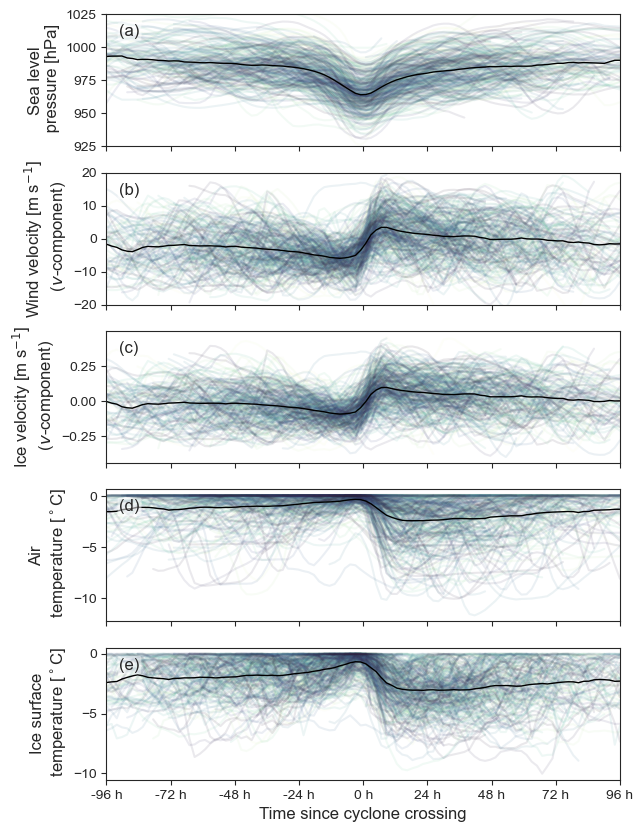

In [25]:
df_storm = pd.read_csv(netcdfpath+'csvs/storm_ts_n347_single_cross.csv')
df_storm['time_diff'] = pd.to_timedelta(df_storm['time_diff'], errors='coerce')

import matplotlib.cm as cm
# Define the colormap and normalize based on the number of tracks
# cmap = cm.get_cmap('mako_r', len(df_storm['track'].unique()))
# norm = plt.Normalize(vmin=0, vmax=len(df_storm['track'].unique()))
cmap = cmo.deep
norm = plt.Normalize(vmin=0, vmax=len(df_storm['track'].unique()))
mean_col = 'k'

fig, axes = plt.subplots(5, 1, figsize=(plot_settings.width, plot_settings.height*2), sharex=True, sharey=False)

# Plot psl with varying colors
var = 'psl'
interpolated_df, common_time_diff, interpolation_data = interpolateDataframe(df_storm, var, 0.01, None)

for i, track in enumerate(df_storm['track'].unique()[0:]):
    axes[0].plot(common_time_diff, interpolated_df[var + f'_{track}'], color=cmap(norm(i)), alpha=0.1)
axes[0].plot(common_time_diff, interpolated_df['mean_' + var], color=mean_col, linewidth=1)

# Plot vatm
var = 'vatm'
interpolated_df, common_time_diff, interpolation_data = interpolateDataframe(df_storm, var, scaling, None)

for i, track in enumerate(df_storm['track'].unique()[0:]):
    axes[1].plot(common_time_diff, interpolated_df[var + f'_{track}'], color=cmap(norm(i)), alpha=0.1)
axes[1].plot(common_time_diff, interpolated_df['mean_' + var], color=mean_col, linewidth=1)


# Plot vvel
var = 'vvel'
interpolated_df, common_time_diff, interpolation_data = interpolateDataframe(df_storm, var, scaling, None)

for i, track in enumerate(df_storm['track'].unique()[0:]):
    axes[2].plot(common_time_diff, interpolated_df[var + f'_{track}'], color=cmap(norm(i)), alpha=0.1)
axes[2].plot(common_time_diff, interpolated_df['mean_' + var], color=mean_col, linewidth=1)

# Plot Tair
var = 'Tair'
interpolated_df, common_time_diff, interpolation_data = interpolateDataframe(df_storm, var, scaling, None)

for i, track in enumerate(df_storm['track'].unique()[0:]):
    axes[3].plot(common_time_diff, interpolated_df[var + f'_{track}'], color=cmap(norm(i)), alpha=0.1)
axes[3].plot(common_time_diff, interpolated_df['mean_' + var], color=mean_col, linewidth=1)


# Plot Tsfc
var = 'Tsfc'
interpolated_df, common_time_diff, interpolation_data = interpolateDataframe(df_storm, var, scaling, None)

for i, track in enumerate(df_storm['track'].unique()[0:]):
    axes[4].plot(common_time_diff, interpolated_df[var + f'_{track}'], color=cmap(norm(i)), alpha=0.1)
axes[4].plot(common_time_diff, interpolated_df['mean_' + var], color=mean_col, linewidth=1)





# Set labels and lines
axes[0].set(ylabel='Sea level\n pressure [hPa]')
axes[1].set(ylabel='Wind velocity [m s$^{-1}$]\n ($v$-component)')
axes[2].set(ylabel='Ice velocity [m s$^{-1}$]\n ($v$-component)')
axes[3].set(ylabel='Air\n temperature [$^\circ$C]')
axes[4].set(ylabel='Ice surface\n temperature [$^\circ$C]')

start_date, end_date = axes[0].get_xlim()
new_start_date = mdates.num2date(start_date) + pd.Timedelta(days=12)
new_end_date = mdates.num2date(end_date) + pd.Timedelta(days=-12)


for i, ax in enumerate(axes):
    ax.set_xlim(new_start_date, new_end_date)
    # ax.axhline(0, color='k', zorder=0)
    ax.text(plot_settings.label_x, plot_settings.label_y-0.05, f'({chr(97 + i)})', transform=ax.transAxes, 
        fontsize=plot_settings.fontsize, verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.1'),
        zorder=3)

axes[-1].set_xticks(np.arange(-96, 97, 24))
axes[-1].set_xticklabels([f'{int(t)} h' for t in np.arange(-96, 97, 24)])
axes[-1].set_xlabel('Time since cyclone crossing')

axes[0].set_ylim(925,1025)

x_values = np.linspace(*axes[1].get_xlim(), 100)
# axes[1].fill_between(x=x_values, y1=10, y2=axes[1].get_ylim()[1]+10, color='gray', zorder=0, alpha=0.15)
# axes[1].fill_between(x=x_values, y1=axes[1].get_ylim()[0]-10, y2=-10, color='gray', zorder=0, alpha=0.15)
axes[1].set_ylim(-20,20)

plt.savefig(savepath + "{}_ts_analysis_psl_vvel_tsfc.png".format(var), dpi=300, transparent=False)
plt.savefig(savepath + "{}_ts_analysis_psl_vvel_tsfc.pdf".format(var), dpi=300, transparent=False)
plt.savefig(savepath + "{}_ts_analysis_psl_vvel_tsfc.eps".format(var), dpi=300, transparent=False)
plt.show()

## Time series of ice and wave variables

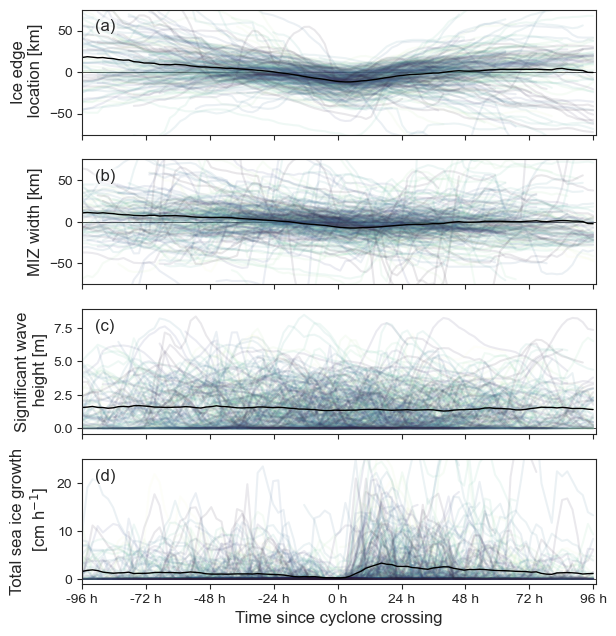

In [30]:
import matplotlib.cm as cm
# Define the colormap and normalize based on the number of tracks
# cmap = cm.get_cmap('mako_r', len(df_storm['track'].unique()))
# norm = plt.Normalize(vmin=0, vmax=len(df_storm['track'].unique()))
cmap = cmo.deep
norm = plt.Normalize(vmin=0, vmax=len(df_storm['track'].unique()))
mean_col = 'k'

fig, axes = plt.subplots(4, 1, figsize=(plot_settings.width, plot_settings.height*1.5), sharex=True, sharey=False)

scaling = 1
# Plot vvel
var = 'ice_edge'
interpolated_df, common_time_diff, interpolation_data = interpolateDataframe(df_storm, var, scaling, 'mean')
lines_data = []
for i, track in enumerate(df_storm['track'].unique()[0:]):
        line_data = interpolated_df[var + f'_{track}'] * 110  # Data for each track
        axes[0].plot(common_time_diff, line_data, color=cmap(norm(i)), alpha=0.1)
        lines_data.append(line_data)

lines_array = np.array(lines_data)
average_line = np.nanmean(lines_array, axis=0)
axes[0].plot(common_time_diff, average_line, color='black', linewidth=1, label='Average')


# Plot vatm
var = 'miz_width'
interpolated_df, common_time_diff, interpolation_data = interpolateDataframe(df_storm, var, scaling, 'mean')

for i, track in enumerate(df_storm['track'].unique()[0:]):
    line_data = interpolated_df[var + f'_{track}']  # Data for each track
    axes[1].plot(common_time_diff, line_data, color=cmap(norm(i)), alpha=0.1)
    # axes[1].plot(common_time_diff, interpolated_df[var + f'_{track}'], color=cmap(norm(i)), alpha=0.1)
    lines_data.append(line_data)

lines_array = np.array(lines_data)
average_line = np.nanmean(lines_array, axis=0)
axes[1].plot(common_time_diff, average_line, color='black', linewidth=1, label='Average')



# Plot psl with varying colors
var = 'wave_sig_ht'
interpolated_df, common_time_diff, interpolation_data = interpolateDataframe(df_storm, var, 1, None)

for i, track in enumerate(df_storm['track'].unique()[0:]):
    axes[2].plot(common_time_diff, interpolated_df[var + f'_{track}'], color=cmap(norm(i)), alpha=0.1)
axes[2].plot(common_time_diff, interpolated_df['mean_' + var], color=mean_col, linewidth=1)




# Plot Tair
var = 'total_growth'
df_storm['total_melt'] = df_storm['meltl'] + df_storm['meltt'] + df_storm['meltb']
df_storm['total_growth'] = df_storm['frazil'] + df_storm['congel'] 
interpolated_df, common_time_diff, interpolation_data = interpolateDataframe(df_storm, var, scaling, None)

for i, track in enumerate(df_storm['track'].unique()[0:]):
    axes[3].plot(common_time_diff, interpolated_df[var + f'_{track}'], color=cmap(norm(i)), alpha=0.1)
axes[3].plot(common_time_diff, interpolated_df['mean_' + var], color=mean_col, linewidth=1)






# # Set labels and lines
axes[0].set(ylabel='Ice edge\n location [km]')
axes[1].set(ylabel='MIZ width [km]')
axes[2].set(ylabel='Significant wave\n height [m]')
axes[3].set(ylabel='Total sea ice growth\n [cm h$^{-1}$]')


axes[0].set_ylim(-75,75)
axes[1].set_ylim(-75,75)
axes[3].set_ylim(-1,25)


start_date, end_date = axes[0].get_xlim()
new_start_date = mdates.num2date(start_date) + pd.Timedelta(days=12)
new_end_date = mdates.num2date(end_date) + pd.Timedelta(days=-12)

xlim = [-96, 97]
xticks = np.arange(xlim[0], xlim[1], 24)

for i, ax in enumerate(axes):
    ax.set_xlim(new_start_date, new_end_date)
    # ax.axhline(0, color='k', zorder=0)
    ax.text(plot_settings.label_x, plot_settings.label_y-0.05, f'({chr(97 + i)})', transform=ax.transAxes, 
        fontsize=plot_settings.fontsize, verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.1'),
        zorder=3)
    ax.axhline(0, color='black', linewidth=0.5, zorder=0)
    ax.set_xlim(xlim)

axes[-1].set_xticks(xticks)
axes[-1].set_xticklabels([f'{int(t)} h' for t in xticks])
axes[-1].set_xlabel('Time since cyclone crossing')


plt.savefig(savepath + "ts_analysis_ice_edge_miz_width.png".format(var), dpi=300, transparent=False)
plt.savefig(savepath + "ts_analysis_ice_edge_miz_width.pdf".format(var), dpi=300, transparent=False)
plt.savefig(savepath + "ts_analysis_ice_edge_miz_width.eps".format(var), dpi=300, transparent=False)
plt.show()

## Distribution of event timings

In [90]:
# Load separate dataset for plot 3 and 4
df_breakup = pd.read_csv(netcdfpath + 'csvs/breakup_n_347.csv')
data_wave = df_breakup#[df_breakup['event']]# != 'reference']


# Load the dataset
df_dynamics = pd.read_csv(netcdfpath + 'csvs/dynamics_extravars_events_0ms_n_263.csv')

colvars = df_dynamics.columns
colvars_filtered = [var for var in colvars if var != 'relative_time']
data = df_dynamics.copy()

# Calculate new columns in kilometers
data['delta_ice_edge_sum_km'] = data['delta_ice_edge'] * 111
data['delta_ice_edge_per_hour_km'] = data['delta_ice_edge_per_hour'] * 111
data['abs_delta_ice_edge_km'] = data['abs_delta_ice_edge'] * 111

# Convert 'time' column to datetime format
data['time'] = pd.to_datetime(data['time'])

# Specify the time column and columns to sum
time_col = 'time'
cols_to_sum = [col for col in data.columns if col not in ['track', 'event', time_col]]

# Group by 'track' and 'event', aggregate specified columns
data = data.groupby(['track', 'event']).agg({
    **{col: 'sum' for col in cols_to_sum},
    time_col: 'median'
}).reset_index()

data['time']

# data_tmp = data.groupby(['track', 'event']).agg({
#     **{col: 'sum' for col in cols_to_sum},  # Apply 'sum' to all columns except 'time'
#     time_col: 'median'  # Apply 'median' to the 'time' column
# }).reset_index()
# events = ['off_ice', 'reference', 'on_ice']
# data_tmp = data[data['event'].isin(events)]
# data_tmp = data_tmp.groupby(['track', 'event']).sum().reset_index()

0      2015-07-10 23:00:00
1      2015-07-10 00:30:00
2      2015-07-10 20:45:00
3      2015-07-10 09:00:00
4      2015-07-10 08:00:00
               ...        
1170   2018-11-24 05:00:00
1171   2018-11-28 17:00:00
1172   2018-11-28 22:00:00
1173   2018-11-28 04:30:00
1174   2018-11-28 18:00:00
Name: time, Length: 1175, dtype: datetime64[ns]

In [91]:
# data_tmp['event'].unique()
data['time'] = pd.to_datetime(data['time'])
data['month'] = data['time'].dt.month
data['day-month'] = data['time'].dt.strftime('%d-%m')  # Formats as 'day-month'

data_tmp['time'] = pd.to_datetime(data_tmp['time'])
data_tmp['month'] = data_tmp['time'].dt.month
data_tmp['day-month'] = data_tmp['time'].dt.strftime('%d-%m')  # Formats as 'day-month'


data['time'] = pd.to_datetime(data['time'])
data['month'] = data['time'].dt.month
data['month'] = data['month'].astype(str).str.zfill(2)  # Add leading zero to single-digit months
data['month'] = pd.to_datetime('15-' + data['month'] + '-2018', format='%d-%m-%Y')
data['day-month'] = data['time'].dt.strftime('%d-%m')  # Formats as 'day-month'
data['day-month'] = pd.to_datetime(data['day-month'] + '-2018', format='%d-%m-%Y')


# data_tmp['time'] = pd.to_datetime(data_tmp['time'])
# data_tmp['month'] = data_tmp['time'].dt.month
# data_tmp['month'] = data_tmp['month'].astype(str).str.zfill(2)  # Add leading zero to single-digit months
# data_tmp['month'] = pd.to_datetime('15-' + data_tmp['month'] + '-2018', format='%d-%m-%Y')
# data_tmp['day-month'] = data_tmp['time'].dt.strftime('%d-%m')  # Formats as 'day-month'
# data_tmp['day-month'] = pd.to_datetime(data_tmp['day-month'] + '-2018', format='%d-%m-%Y')

# monthly_mean = data.groupby('month').mean()
# monthly_std = data.groupby('month').std()

palette = cmo.balance

In [92]:
data

track      event                       relative_time  \
0     201519630   freezing                   -1 days +09:00:00   
1     201519630    melting                     0 days 07:30:00   
2     201519630    off_ice  -1 days +18:00:00-1 days +04:30:00   
3     201519630     on_ice    0 days 10:30:00-1 days +11:30:00   
4     201519630  reference                     0 days 00:00:00   
...         ...        ...                                 ...   
1170  201829426  reference                     0 days 00:00:00   
1171  201829650    melting                     0 days 06:00:00   
1172  201829650    off_ice    0 days 07:30:00-1 days +18:30:00   
1173  201829650     on_ice                     0 days 18:30:00   
1174  201829650  reference                     0 days 05:00:00   

      delta_ice_edge  delta_ice_edge_per_hour  abs_delta_ice_edge  \
0           0.267124                 0.016695            0.267124   
1          -0.279312                -0.010345            0.279312   
2           0.121769                 0.016820            0.206490   
3          -0.133919                 0.008211            0.352135   
4           0.000000                 0.000000            0.558624   
...              ...                      ...                 ...   
1170       -0.167515                -0.003642            0.179363   
1171       -0.049610                -0.001459            0.077023   
1172       -0.016552                -0.001726            0.044010   
1173       -0.022041                -0.002449            0.022041   
1174       -0.054977                -0.001527            0.087875   

      abs_delta_ice_edge_per_hour  delta_miz_width  delta_miz_width_per_hour  \
0                        0.016695        10.186157                  0.636635   
1                        0.009975       -38.893723                 -1.440508   
2                        0.029499        -3.368805                 -0.699961   
3                        0.025973       -25.289932                 -0.124415   
4                        0.012144       -32.535339                 -0.707290   
...                           ...              ...                       ...   
1170                     0.003899       -86.861748                 -1.888299   
1171                     0.002201        33.423523                  0.983045   
1172                     0.004126        23.115540                  2.088224   
1173                     0.002204         7.493576                  0.832620   
1174                     0.002441        32.826126                  0.911837   

      abs_delta_miz_width  ...  delta_MIZ_SIE  delta_MIZ_SIA  delta_MIZ_SIV  \
0               28.250946  ...   1.780412e+09   2.400455e+09   1.505572e+08   
1               42.761246  ...  -6.313640e+09  -6.591881e+09  -6.943565e+08   
2               25.486084  ...  -4.426117e+08   6.656963e+08  -2.470912e+06   
3               48.173279  ...  -4.075180e+09  -5.285642e+09  -6.098621e+08   
4               73.659363  ...  -5.123584e+09  -4.834202e+09  -7.374587e+08   
...                   ...  ...            ...            ...            ...   
1170            92.123634  ...  -2.502383e+10  -1.606649e+10  -9.583225e+09   
1171            42.435699  ...   8.489853e+09   5.655581e+09   6.936478e+09   
1172            31.950623  ...   5.889696e+09   4.169443e+09   5.125325e+09   
1173             8.763687  ...   1.903104e+09   1.043800e+09   1.222935e+09   
1174            43.644638  ...   8.332534e+09   5.522047e+09   6.738137e+09   

      delta_hi_miz  delta_ice_edge_sum_km  delta_ice_edge_per_hour_km  \
0        -0.011783              29.650784                    1.853174   
1         0.057158             -31.003647                   -1.148283   
2         0.002938              13.516354                    1.867050   
3        -0.005773             -14.864983                    0.911461   
4        -0.004046               0.000000                    0.000000   
...            ...                    ..

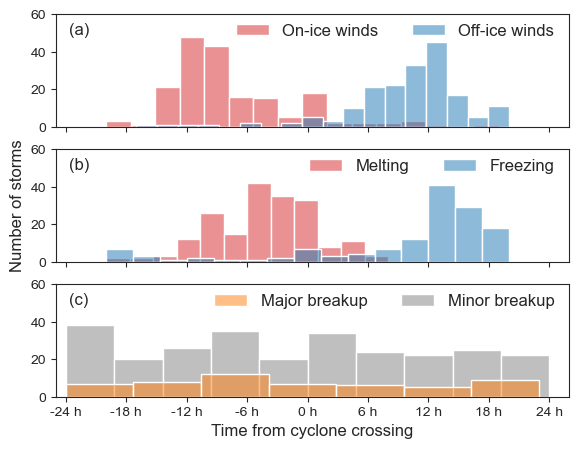

In [93]:
# Convert 'relative_time' to timedelta while handling invalid formats
def safe_to_timedelta(series):
    try:
        return pd.to_timedelta(series)
    except ValueError:
        return pd.to_timedelta(series, errors='coerce')

# Use the safe conversion function to avoid errors
data['relative_time'] = safe_to_timedelta(data['relative_time'])

# Filter out any NaT (Not a Time) values that couldn't be converted
# data = data.dropna(subset=['relative_time'])

fig, axes = plt.subplots(3, 1, figsize=(plot_settings.width, plot_settings.height), sharex=True, sharey=True)
zorder = [1, 0, 1]
cmap = ['tab:red', 'tab:blue', 'tab:red', 'tab:blue', 'tab:orange', 'gray']
vars_pairs = [['on_ice', 'off_ice'], ['melting', 'freezing'], ['breakup', 'no_event']]
labels_pairs = [['On-ice winds', 'Off-ice winds'], ['Melting', 'Freezing'], ['Major breakup', 'Minor breakup']]
alpha = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]

for i, (event_pair, label_pair) in enumerate(zip(vars_pairs, labels_pairs)):
    for j, (event, label) in enumerate(zip(event_pair, label_pair)):
        if i < 2:
            # Plot on_ice/off_ice, melting/freezing without filtering
            sns.histplot(
                -pd.to_timedelta(data['relative_time'][data['event'] == event]).dt.total_seconds() // 3600, 
                ax=axes[i], 
                color=cmap[j], 
                zorder=1, 
                alpha=alpha[j], 
                kde=False,  
                label=label,  # Add label for the legend
                edgecolor=None
            )
        else:
            # For breakup and no_event: filter relative time between -24 and 24 hours
            relative_time_hours = -pd.to_timedelta(data_wave['relative time'][data_wave['event'] == event]).dt.total_seconds() // 3600
            filtered_time = relative_time_hours[(relative_time_hours >= -24) & (relative_time_hours <= 24)]

            # Plot histogram with filtered data
            cmap = ['tab:orange', 'gray']
            zorder = [2, 0]
            sns.histplot(
                filtered_time, 
                ax=axes[i], 
                color=cmap[j], 
                zorder=zorder[j], 
                alpha=alpha[j], 
                kde=False, 
                label=label,  # Add label for the legend
                edgecolor=None
            )
        axes[i].legend(loc='upper right', ncol=2, bbox_to_anchor=(1.0, 1.05), fancybox=False, framealpha=0, facecolor=None, edgecolor=None)

    # Add a legend for each subplot
    # axes[i].legend(loc='upper right')

    # Add text label for the subplot
    axes[i].text(
        plot_settings.label_x, plot_settings.label_y-0.05, f'({chr(97 + i)})', 
        transform=axes[i].transAxes, 
        fontsize=plot_settings.fontsize, 
        verticalalignment='top', 
        horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.3, edgecolor='none', boxstyle='round,pad=0.3'),
        zorder=3
    )
    axes[i].set_ylabel('')
axes[1].set_ylabel('Number of storms')

# Set common x-axis properties for the last subplot
axes[-1].set_xticks(np.arange(-24, 25, 6))
axes[-1].set_xlim(-25, 26)
axes[-1].set_xticklabels([f'{int(t)} h' for t in np.arange(-24, 25, 6)])
axes[-1].set_xlabel('Time from cyclone crossing')
axes[-1].set_ylim(0, 60)
# Adjust subplot layout
fig.subplots_adjust(hspace=0.2, wspace=0.1)

# Save the figure
plt.savefig(savepath + 'split_of_on_off_winds_melting_freezing_wave_combined.pdf', dpi=300, transparent=False, pad_inches=0.1)
plt.show()

## Dynamics seasonally

In [48]:
df_dynamics = pd.read_csv(netcdfpath+'csvs/dynamics_extravars_events_0ms_n_263.csv')
df_dynamics
# for var in colvars:
    # df_dynamics[var] = df_dynamics[var].apply(lambda x: x.item() if isinstance(x, np.ndarray) else x)
# data = df_dynamics[df_dynamics['event'] != 'reference']
data = df_dynamics
data['delta_ice_edge_km'] = data['delta_ice_edge']*111

time_col = 'time'
# Ensure 'time' is in datetime format
data[time_col] = pd.to_datetime(data[time_col])
cols_to_sum = [col for col in data.columns if col not in ['track', 'event', time_col]]

data = data.groupby(['track', 'event']).agg({
    **{col: 'sum' for col in cols_to_sum},  # Apply 'sum' to all columns except 'time'
    time_col: 'median'  # Apply 'median' to the 'time' column
}).reset_index()

data_tmp = data.groupby(['track', 'event']).agg({
    **{col: 'sum' for col in cols_to_sum},  # Apply 'sum' to all columns except 'time'
    time_col: 'median'  # Apply 'median' to the 'time' column
}).reset_index()


data['time'] = pd.to_datetime(data['time'])
data['month'] = data['time'].dt.month
data['day-month'] = data['time'].dt.strftime('%d-%m')  # Formats as 'day-month'

data_tmp['time'] = pd.to_datetime(data_tmp['time'])
data_tmp['month'] = data_tmp['time'].dt.month
data_tmp['day-month'] = data_tmp['time'].dt.strftime('%d-%m')  # Formats as 'day-month'

data['time'] = pd.to_datetime(data['time'])
data['month'] = data['time'].dt.month
data['month'] = data['month'].astype(str).str.zfill(2)  # Add leading zero to single-digit months
data['month'] = pd.to_datetime('15-' + data['month'] + '-2018', format='%d-%m-%Y')
data['day-month'] = data['time'].dt.strftime('%d-%m')  # Formats as 'day-month'
data['day-month'] = pd.to_datetime(data['day-month'] + '-2018', format='%d-%m-%Y')

data_tmp['time'] = pd.to_datetime(data_tmp['time'])
data_tmp['month'] = data_tmp['time'].dt.month
data_tmp['month'] = data_tmp['month'].astype(str).str.zfill(2)  # Add leading zero to single-digit months
# data_tmp['month'] = pd.to_datetime('15-' + data_tmp['month'] + '-2018', format='%d-%m-%Y')
data_tmp['day-month'] = data_tmp['time'].dt.strftime('%d-%m')  # Formats as 'day-month'
data_tmp['day-month'] = pd.to_datetime(data_tmp['day-month'] + '-2018', format='%d-%m-%Y')

monthly_mean = data.groupby('month').mean()
monthly_std = data.groupby('month').std()

palette = cmo.balance

# Convert the 'month' column to integers, handling potential issues
data_tmp['month'] = pd.to_numeric(data_tmp['month'], errors='coerce').fillna(0).astype(int)
data_tmp['month'] 

TypeError: agg function failed [how->mean,dtype->object]

In [49]:
df_on_ice = data_tmp[data_tmp['event'] == 'on_ice']
df_off_ice = data_tmp[data_tmp['event'] == 'off_ice']

# Merge the two dataframes on 'track' to align the 'on_ice' and 'off_ice' rows
df_merged = pd.merge(df_on_ice, df_off_ice, on='track', suffixes=('_on', '_off'))

# Subtract the relevant columns to get the difference between 'on_ice' and 'off_ice'
df_merged['delta_ice_edge_diff'] =  df_merged['delta_ice_edge_km_on'] - df_merged['delta_ice_edge_km_off']
# df_merged['delta_ice_edge_per_hour_diff'] = df_merged['delta_ice_edge_per_hour_on'] - df_merged['delta_ice_edge_per_hour_off']
df_merged['delta_miz_width_diff'] =  df_merged['delta_miz_width_on'] - df_merged['delta_miz_width_off']
# df_merged['delta_miz_width_per_hour_diff'] = df_merged['delta_miz_width_per_hour_on'] - df_merged['delta_miz_width_per_hour_off']



INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/jobfs/152851777.gadi-pbs/ipykernel_2637350/3592108701.py:76: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.pointplot(
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the approp

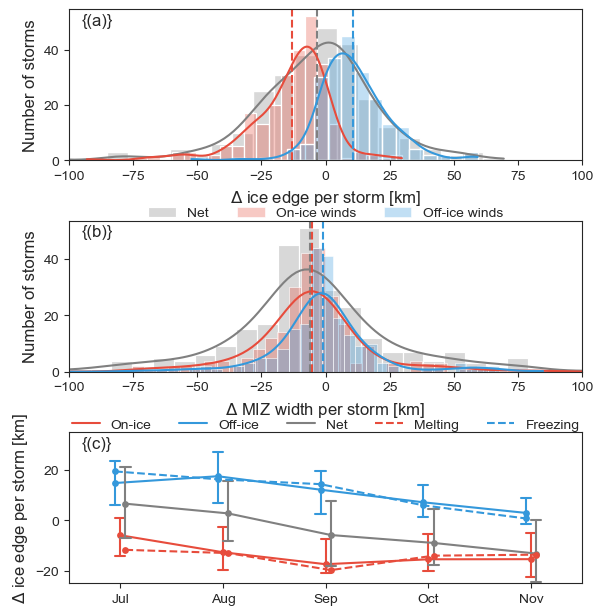

In [60]:
import matplotlib.lines as mlines
dyn_events = ['on_ice', 'off_ice', 'reference']  # Events that should have error bars
thermo_events = ['melting', 'freezing']  # Events without error bars
reference_event = ['reference']
linewidth = 1.5
alpha = 0.3
THERMO_FLAG = True

# Create the plot figure
fig, axes = plt.subplots(3, 1, figsize=(plot_settings.width, plot_settings.height*1.5), sharex=False)

ax = axes[0]
# Second histogram: Reference delta_ice_edge_km with KDE
plot_data = data_tmp[data_tmp['event'] == 'reference']['delta_ice_edge_km'].dropna()
sns.histplot(plot_data, ax=ax, kde=True, color='gray', label='Net', alpha=alpha, edgecolor=None)
ax.axvline(plot_data.mean(), color='gray', linestyle='--')

plot_data = data_tmp[data_tmp['event'] == 'on_ice']['delta_ice_edge_km'].dropna()
sns.histplot(plot_data, ax=ax, kde=True, color='#e74c3c', label='On-ice winds', alpha=alpha, edgecolor=None)
ax.axvline(plot_data.mean(), color='#e74c3c', linestyle='--')

plot_data = data_tmp[data_tmp['event'] == 'off_ice']['delta_ice_edge_km'].dropna()
sns.histplot(plot_data, ax=ax, kde=True, color='#3498db', label='Off-ice winds', alpha=alpha, edgecolor=None)
ax.axvline(plot_data.mean(), color='#3498db', linestyle='--')
# Add a vertical line at 0 for reference
# ax.axvline(0, color='black', linestyle='--')
ax.set_xlim(-100,100)

ax.set_xlabel('$\Delta$ ice edge per storm [km]')
ax.set_ylabel('Number of storms')

# Add a legend



ax = axes[1]
plot_data = data_tmp[data_tmp['event'] == 'reference']['delta_miz_width'].dropna()
sns.histplot(plot_data, ax=ax, kde=True, color='gray', label='Net', alpha=alpha, edgecolor=None)
ax.axvline(plot_data.mean(), color='gray', linestyle='--')

plot_data = data_tmp[data_tmp['event'] == 'on_ice']['delta_miz_width'].dropna()
sns.histplot(plot_data, ax=ax, kde=True, color='#e74c3c', label='On-ice winds', alpha=alpha, edgecolor=None)
ax.axvline(plot_data.mean(), color='#e74c3c', linestyle='--')

plot_data = data_tmp[data_tmp['event'] == 'off_ice']['delta_miz_width'].dropna()
sns.histplot(plot_data, ax=ax, kde=True, color='#3498db', label='Off-ice winds', alpha=alpha, edgecolor=None)
ax.axvline(plot_data.mean(), color='#3498db', linestyle='--')
ax.set_xlim(-100,100)

ax.set_xlabel('$\Delta$ MIZ width per storm [km]')
ax.set_ylabel('Number of storms')

ax.legend(loc='center', bbox_to_anchor=(0.5, 1.05), ncol=3, fontsize=10, fancybox=False, framealpha=0, facecolor=None, edgecolor=None)

ax = axes[-1]



# palette = cmo.balance
palette = ["#3498db", "#e74c3c", "gray"]
# Convert the 'month' column to integers, handling potential issues
data_tmp['month'] = pd.to_numeric(data_tmp['month'], errors='coerce').fillna(0).astype(int)
data_tmp['month'] 

vars = ['delta_ice_edge_km']
# Loop over each axis and plot the data
for i, ax in enumerate(axes[2:]):
    # Plot events with error bars
    sns.pointplot(
        x='month', y=vars[i], hue='event', data=data_tmp[data_tmp['event'].isin(dyn_events)].sort_values(by='event'), 
        palette=palette, legend=False, ax=ax, errorbar=("pi", 50), capsize=.1, dodge=0.1, linestyles='-', linewidth=linewidth,
    )

    # Plot events without error bars
    if THERMO_FLAG:
        sns.pointplot(
            x='month', y=vars[i], hue='event', data=data_tmp[data_tmp['event'].isin(thermo_events)].sort_values(by='event'), 
            palette=palette, legend=False, ax=ax, errorbar=None, capsize=.1, dodge=0.1, linestyles='--', linewidth=linewidth,
        )
    # ax.set_ylabel(y_labels[i])
    
    if i == len(axes) - 1:
        ax.set_xlabel('', fontsize=plot_settings.fontsize)
axes[-1].set_xlabel('')



custom_handles = [
    mlines.Line2D([0], [0], color='#e74c3c', linestyle='-', linewidth=linewidth, label='On-ice'),
    mlines.Line2D([0], [0], color='#3498db', linestyle='-', linewidth=linewidth, label='Off-ice'),
    mlines.Line2D([0], [0], color='gray', linestyle='-', linewidth=linewidth, label='Net'),
    mlines.Line2D([0], [0], color='#e74c3c', linestyle='--', linewidth=linewidth, label='Melting'),
    mlines.Line2D([0], [0], color='#3498db', linestyle='--', linewidth=linewidth, label='Freezing'),
]

# Add custom legend above the plot
fig.subplots_adjust(hspace=0.2, wspace=0.0)
axes[2].legend(handles=custom_handles, loc='center', bbox_to_anchor=(0.5, 1.05), 
               ncol=5, fancybox=False, frameon=False, title='', fontsize=10, framealpha=0, facecolor=None, edgecolor=None)

axes[2].set_ylim(-25, 35)

fig.subplots_adjust(hspace=0.4)

for i, ax in enumerate(axes):
    ax.text(plot_settings.label_x, plot_settings.label_y, f'({chr(97 + i)})', 
            transform=ax.transAxes, 
            fontsize=plot_settings.fontsize, 
            verticalalignment='top', 
            horizontalalignment='left',
            bbox=dict(facecolor='white', alpha=0.15, edgecolor='none', boxstyle='round,pad=0.1'),
            zorder=3)


axes[-1].set_ylabel('$\Delta$ ice edge per storm [km]')
axes[-1].set_xticklabels(['Jul', 'Aug', 'Sep', 'Oct', 'Nov'])
plt.savefig(savepath + 'dynamics_dist_seasonality.png', dpi=300, transparent=False)
plt.savefig(savepath + 'dynamics_dist_seasonality.pdf')
plt.show()

In [69]:
netcdfpath

'/home/566/nd0349/Code-MIZ-cyclones/data/'

## Thermodynamics seasonally 

In [59]:
data = pd.read_csv(netcdfpath + 'csvs/dynamics_area_events_n274.csv')
data = data[data['event'] != 'Reference']

data.head()

track                 time    event      relative time  duration  \
0  201519169  2015-07-01 17:00:00  off_ice  -1 days +12:00:00        21   
1  201519169  2015-07-03 00:00:00  off_ice  -2 days +05:00:00         9   
2  201519169  2015-07-02 11:30:00   on_ice  -2 days +17:30:00        16   
3  201519169  2015-07-01 09:30:00  melting  -1 days +19:30:00        10   
4  201519169  2015-07-02 19:30:00  melting  -2 days +09:30:00        10   

   delta_ice_edge  delta_ice_edge_sum  delta_miz_width  delta_miz_width_sum  \
0        0.006206            0.130325         1.200051            25.201080   
1        0.012205            0.109844         1.094223             9.848007   
2        0.005579            0.089256         0.845425            13.526794   
3        0.000760            0.006840         1.050005             9.450043   
4        0.010985            0.109852         1.056723            10.567230   

   delta_miz_width_signed  ...  congel_miz  iage_miz   sst_miz  \
0               -8.182098  ...    0.060373  0.099146 -1.896633   
1                7.096054  ...    0.006935  0.103908 -1.897171   
2              -11.997192  ...    0.029230  0.104201 -1.899373   
3               -9.450043  ...    0.024114  0.098229 -1.900012   
4                6.376831  ...    0.001094  0.104518 -1.898946   

   wave_sig_ht_miz  dafsd_wave_ra     meltt_miz  meltl_miz  meltb_miz  \
0         1.720645      -0.811286  5.980540e-32   0.007406   0.345796   
1         0.193720      -0.005191  2.341219e-23   0.010088   0.535087   
2         0.654319      -0.062567  6.411864e-23   0.001601   0.110912   
3         1.940411      -2.262356  6.603772e-32   0.000721   0.252469   
4         0.085804      -0.102642  1.236608e-22   0.003482   0.238791   

   frzmlt_miz    sss_miz  
0  -28.558386  33.923801  
1  -42.572763  33.922567  
2   -7.527665  33.923687  
3   -5.525604  33.925419  
4  -18.034559  33.923595  

[5 rows x 35 columns]

In [60]:
data['month'] = pd.to_datetime(data['time']).dt.month
data['month'] = data['month'].astype(str).str.zfill(2)  # Add leading zero to single-digit months
data['month'] = pd.to_datetime('15-' + data['month'] + '-2018', format='%d-%m-%Y')

In [61]:
palette = sns.color_palette(["#e74c3c", "gray", "#3498db"])
data['total_melt'] = data['meltb_miz'] + data['meltt_miz']  + data['meltl_miz']  
data = data[data['total_melt'] >= -100]
data = data[data['meltb_miz'] <= 100]
data = data[data['meltl_miz'] <= 100]
data = data[data['meltt_miz'] <= 100]
data['total_growth'] = data['congel_miz'] + data['frazil_miz']

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/jobfs/152851777.gadi-pbs/ipykernel_2817038/1268886880.py:27: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.pointplot(
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the approp

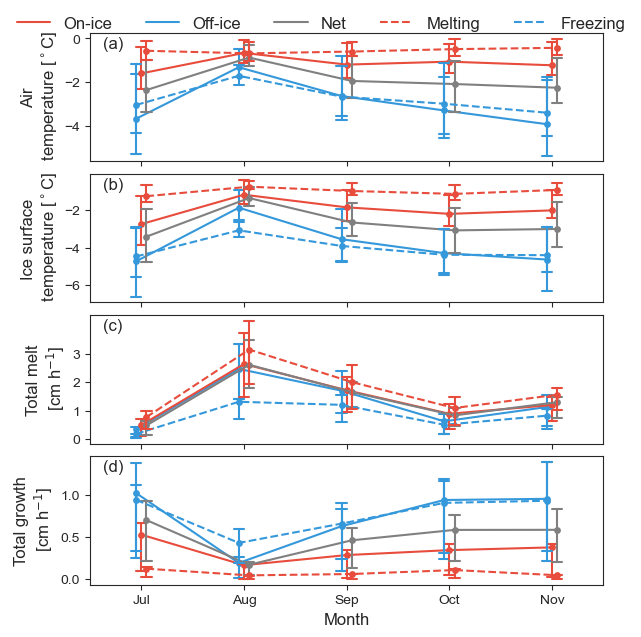

In [62]:
from matplotlib.lines import Line2D

data['delta_ice'] = data['total_growth']  - data['total_melt'] 
palette = sns.color_palette(["#3498db", "#e74c3c", "gray"])

fig, axes = plt.subplots(4, 1, figsize=(plot_settings.width, plot_settings.height * 1.5), sharex=True)

# Define the variables and labels
vars = ['Tair_miz', 'Tsfc_miz', 'total_melt', 'total_growth']
y_labels = ['Air\n temperature [$^\circ$C]', 'Ice surface\n temperature [$^\circ$C]', 'Total melt\n [cm h$^{-1}$]', 'Total growth\n [cm h$^{-1}$]']
titles = ['Air Temperature over MIZ', 'Surface Temperature over MIZ', 'Total melt', 'Total growth']

linewidth = 1.5

# Define the linestyle and palette for different events
dyn_events = ['on_ice', 'off_ice', 'reference']  # Events that should have error bars
thermo_events = ['melting', 'freezing']  # Events without error bars
reference_event = ['reference']
# Loop over each axis and plot the data
for i, ax in enumerate(axes):
    # Plot events with error bars
    sns.pointplot(
        x='month', y=vars[i], hue='event', data=data[data['event'].isin(dyn_events)].sort_values(by='event'), 
        palette=palette, legend=False, ax=ax, errorbar=("pi", 50), capsize=.1, dodge=0.1, linestyles='-', linewidth=linewidth,
    )

    sns.pointplot(
        x='month', y=vars[i], hue='event', data=data[data['event'].isin(thermo_events)].sort_values(by='event'), 
        palette=palette, legend=False, ax=ax, errorbar=("pi", 50), capsize=.1, dodge=0.1, linestyles='--', linewidth=linewidth,
    )

    # Plot events without error bars
    # sns.pointplot(
    #     x='month', y=vars[i], hue='event', data=data[data['event'].isin(thermo_events)].sort_values(by='event'), 
    #     palette=palette, legend=False, ax=ax, errorbar=None, capsize=.1, dodge=0.1, linestyles='--', linewidth=linewidth,
    # )
    ax.set_ylabel(y_labels[i])
    
    if i == len(axes) - 1:
        ax.set_xlabel('', fontsize=plot_settings.fontsize)

# Custom legend handles
custom_handles = [
    Line2D([0], [0], color='#e74c3c', linestyle='-', linewidth=linewidth, label='On-ice'),
    Line2D([0], [0], color='#3498db', linestyle='-', linewidth=linewidth, label='Off-ice'),
    Line2D([0], [0], color='gray', linestyle='-', linewidth=linewidth, label='Net'),
    Line2D([0], [0], color='#e74c3c', linestyle='--', linewidth=linewidth, label='Melting'),
    Line2D([0], [0], color='#3498db', linestyle='--', linewidth=linewidth, label='Freezing'),
]

# Add custom legend above the plot
fig.subplots_adjust(top=0.85, hspace=0.1, wspace=0.0)
axes[0].legend(handles=custom_handles, loc='upper center', bbox_to_anchor=(0.45, 1.25), 
               ncol=5, fancybox=True, frameon=False)

axes[-1].set_xticklabels(['Jul', 'Aug', 'Sep', 'Oct', 'Nov'])

axes[2].set_yticks([0, 1, 2, 3])

for i, ax in enumerate(axes):
    ax.text(plot_settings.label_x, plot_settings.label_y, f'({chr(97 + i)})', 
            transform=ax.transAxes, 
            fontsize=plot_settings.fontsize, 
            verticalalignment='top', 
            horizontalalignment='left',
            bbox=dict(facecolor='gray', alpha=0.0, edgecolor='none', boxstyle='round,pad=0.3'),
            zorder=3)
    ax.tick_params(axis='x', rotation=0)
    sns.despine(trim=False, left=False, right=False, top=False, ax=ax)
axes[-1].set_xlabel('Month')
plt.savefig(savepath + 'thermo_seasonality.png', dpi=300, transparent=False)
plt.savefig(savepath + 'thermo_seasonality.pdf', dpi=300, transparent=False)
plt.show()

## Waves seasonally

In [57]:
df_breakup = pd.read_csv(netcdfpath+'csvs/breakup_n_346.csv')

cmap = [sns.color_palette("colorblind", 2)[1], 'tab:gray']
norm = Normalize(vmin=1, vmax=2)


data = df_breakup#[df_breakup['event'] != 'reference']

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Mean of breakup is 42.6085320183864 km
Median of breakup is 31.315933227539062 km
MIZ width of breakup is 124.83653132120767 km
Mean of no_event is -20.138512921066923 km
Median of no_event is -11.77166748046875 km
MIZ width of no_event is 122.65503041379087 km


/jobfs/152851777.gadi-pbs/ipykernel_2817038/2228903448.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_line.set(xlabel='', xticklabels=['Jul', 'Aug', 'Sep', 'Oct', 'Nov'],


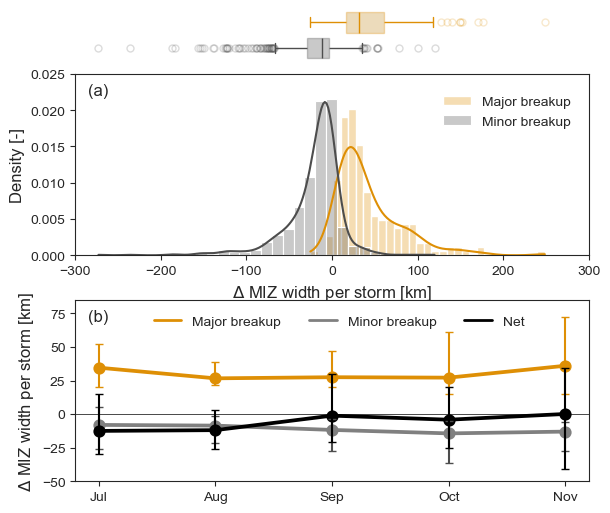

In [58]:

custom_labels = ['Major breakup', 'Minor breakup'] 

# Assuming 'data' contains your DataFrame and 'event' is your hue variable
y = "delta_miz_width_signed"
bins = 31  # Set the desired number of bins


# Create a discretized colormap with 12 colors
# cmap = sns.color_palette("colorblind", 2)
cmap = [sns.color_palette("colorblind", 2)[1], [0.3, 0.3, 0.3]]
cmap_dict = {'breakup': sns.color_palette("colorblind", 2)[1],
             'no_event': [0.3, 0.3, 0.3],
             'reference': [0,0,0]
             
}
unique_hues = ['breakup', 'no_event'] #data['event'].unique()[::-1]
norm = Normalize(vmin=1, vmax=len(unique_hues))

fig, (ax_box, ax_hist, ax_line) = plt.subplots(3, sharex=False, figsize=(plot_settings.width, plot_settings.height),
                                    gridspec_kw={"height_ratios": (.05, .45, .45)})
ax_box.axis('off')
ax_box = fig.add_subplot(711)
ax_box.axis('off')
for i,hue in enumerate(unique_hues):
    color = cmap[i % 2] 
    subset = data[data['event'] == hue]
    
    # Plot the histogram with consistent bins and density normalization
    sns.histplot(subset[y], ax=ax_hist, kde=True, edgecolor=None, alpha=0.3, label=custom_labels[i], stat='density', bins=bins, color=color, zorder=i)

    sns.boxplot(y=subset['event'], x=subset[y], ax=ax_box, color=color, 
                boxprops=dict(edgecolor=color, linewidth=1, alpha=.3),
                whiskerprops=dict(color=color, linewidth=1, alpha=1),  # Customize the whiskers
                capprops=dict(color=color, linewidth=1, alpha=1),  # Customize the caps
                medianprops=dict(color=color, linewidth=1, alpha=1),  # Customize the median line
                flierprops=dict(marker='o', color=color,  markeredgecolor=color, markersize=5, alpha=0.2)
               )  # Customize the outliers
    print(f"Mean of {subset['event'].iloc[0]} is {np.mean(subset[y])} km")
    print(f"Median of {subset['event'].iloc[0]} is {np.median(subset[y])} km")
    # print(f"Mean of {subset['event'].iloc[0]} is {np.mean(subset[y])} km")
    print(f"MIZ width of {subset['event'].iloc[0]} is {np.median(subset['miz_width'])} km")
    
ax_hist.set_xlabel("$\Delta$ MIZ width per storm [km]")
ax_hist.set_ylabel("Density [-]")
ax_hist.set_ylim([0, 0.025])
ax_hist.legend(title="", title_fontsize='10', fontsize='10', bbox_to_anchor=(0.99, 0.95), fancybox=False, framealpha=0, facecolor=None, edgecolor=None)

label_x = 0.025
label_y = 0.975
fontsize = 12

# ax_box.set(yticks=[])
sns.despine(ax=ax_hist, right=False, top=False)
sns.despine(ax=ax_box, left=False, top=False, right=False,)
# fig.subplots_adjust(hspace=-0.5, wspace=0.1)
for ax in [ax_box, ax_hist]:
    ax.set_xlim([-300, 300])

cmap = [sns.color_palette("colorblind", 2)[1], [0.5, 0.5, 0.5], 'black']
data['month'] = pd.to_datetime(data['time']).dt.month
# sns.pointplot(ax=ax_line, data=data, x='month', y='delta_miz_width_signed', hue='event', palette=cmap,  capsize=.1, dodge=0.15, linestyles='-')

summary = data.groupby(['month', 'event']).agg(
    median=('delta_miz_width_signed', 'median'),
    lower=('delta_miz_width_signed', lambda x: x.quantile(0.25)),
    upper=('delta_miz_width_signed', lambda x: x.quantile(0.75))
).reset_index()

# Add a column for error bars (e.g., IQR)
summary['yerr'] = summary['upper'] - summary['lower']

# Plot the pointplot with medians
sns.pointplot(
    ax=ax_line,
    data=summary,
    x='month',
    y='median',
    hue='event',
    palette=cmap,
    # dodge=0.15,
    linestyles='-',
    capsize=0.1
)

# Manually add error bars at the correct positions
# Get the positions of the points on the x-axis after applying dodge
dodge_value = 0.0
unique_months = summary['month'].unique()
for i, event in enumerate(summary['event'].unique()):
    event_data = summary[summary['event'] == event]
    for j, month in enumerate(unique_months):
        median_value = event_data[event_data['month'] == month]['median']
        lower_bound = event_data[event_data['month'] == month]['lower']
        upper_bound = event_data[event_data['month'] == month]['upper']
        
        if not median_value.empty:
            # Calculate x position accounting for dodge
            x_pos = j - dodge_value / 2 + i * dodge_value
            
            # Plot error bars
            ax_line.errorbar(
                x_pos,
                median_value.values[0],
                yerr=[[median_value.values[0] - lower_bound.values[0]], 
                      [upper_bound.values[0] - median_value.values[0]]],
                fmt='none',
                color=cmap_dict[event],
                capsize=3
            )



ax_line.set(xlabel='', xticklabels=['Jul', 'Aug', 'Sep', 'Oct', 'Nov'],
            ylabel='$\Delta$ MIZ width per storm [km]', ylim=(-50, 80))

# fig.subplots_adjust(hspace=0.4)
fig.subplots_adjust(top=0.95, bottom=0.0, hspace=0.35)  # Adjust top, bottom and vertical spacing

for i, ax in enumerate([ax_hist, ax_line]):
    ax.text(plot_settings.label_x, plot_settings.label_y-0.025, f'({chr(97 + i)})', 
            transform=ax.transAxes, 
            fontsize=plot_settings.fontsize, 
            verticalalignment='top', 
            horizontalalignment='left',
            bbox=dict(facecolor='white', alpha=0.3, edgecolor='none', boxstyle='round,pad=0.3'),
            zorder=3)

cmap = [sns.color_palette("colorblind", 2)[1], [0.5, 0.5, 0.5], 'black']

linewidth = 2
custom_handles = [
    Line2D([0], [0], color=cmap[0], linestyle='-', linewidth=linewidth, label='Major breakup'),
    Line2D([0], [0], color=cmap[1], linestyle='-', linewidth=linewidth, label='Minor breakup'),
    Line2D([0], [0], color=cmap[2], linestyle='-', linewidth=linewidth, label='Net'),
]
ax_line.legend(handles=custom_handles, loc='upper right', bbox_to_anchor=(0.9, 0.985), 
               ncol=3, fontsize=10, fancybox=False, framealpha=0, facecolor=None, edgecolor=None)
ax_line.axhline(0, color='k', linewidth=0.5)
ax_line.set_ylim(-50, 85)
plt.savefig(savepath + 'pdf_boxplot_miz_width_signed.png', dpi=300, transparent=False)
plt.savefig(savepath + 'pdf_boxplot_miz_width_signed.pdf')
# Show plot
plt.show()

## Explaining breakup events

In [54]:
# def append_to_dataframe(dataframe, row_data):
#     new_row = pd.DataFrame([row_data], columns=dataframe.columns)
#     dataframe = pd.concat([dataframe, new_row], ignore_index=True)
#     return dataframe

# ice_edge_path = '/g/data/gv90/nd0349/antarctic-cyclones/' + 'ice-edge/'
# ice_edge_identifier = '_ice_edge.nc'
# directory_path = ice_edge_path + '*' + ice_edge_identifier
# files = sorted(glob.glob(directory_path))

# area_path = netcdfpath + 'area/'
# area_identifier = '_area.nc'
# # xr.open_dataset('/Volumes/NoahDay1TB/antarctic-cyclones/area/201519169_area.nc')['wave_sig_ht_interior'].isel(radius=2).plot()

# colvars = ['time', 'track', 'relative time', 'event',
#            'miz_width_init', 'miz_width_ave', 'miz_width_max', 'delta_miz_width', 'delta_miz_width_signed',
#             'ice_edge_init', 'ice_edge_ave', 'ice_edge_max', 'delta_ice_edge', 'delta_ice_edge_signed',
#             'wave_sig_ht_init', 'wave_sig_ht_ave', 'wave_sig_ht_max', 'delta_wave_sig_ht', 'delta_wave_sig_ht_signed',
#             'dafsd_wave_ra_init', 'dafsd_wave_ra_ave', 'dafsd_wave_ra_max', 'delta_dafsd_wave_ra', 'delta_dafsd_wave_ra_signed',
#             # 'wave_sig_ht_miz_init', 'wave_sig_ht_miz_ave', 'wave_sig_ht_miz_max', 'wave_sig_ht_miz_ra', 'wave_sig_ht_miz_signed',
#             # 'wave_sig_ht_interior_init', 'wave_sig_ht_interior_ave', 'wave_sig_ht_interior_max', 'delta_wave_sig_ht_interior', 'delta_wave_sig_ht_interior_signed',
#             # 'fsdrad_miz_init', 'fsdrad_miz_ave', 'fsdrad_miz_max', 'fsdrad_miz_ra', 'delta_fsdrad_miz_signed',
#             # 'fsdrad_interior_init', 'fsdrad_interior_ave', 'fsdrad_interior_max', 'fsdrad_interior_ra', 'delta_fsdrad_interior_signed',
#             # 'aice_miz_init', 'aice_miz_ave', 'aice_miz_max', 'aice_miz_ra', 'delta_aice_miz_signed',
#             # 'aice_interior_init', 'aice_interior_ave', 'aice_interior_max', 'aice_interior_ra', 'delta_aice_interior_signed',
# ]
#            #'delta_ice_edge', 'delta_miz_width', 'delta_miz_width_sum', 'delta_miz_width_signed','dist', 'psl', 'ice_edge', 'ice_edge_std', 'uvel', 'vvel', 'uatm', 'vatm', 
#            #'Tair', 'Tsfc', 'daicedt', 'frazil', 'congel', 'iage', 'sst', 'wave_sig_ht', 'dafsd_wave_ra', 'miz_width', 'miz_width_std']
# df_breakup = pd.DataFrame(columns=colvars)

# storm_proximity = []
# min_psl = []

# THRESHOLD_STORM_PROXIMITY = 600 # 600/110 # 600 km from Hepworth, converted to deg. latitude
# THRESHOLD_DAFSD_WAVE_RA = -10.0 # m/h WAS -20
# THRESHOLD_BREAKUP_TIME = 6 # Hours
# ROLLING_TIME = 1
# width = 2


# def addVarQuantities(ds, var, tmp_row, event_flag_tmp):
#     first_idx = np.argmax(event_flag_tmp) 
#     delta_var = ds[var].isel(radius=width).diff(dim='time')
#     tmp_row.append(ds[var].isel(radius=width).values[first_idx])
#     tmp_row.append(ds[var].isel(radius=width).values[event_flag_tmp].mean())
#     tmp_row.append(ds[var].isel(radius=width).values[event_flag_tmp].max())
#     tmp_row.append(abs(delta_var[event_flag_tmp[1:]]).sum().values)
#     tmp_row.append((delta_var[event_flag_tmp[1:]]).sum().values)
#     return tmp_row

# for file in tqdm(files[:]):
#     variables_to_drop = ['breakup_event', 'breakup_event_mask']
#     ds = xr.open_mfdataset(file, combine='by_coords', drop_variables=variables_to_drop)
#     track_number = file.split('/')[-1].split('_')[0]

#     # file_area = area_path + track_number + area_identifier
#     # if os.path.exists(file_area):
#     #     ds_area = xr.open_mfdataset(file_area, combine='by_coords', drop_variables=variables_to_drop)
#     # else:
#     #     #print(file_area)
#     #     continue

#     if np.all(np.isnan(ds['psl'].isel(radius=width).values)):
#         continue
#     min_psl_idx = ds['psl'].isel(radius=width).argmin().values
#     # Skip if the cyclone doesn't come close
#     if abs(ds['dist'].isel(radius=width)).min().values > THRESHOLD_STORM_PROXIMITY:
#         print('storm too far away')
#         continue

#     flg_cyclone_dist = ds['psl'].isel(radius=width).values < ds['psl'].isel(radius=width).mean().values #abs(ds['dist'].isel(radius=width).values) < THRESHOLD_STORM_PROXIMITY

#     delta_miz_width = ds['miz_width'].isel(radius=width).diff(dim='time')
#     delta_ice_edge = ds['ice_edge'].isel(radius=width).diff(dim='time')

#     # Breakup event
#     event = (ds['dafsd_wave_ra'].isel(radius=width)).rolling(time=ROLLING_TIME).mean()
#     event_idx = event < THRESHOLD_DAFSD_WAVE_RA
#     events_array = getEachBreakupIdx(event_idx)
#     if events_array:
#         # print('Breakup!')
#         major_events_array = getMajorEvents(events_array, time_threshold=THRESHOLD_BREAKUP_TIME)
#         if major_events_array:
#             event_flag = np.sum(major_events_array, axis=0) != 0
#             change_during_breakup = delta_miz_width[event_flag[1:]].sum().values
#             change_not_during_breakup = delta_miz_width[~event_flag[1:]].sum().values

#             for i_event in range(np.shape(major_events_array)[0]):
#                 event_flag_tmp = major_events_array[i_event]
#                 # colvars = ['time', 'event', 'relative time', 'delta_ice_edge', 'delta_miz_width',
#                 tmp_row = []
#                 tmp_row = [ds['time'][event_flag_tmp].mean().values]
#                 tmp_row.append(track_number)
#                 tmp_row.append(ds['time'].isel(time=ds['psl'].isel(radius=width).argmin().values).values - ds['time'][event_flag_tmp].mean().values)
#                 tmp_row.append('major_breakup')
# #                'miz_width_init', 'miz_width_ave', 'miz_width_max', 'delta_miz_width', 'delta_miz_width_signed',
                
#                 # Init var
#                 tmp_row = addVarQuantities(ds, 'miz_width', tmp_row, event_flag_tmp)
#                 tmp_row = addVarQuantities(ds, 'ice_edge', tmp_row, event_flag_tmp)
#                 tmp_row = addVarQuantities(ds, 'wave_sig_ht', tmp_row, event_flag_tmp)
#                 tmp_row = addVarQuantities(ds, 'dafsd_wave_ra', tmp_row, event_flag_tmp)
#                 # tmp_row = addVarQuantities(ds_area, 'wave_sig_ht_miz', tmp_row, event_flag_tmp)
#                 # tmp_row = addVarQuantities(ds_area, 'wave_sig_ht_interior', tmp_row, event_flag_tmp)
#                 # tmp_row = addVarQuantities(ds_area, 'fsdrad_miz', tmp_row, event_flag_tmp)
#                 # tmp_row = addVarQuantities(ds_area, 'fsdrad_interior', tmp_row, event_flag_tmp)
#                 # tmp_row = addVarQuantities(ds_area, 'aice_miz', tmp_row, event_flag_tmp)
#                 # tmp_row = addVarQuantities(ds_area, 'aice_interior', tmp_row, event_flag_tmp)

#                 df_breakup = append_to_dataframe(df_breakup, tmp_row)


#     # Minor breakup event
#     event = (ds['dafsd_wave_ra'].isel(radius=width)).rolling(time=ROLLING_TIME).mean()
#     event_idx = event > THRESHOLD_DAFSD_WAVE_RA
#     events_array = getEachBreakupIdx(event_idx)
#     if events_array:
#         # print('Breakup!')
#         major_events_array = getMajorEvents(events_array, time_threshold=1)
#         if major_events_array:
#             event_flag = np.sum(major_events_array, axis=0) != 0
#             change_during_breakup = delta_miz_width[event_flag[1:]].sum().values
#             change_not_during_breakup = delta_miz_width[~event_flag[1:]].sum().values

#             for i_event in range(np.shape(major_events_array)[0]):
#                 event_flag_tmp = major_events_array[i_event]
#                 # colvars = ['time', 'event', 'relative time', 'delta_ice_edge', 'delta_miz_width',
#                 tmp_row = []
#                 tmp_row = [ds['time'][event_flag_tmp].mean().values]
#                 tmp_row.append(track_number)
#                 tmp_row.append(ds['time'].isel(time=ds['psl'].isel(radius=width).argmin().values).values - ds['time'][event_flag_tmp].mean().values)
#                 tmp_row.append('minor_breakup')
# #                'miz_width_init', 'miz_width_ave', 'miz_width_max', 'delta_miz_width', 'delta_miz_width_signed',
                
#                 # Init var
#                 tmp_row = addVarQuantities(ds, 'miz_width', tmp_row, event_flag_tmp)
#                 tmp_row = addVarQuantities(ds, 'ice_edge', tmp_row, event_flag_tmp)
#                 tmp_row = addVarQuantities(ds, 'wave_sig_ht', tmp_row, event_flag_tmp)
#                 tmp_row = addVarQuantities(ds, 'dafsd_wave_ra', tmp_row, event_flag_tmp)

#                 df_breakup = append_to_dataframe(df_breakup, tmp_row)
                
    

#     # del ds

# for var in colvars:
#     df_breakup[var] = df_breakup[var].apply(lambda x: x.item() if isinstance(x, np.ndarray) else x)

# # df_breakup = df_breakup.dropna()
# # df_breakup.to_csv(savepath+'csvs/predicting_breakup_n_{}.csv'.format(len(files)), index=False)
# df_breakup.head()
# df_breakup.to_csv(netcdfpath+'csvs/predicting_breakup_n_{}.csv'.format(len(files)), index=False)

In [55]:
df_breakup = pd.read_csv(netcdfpath+'csvs/predicting_breakup_n_347.csv')
df_breakup2 = pd.read_csv(netcdfpath+'csvs/breakup_n_347.csv')
# Variables
x = 'wave_sig_ht_max'
y = 'miz_width_init'
colvar = 'dafsd_wave_ra_ave'

# num_clusters = kmeans.cluster_centers_.shape[0]
# palette = sns.color_palette("Set1", num_clusters)
palette = sns.color_palette('Set1', 2)
palette = palette[::-1]

cmap = [sns.color_palette("colorblind", 2)[1], [0.3, 0.3, 0.3]]

df_breakup[colvar] = abs(df_breakup[colvar])

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/jobfs/152851777.gadi-pbs/ipykernel_2817038/3560303204.py:146: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar1.set_ticklabels([f'${tick:.0f}$' for tick in negative_ticks])


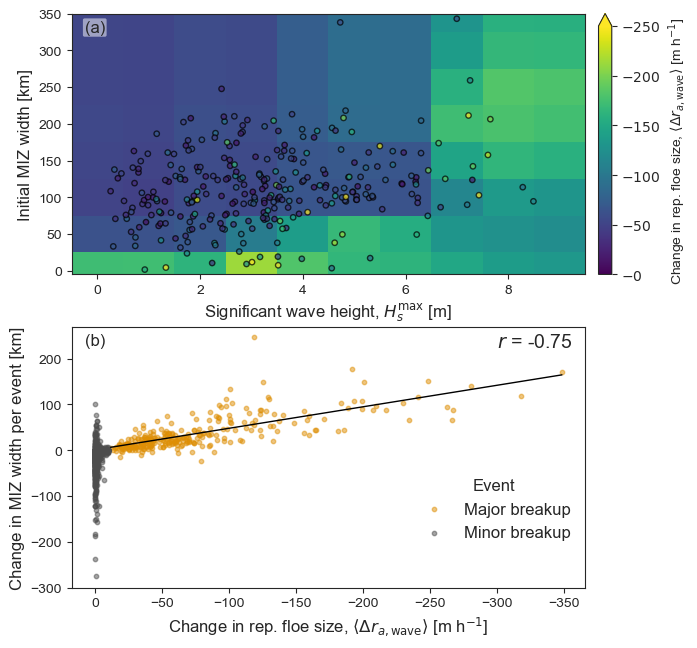

In [56]:

# Variables
x = 'wave_sig_ht_max'
y = 'miz_width_init'
colvar = 'dafsd_wave_ra_ave'

# Ensure that no missing values are present across all columns used
df_breakup[colvar] = abs(df_breakup[colvar])

df_clean = df_breakup[df_breakup['event']=='major_breakup']
df_clean = df_clean[[x, y, colvar]].dropna()

# df_event =  df_breakup[[x, y, colvar, 'event']].dropna()['event']
# Select features (X) and response (y)
X = df_clean[[x, y]]
y_response = df_clean[colvar]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Random Forest regression model
# rf = DecisionTreeRegressor(max_depth=20)
rf = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=5)
rf.fit(X_scaled, y_response)

# Define the range of values for the heatmap
wave_height_range = np.arange(0, 10, 1)  # Use clean DataFrame
miz_width_range = np.arange(0, 351, 50)  # Define a reasonable range for MIZ width

wave_height_grid, miz_width_grid = np.meshgrid(wave_height_range, miz_width_range)
grid_points = np.c_[wave_height_grid.ravel(), miz_width_grid.ravel()]

# Standardize the grid points using the same scaler
grid_points_scaled = scaler.transform(grid_points)

# Predict using the Random Forest model
predicted_values = rf.predict(grid_points_scaled)

# Reshape the predictions to match the grid shape
predicted_values_grid = predicted_values.reshape(wave_height_grid.shape)

# Plot using pcolormesh
# plt.figure(figsize=(plot_settings.width, plot_settings.height))
fig, axes = plt.subplots(2, 1, figsize=[plot_settings.width, plot_settings.height*1.5], gridspec_kw={'height_ratios': [1, 1]})
ax = axes[0]


vmin = 0 # min(predicted_values_grid.min(), df_clean[colvar].min())
vmax = 250# max(predicted_values_grid.max(), df_clean[colvar].max())

mesh = ax.pcolormesh(wave_height_grid, miz_width_grid, predicted_values_grid, cmap='viridis', shading='auto', vmin=vmin, vmax=vmax)
scatter = ax.scatter(df_clean[x], df_clean[y], c=df_clean[colvar],
                      cmap='viridis', edgecolor='k', s=15, alpha=0.7, vmin=vmin, vmax=vmax, label='Observed Data')



ax.set_xlabel('Significant wave height, $H_s^{\max}$ [m]')
ax.set_ylabel('Initial MIZ width [km]')


ax_new_scatter = axes[1]
# df_breakup2 = pd.read_csv(netcdfpath+'csvs/breakup_n_346.csv')
df_breakup2 = df_breakup.copy()
df_breakup2['dafsd_wave_ra_ave'] = -df_breakup2['dafsd_wave_ra_ave']
cmap = [sns.color_palette("colorblind", 2)[1], [0.3, 0.3, 0.3]]

for i, event in enumerate(['major_breakup', 'minor_breakup']):
    if event == 'major_breakup':
        scatter1 = sns.regplot(
            x='dafsd_wave_ra_ave',
            y='delta_miz_width_signed',
            data=df_breakup2[df_breakup2['event'] == event],  # Filter for each event
            scatter_kws={'color': cmap[i], 'alpha': 0.5, 's': 10},  # Set scatter color and marker size
            line_kws={'color': 'black', 'lw': 1},  # Set line color and width
            ci=None,  # Disable confidence interval
            ax=ax_new_scatter,  # Use the same axis
            label='Major breakup'
        )
        annotate_correlation(df_breakup2[df_breakup2['event'] == event], 'dafsd_wave_ra_ave', 'delta_miz_width_signed')
    else:
        scatter2 = sns.regplot(
            x='dafsd_wave_ra_ave',
            y='delta_miz_width_signed',
            data=df_breakup2[df_breakup2['event'] == event],  # Filter for each event
            scatter_kws={'color': cmap[1], 'alpha': 0.5, 's': 10},  # Set scatter color and marker size
            line_kws={'color': 'tab:gray', 'lw': 0},  # No line for this event
            ci=None,  # Disable confidence interval
            ax=ax_new_scatter,  # Use the same axis
            label='Minor breakup'
        )

# Set axis labels
ax_new_scatter.set_xlabel('Change in rep. floe size, $\langle \Delta r_{a, \mathrm{wave}} \\rangle$ [m h$^{-1}$]', fontsize=12)
ax_new_scatter.set_ylabel('Change in MIZ width per event [km]', fontsize=12)

# Add label text in the plot

ax.text(plot_settings.label_x, plot_settings.label_y, f'({chr(97 + 0)})', transform=ax.transAxes, 
        fontsize=plot_settings.fontsize, verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.1'),
        zorder=3)

ax_new_scatter.text(plot_settings.label_x, plot_settings.label_y, f'({chr(97 + 1)})', transform=ax_new_scatter.transAxes, 
        fontsize=plot_settings.fontsize, verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.1'),
        zorder=3)

# Invert the x-axis
ax_new_scatter.invert_xaxis()

# Create a combined legend for both scatter plots
handles1, labels1 = scatter1.get_legend_handles_labels()  # Handles and labels for Major breakup
handles2, labels2 = scatter2.get_legend_handles_labels()  # Handles and labels for Minor breakup

# Combine both handles and labels
combined_handles = handles1 #+ handles2
combined_labels = labels1 #+ labels2

# Create the legend
scatter_legend = ax_new_scatter.legend(
    handles=combined_handles, 
    labels=combined_labels, 
    title='Event', 
    title_fontsize=plot_settings.legendsize, 
    loc='lower right',  # Anchor the legend to the lower right
    bbox_to_anchor=(1, 0.125),
    ncol=1,  # Number of columns in the legend
    frameon=False, 
    fancybox=False,
    prop={'size': plot_settings.legendsize}  # Control the text size in the legend
)
ax_new_scatter.set_ylim(-300, 270)

# fig.subplots_adjust(hspace=0.25, wspace=0.1) 

fig.subplots_adjust(right=0.9, hspace=0.2, wspace=0.1)  # Adjust hspace for vertical space, wspace for horizontal
cbar_width = 0.02  # Width of the colorbar
pos1 = axes[0].get_position() 
# Create colorbar for vorticity (aligned with top row)
cbar_ax1 = fig.add_axes([0.92, pos1.y0, cbar_width, pos1.height])  # Align with axs[0, 2]
cbar1 = fig.colorbar(mesh, cax=cbar_ax1, extend='max')
cbar1.set_label('Change in rep. floe size, $\langle \Delta r_{a, \mathrm{wave}} \\rangle$ [m h$^{-1}$]', fontsize=10)

current_ticks = cbar1.get_ticks()
negative_ticks = -current_ticks
cbar1.set_ticklabels([f'${tick:.0f}$' for tick in negative_ticks])

axes[0].set_ylim(-5,350)

plt.savefig(savepath + 'explaining_breakup_rf.png', dpi=300, transparent=False, pad_inches=0.1)
plt.savefig(savepath + 'explaining_breakup_rf.pdf', dpi=300, transparent=False, pad_inches=0.1)
plt.show()

## Distribution of extreme events

In [52]:
df_dynamics = pd.read_csv(netcdfpath+'csvs/dynamics_extravars_events_0ms_n_263.csv')
df_dynamics
# for var in colvars:
    # df_dynamics[var] = df_dynamics[var].apply(lambda x: x.item() if isinstance(x, np.ndarray) else x)
# data = df_dynamics[df_dynamics['event'] != 'reference']
data = df_dynamics
data['delta_ice_edge_km'] = data['delta_ice_edge']*111

time_col = 'time'
# Ensure 'time' is in datetime format
data[time_col] = pd.to_datetime(data[time_col])
cols_to_sum = [col for col in data.columns if col not in ['track', 'event', time_col]]

data = data.groupby(['track', 'event']).agg({
    **{col: 'sum' for col in cols_to_sum},  # Apply 'sum' to all columns except 'time'
    time_col: 'median'  # Apply 'median' to the 'time' column
}).reset_index()

data_tmp = data.groupby(['track', 'event']).agg({
    **{col: 'sum' for col in cols_to_sum},  # Apply 'sum' to all columns except 'time'
    time_col: 'median'  # Apply 'median' to the 'time' column
}).reset_index()


data['time'] = pd.to_datetime(data['time'])
data['month'] = data['time'].dt.month
data['day-month'] = data['time'].dt.strftime('%d-%m')  # Formats as 'day-month'

data_tmp['time'] = pd.to_datetime(data_tmp['time'])
data_tmp['month'] = data_tmp['time'].dt.month
data_tmp['day-month'] = data_tmp['time'].dt.strftime('%d-%m')  # Formats as 'day-month'

data['time'] = pd.to_datetime(data['time'])
data['month'] = data['time'].dt.month
data['month'] = data['month'].astype(str).str.zfill(2)  # Add leading zero to single-digit months
data['month'] = pd.to_datetime('15-' + data['month'] + '-2018', format='%d-%m-%Y')
data['day-month'] = data['time'].dt.strftime('%d-%m')  # Formats as 'day-month'
data['day-month'] = pd.to_datetime(data['day-month'] + '-2018', format='%d-%m-%Y')

data_tmp['time'] = pd.to_datetime(data_tmp['time'])
data_tmp['month'] = data_tmp['time'].dt.month
data_tmp['month'] = data_tmp['month'].astype(str).str.zfill(2)  # Add leading zero to single-digit months
# data_tmp['month'] = pd.to_datetime('15-' + data_tmp['month'] + '-2018', format='%d-%m-%Y')
data_tmp['day-month'] = data_tmp['time'].dt.strftime('%d-%m')  # Formats as 'day-month'
data_tmp['day-month'] = pd.to_datetime(data_tmp['day-month'] + '-2018', format='%d-%m-%Y')

# monthly_mean = data.groupby('month').mean()
# monthly_std = data.groupby('month').std()

palette = cmo.balance

# Convert the 'month' column to integers, handling potential issues
data_tmp['month'] = pd.to_numeric(data_tmp['month'], errors='coerce').fillna(0).astype(int)
data_tmp['month'] 


data['delta_ice_edge_km']
data.describe()

track  delta_ice_edge  delta_ice_edge_per_hour  \
count  1.175000e+03     1175.000000              1175.000000   
mean   2.016819e+08       -0.021108                -0.000373   
min    2.015196e+08       -0.987301                -0.061387   
25%    2.016210e+08       -0.112673                -0.004732   
50%    2.017205e+08       -0.012192                -0.000675   
75%    2.018201e+08        0.077547                 0.004122   
max    2.018296e+08        0.643921                 0.053515   
std    1.102526e+05        0.187337                 0.008946   

       abs_delta_ice_edge  abs_delta_ice_edge_per_hour  delta_miz_width  \
count         1175.000000                  1175.000000      1175.000000   
mean             0.190714                     0.008090        -3.885887   
min              0.000000                     0.000000      -132.101776   
25%              0.081074                     0.004058       -13.122665   
50%              0.150429                     0.006026        -3.982880   
75%              0.247953                     0.010079         4.478466   
max              1.439075                     0.065834       235.686501   
std              0.163313                     0.006878        28.455831   

       delta_miz_width_per_hour  abs_delta_miz_width  \
count               1175.000000          1175.000000   
mean                  -0.222126            35.706864   
min                  -18.162421             1.266212   
25%                   -0.678629            15.749319   
50%                   -0.216639            26.696251   
75%                    0.200608            43.770226   
max                   15.434979           363.537483   
std                    1.577598            33.802941   

       abs_delta_miz_width_per_hour         dist  ...           SIA  \
count                   1175.000000  1175.000000  ...  1.175000e+03   
mean                       1.572247    -3.002737  ...  3.543292e+11   
min                        0.248509 -4186.481973  ...  4.975245e+10   
25%                        0.748619  -271.382490  ...  2.390827e+11   
50%                        1.106508    -4.930733  ...  3.129618e+11   
75%                        1.783183   200.795869  ...  4.302027e+11   
max                       19.868323  6121.119040  ...  1.414152e+12   
std                        1.566392   668.039532  ...  1.754133e+11   

                SIV  delta_MIZ_SIE  delta_MIZ_SIA  delta_MIZ_SIV  \
count  1.175000e+03   1.175000e+03   1.175000e+03   1.175000e+03   
mean   4.088882e+11  -1.125302e+09  -5.441501e+08  -2.061604e+08   
min    6.103423e+10  -3.613786e+10  -3.563626e+10  -6.060262e+10   
25%    2.579531e+11  -3.912565e+09  -3.479900e+09  -1.059539e+09   
50%    3.461897e+11  -1.134379e+09  -9.940910e+08  -2.259305e+08   
75%    5.119191e+11   1.323813e+09   1.432193e+09   5.885780e+08   
max    1.615061e+12   5.467699e+10   4.565391e+10   4.210893e+10   
std    2.381320e+11   7.774381e+09   6.840265e+09   5.749741e+09   

       delta_hi_miz  delta_ice_edge_km                           time  \
count   1175.000000        1175.000000                           1175   
mean       0.011466          -2.343012  2017-04-11 15:29:05.617021184   
min       -2.134142        -109.590397            2015-07-10 00:30:00   
25%       -0.016608         -12.506681            2016-07-21 00:30:00   
50%        0.000000          -1.353287            2017-07-15 03:00:00   
75%        0.033062           8.607725            2018-07-10 16:45:00   
max        1.393109          71.475220            2018-11-28 22:00:00   
std        0.184910          20.794432                            NaN   

                               month                      day-month  
count                           1175                           1175  
mean   2018-09-14 07:35:53.872340480  2018-09-14 22:19:30.382978816  
min              2018-07-15 00:00:00            2018-07-02 00:00:00  
25%              2018-08-15 00:00:00            2018-08-08 00:00:

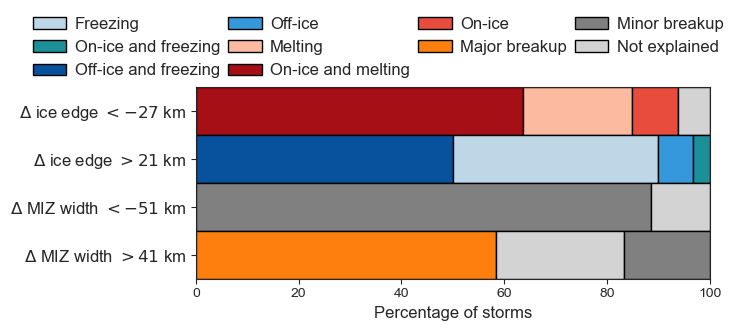

In [53]:
event_significance = 0.7 # % of event explained
buffer = 0.1 # Error between two events

def get_event_distribution(data, option='max', threshold=30):
    data_reference = data[data['event'].isin(['reference'])]
    # data_reference = data_reference.groupby(['track', 'event']).sum().reset_index()

    data_reference = (
        data_reference
        .groupby(['track', 'event'])
        .sum(numeric_only=True)
        .reset_index()
    )
    if option == 'max':
        data_reference = data_reference[data_reference['delta_ice_edge_km'] > threshold].sort_values(by='event')
    else:
        data_reference = data_reference[data_reference['delta_ice_edge_km'] < threshold].sort_values(by='event')

    track_to_compare = data_reference['track']
    filtered_data_tmp = data_tmp[data_tmp['track'].isin(track_to_compare)]
    filtered_data_tmp['track'].unique()
    track_numbers = filtered_data_tmp['track'].unique()
    results = []
    for track_number in track_numbers:
        track_data = filtered_data_tmp[filtered_data_tmp['track'] == track_number]
        track_data = track_data[['track', 'event', 'delta_ice_edge_km']]
        reference_data = track_data[track_data['event'].isin(['reference'])]
        track_data = track_data[track_data['event'].isin(['melting', 'freezing','on_ice','off_ice'])]
        if option == 'max':
            sorted_track_data = track_data.sort_values(by='delta_ice_edge_km', ascending=False)
            max_value = sorted_track_data['delta_ice_edge_km'].iloc[0]
            close_to_max = sorted_track_data[sorted_track_data['delta_ice_edge_km'] >= max_value - max_value*buffer]
            # close_to_max = sorted_track_data[sorted_track_data['delta_ice_edge_km']==max_value]
        else:
            # Option is min
            sorted_track_data = track_data.sort_values(by='delta_ice_edge_km', ascending=True)
            max_value = sorted_track_data['delta_ice_edge_km'].iloc[0]
            close_to_max = sorted_track_data[sorted_track_data['delta_ice_edge_km'] <= max_value + abs(max_value)*buffer]
            # close_to_max = sorted_track_data[sorted_track_data['delta_ice_edge_km']==max_value]
            # print(close_to_max)
            # print(max_value)
            # print(close_to_max)

        if (abs(max_value) < event_significance*abs(reference_data['delta_ice_edge_km'].values)):
            # If 75% isnt explained then discard it!
            close_to_max.iloc[:,1] = str(np.nan)
        
        if len(close_to_max) > 1:
            # Sort unique event names alphabetically before concatenating
            concatenated_event = '_'.join(sorted(close_to_max['event'].unique()))
            close_to_max = close_to_max.iloc[:1].copy()  # Take the first row as a base
            close_to_max['event'] = concatenated_event  # Replace event with concatenated names
            results.append(close_to_max)
        else:
            results.append(close_to_max)

    # Combine all results into a single DataFrame
    final_result = pd.concat(results)
    event_distribution = final_result.groupby('event').size()
    
    return event_distribution, track_numbers


def get_event_distribution_wave(data, option='max', threshold=30):
    data_reference = data[data['event'].isin(['reference'])]
    data_reference = data_reference.groupby(['track', 'event']).sum().reset_index()

    if option == 'max':
        data_reference = data_reference[data_reference['delta_miz_width_signed'] > threshold].sort_values(by='event')
    else:
        data_reference = data_reference[data_reference['delta_miz_width_signed'] < threshold].sort_values(by='event')

    track_to_compare = data_reference['track']
    filtered_data_tmp = data[data['track'].isin(track_to_compare)]
    filtered_data_tmp['track'].unique()
    # filtered_data_tmp[filtered_data_tmp['event'].isin(['melting'])]
    track_numbers = filtered_data_tmp['track'].unique()
    results = []
    for track_number in track_numbers:
        track_data = filtered_data_tmp[filtered_data_tmp['track'] == track_number]
        track_data = track_data[['track', 'event', 'delta_miz_width_signed']]
        reference_data = track_data[track_data['event'].isin(['reference'])]
        track_data = track_data[track_data['event'].isin(['no_event', 'breakup'])]
        if option == 'max':
            sorted_track_data = track_data.sort_values(by='delta_miz_width_signed', ascending=False)
            max_value = sorted_track_data['delta_miz_width_signed'].iloc[0]
            close_to_max = sorted_track_data[sorted_track_data['delta_miz_width_signed'] >= max_value - max_value*buffer]
            # close_to_max = sorted_track_data[sorted_track_data['delta_miz_width_signed']==max_value]
            # print(max_value)
            # print(close_to_max)
        else:
            # Option is min
            sorted_track_data = track_data.sort_values(by='delta_miz_width_signed', ascending=True)
            max_value = sorted_track_data['delta_miz_width_signed'].iloc[0]
            close_to_max = sorted_track_data[sorted_track_data['delta_miz_width_signed'] <= max_value + abs(max_value)*buffer]
           
        if close_to_max.empty:
            # print("close_to_max is empty.")
            track_numbers = np.delete(track_numbers, np.where(track_numbers == track_number))

        if (abs(max_value) < event_significance*abs(reference_data['delta_miz_width_signed'].values)):
            # If 75% isnt explained then discard it!
            close_to_max.iloc[:,1] = str(np.nan)
        
        if len(close_to_max) > 1:
            # Sort unique event names alphabetically before concatenating
            concatenated_event = '_'.join(sorted(close_to_max['event'].unique()))
            close_to_max = close_to_max.iloc[:1].copy()  # Take the first row as a base
            close_to_max['event'] = concatenated_event  # Replace event with concatenated names
            results.append(close_to_max)
        else:
            results.append(close_to_max)

    # Combine all results into a single DataFrame
    final_result = pd.concat(results)
    event_distribution = final_result.groupby('event').size()
    
    return event_distribution, track_numbers


# Group the data by track and event
events = ['off_ice', 'reference', 'on_ice', 'melting', 'freezing']
data_tmp = data[data['event'].isin(events)]
# data_tmp = data_tmp.groupby(['track', 'event']).sum().reset_index()
data_tmp = (
    data_tmp
    .groupby(['track', 'event'])
    .sum(numeric_only=True)
    .reset_index()
)

threshold = 30
threshold_miz = 50
number_of_storms = len(data_tmp['track'].unique())

fig, ax = plt.subplots(1, 1, figsize=(plot_settings.width, plot_settings.height/2), sharex=False)

# Define category colors
category_colors = {
    'freezing': '#bdd7e7',           # Blue for cold (freezing)
    'freezing_on_ice': '#1c9099',  # Blue for cold (off-ice freezing)
    'freezing_off_ice': '#08519c',  # Blue for cold (off-ice freezing)
    'off_ice': '#3498db',            # Blue for cold (off-ice)

    'melting': '#fcbba1',            # Red for warm (melting)
    'melting_on_ice': '#a50f15',     # Red for warm (on-ice melting)
    'melting_off_ice': '#fcae91',     # Red for warm (on-ice melting)
    'on_ice': '#e74c3c',             # Red for warm (on-ice)

    'breakup': 'tab:orange',
    'no_event': 'gray',
    'nan': 'lightgray',      
    'reference': 'gray'              # Gray for neutral (reference)
}

category_labels = {
    'freezing': 'Freezing',           # Blue for cold (freezing)
    'freezing_on_ice': 'On-ice and freezing',  # Blue for cold (off-ice freezing)
    'freezing_off_ice': 'Off-ice and freezing',  # Blue for cold (off-ice freezing)
    'off_ice': 'Off-ice',            # Blue for cold (off-ice)

    'melting': 'Melting',            # Red for warm (melting)
    'melting_on_ice': 'On-ice and melting',     # Red for warm (on-ice melting)
    'melting_off_ice': 'Off-ice and melting',     # Red for warm (on-ice melting)
    'on_ice': 'On-ice',             # Red for warm (on-ice)

    'breakup': 'Major breakup',
    'no_event': 'Minor breakup',
    'nan': 'Not explained',              
    'reference': 'gray'              # Gray for neutral (reference)
}

# Define helper function to sort and plot
def plot_horizontal_stacked_bar(ax, percentages, y_pos, track_numbers):
    # Sort values and categories in descending order
    sorted_indices = np.argsort(percentages.values)[::-1]  # Sort indices descending
    sorted_categories = [percentages.index[i] for i in sorted_indices]
    sorted_values = percentages.values[sorted_indices]

    # Plot sorted bar segments
    cumulative_width = 0
    for category, value in zip(sorted_categories, sorted_values):
        ax.barh(
            [y_pos],  # Position on y-axis
            value,
            left=cumulative_width,  # Stack horizontally
            label=category,  # Raw category key for legend handling
            color=category_colors.get(category, 'gray'),  # Use color from dictionary or default to gray
            edgecolor='black',
            height=1
        )
        cumulative_width += value  # Update cumulative width for stacking


percentile_low = 10
percentile_high = 90

# First bar
percentile_10 = np.percentile(data['delta_ice_edge_km'], percentile_low)
event_distribution, track_numbers = get_event_distribution(data, option='min', threshold=percentile_10)
percentages_1 = event_distribution / len(track_numbers) * 100
plot_horizontal_stacked_bar(ax, percentages_1, 1, track_numbers)

# Second bar
percentile_90 = np.percentile(data['delta_ice_edge_km'], percentile_high)
event_distribution, track_numbers = get_event_distribution(data, option='max', threshold=percentile_90)
percentages_2 = event_distribution / len(track_numbers) * 100
plot_horizontal_stacked_bar(ax, percentages_2, 2, track_numbers)

# Third bar
df_breakup = pd.read_csv(netcdfpath + 'csvs/breakup_n_347.csv')
data_wave = df_breakup
percentile_10_wave = np.percentile(data_wave['delta_miz_width_signed'], percentile_low)
event_distribution_waves, track_numbers_waves = get_event_distribution_wave(data_wave, option='min', threshold=percentile_10_wave)
percentages_3 = event_distribution_waves / len(track_numbers_waves) * 100
plot_horizontal_stacked_bar(ax, percentages_3, 3, track_numbers_waves)

# Fourth bar
percentile_90_wave = np.percentile(data_wave['delta_miz_width_signed'], percentile_high)
event_distribution_waves, track_numbers_waves = get_event_distribution_wave(data_wave, option='max', threshold=percentile_90_wave)
percentages_4 = event_distribution_waves / len(track_numbers_waves) * 100
plot_horizontal_stacked_bar(ax, percentages_4, 4, track_numbers_waves)

# Customize the plot
ax.set_yticks([1, 2, 3, 4])
ax.set_yticklabels([
    f'$\Delta$ ice edge $<{round(percentile_10)}$ km',
    f'$\Delta$ ice edge $>{round(percentile_90)}$ km',
    f'$\Delta$ MIZ width $<{round(percentile_10_wave)}$ km',
    f'$\Delta$ MIZ width $>{round(percentile_90_wave)}$ km'
], fontsize=12)
ax.set_xlabel('Percentage of storms')

# Process legend handles and labels
handles, labels = ax.get_legend_handles_labels()

# Map raw labels to descriptive labels and remove duplicates
unique_handles_labels = {label: (handle, label) for handle, label in zip(handles, labels)}
sorted_handles_labels = sorted(
    unique_handles_labels.items(),
    key=lambda item: list(category_colors.keys()).index(item[0]) if item[0] in category_colors else float('inf')
)

# Extract sorted handles and labels
handles_sorted = [item[1][0] for item in sorted_handles_labels]
labels_sorted = [category_labels[item[1][1]] for item in sorted_handles_labels]

# Add the legend
fig.legend(
    handles_sorted,
    labels_sorted,
    loc='upper center',
    ncol=4,
    columnspacing=0.5,  # Reduce space between columns
    handletextpad=0.5,  # Reduce space b
    bbox_to_anchor=(0.4, 1.225),
    fancybox=False, framealpha=0, facecolor=None, edgecolor=None
)
ax.invert_yaxis()
ax.set_xlim([0,100])
ax.set_ylim([4.5,0.5])
# plt.tight_layout()
plt.savefig(savepath + 'distribution_of_all_events.pdf', dpi=300, transparent=False, pad_inches=0.1)
plt.show()
